In [2]:
!nvidia-smi 

Mon Jul  7 14:21:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:17:00.0 Off |                  Off |
| 30%   37C    P8             30W /  300W |   45805MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import pydicom
from skimage.draw import disk


xml_path = 'cocacoronarycalciumandchestcts-2/Gated_release_final/calcium_xml/0.xml'
dicom_dir = 'cocacoronarycalciumandchestcts-2/Gated_release_final/patient/0/Pro_Gated_CS_3.0_I30f_3_70%'
output_dir = 'masks_output'
os.makedirs(output_dir, exist_ok=True)


tree = ET.parse(xml_path)
root = tree.getroot()




ModuleNotFoundError: No module named 'skimage'

In [123]:
print(roi_points)

None


Saved mask: output_masks/Image_23_Left Circumflex Artery_0.png
Saved mask: output_masks/Image_24_Left Circumflex Artery_0.png
Saved mask: output_masks/Image_32_Left Circumflex Artery_0.png
Saved mask: output_masks/Image_32_Left Anterior Descending Artery_1.png
Saved mask: output_masks/Image_33_Left Anterior Descending Artery_0.png
Saved mask: output_masks/Image_33_Left Circumflex Artery_1.png
Saved mask: output_masks/Image_34_Left Anterior Descending Artery_0.png
Saved mask: output_masks/Image_35_Left Anterior Descending Artery_0.png
Saved mask: output_masks/Image_35_Left Anterior Descending Artery_1.png
Saved mask: output_masks/Image_36_Left Anterior Descending Artery_0.png
Saved mask: output_masks/Image_36_Left Anterior Descending Artery_1.png
Saved mask: output_masks/Image_36_Left Anterior Descending Artery_2.png
Saved mask: output_masks/Image_36_Left Anterior Descending Artery_3.png
Image: Image_23
  ROI: Left Circumflex Artery_0, Shape: (512, 512), Sum: 16320
    Pixel count: 64
 

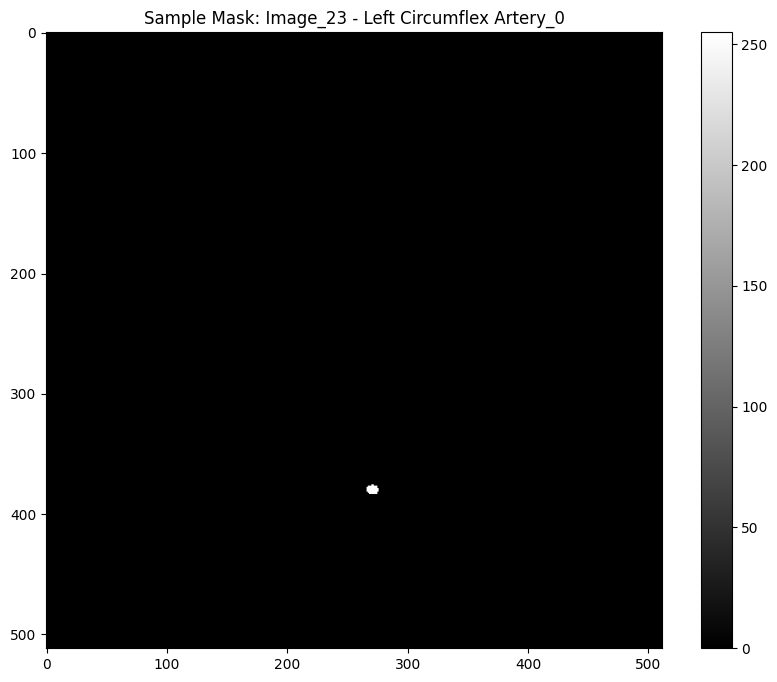

In [173]:
import numpy as np


file_path = 'cocacoronarycalciumandchestcts-2/Gated_release_final/calcium_xml/2.xml'
with open(file_path, 'r') as f:
    xml_content = f.read()


masks = extract_masks_from_plist_string(xml_content)


output_dir = "output_masks"
save_masks(masks, output_dir)
visualize_masks(masks, output_dir)


for image_key, rois in masks.items():
    print(f"Image: {image_key}")
    for roi_key, mask in rois.items():
        print(f"  ROI: {roi_key}, Shape: {mask.shape}, Sum: {np.sum(mask)}")
        

        pixel_count = np.sum(mask > 0)
        print(f"    Pixel count: {pixel_count}")
        

        if pixel_count > 0:

            y_indices, x_indices = np.where(mask > 0)
            centroid_x = np.mean(x_indices)
            centroid_y = np.mean(y_indices)
            print(f"    Centroid: ({centroid_x:.2f}, {centroid_y:.2f})")



In [ ]:
# Display one of the masks (if available)
if masks and list(masks.values()) and list(list(masks.values())[0].values()):
    first_image = list(masks.keys())[0]
    first_roi = list(masks[first_image].keys())[0]
    sample_mask = masks[first_image][first_roi]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(sample_mask, cmap='gray')
    plt.title(f"Sample Mask: {first_image} - {first_roi}")
    plt.colorbar()
    plt.axis('on')
    plt.savefig(f"{output_dir}/sample_mask_display.png")
    plt.show()

# Old Extractor

In [249]:
import plistlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom.uid
import datetime
import io
from pathlib import Path
from tqdm import tqdm

class MaskExtractor:
    """
    Extract binary masks from XML/plist files and save them in various formats
    including individual PNGs and a combined DICOM file.
    """
    
    def __init__(self, output_dir="output_masks", total_slices=57):
        """Initialize the mask extractor."""
        self.output_dir = output_dir
        self.total_slices = total_slices  # Default number of slices for all DICOM files
        os.makedirs(output_dir, exist_ok=True)
        
    def extract_from_file(self, file_path):
        """Extract masks from a file."""
        with open(file_path, 'rb') as f:
            try:
                return self._extract_masks_from_plist(f)
            except Exception as e:
                print(f"Error parsing as binary plist: {e}")
                # Try as text
                f.seek(0)
                xml_content = f.read().decode('utf-8', errors='ignore')
                return self._extract_masks_from_plist(xml_content)
    
    def extract_from_string(self, xml_content):
        """Extract masks from a string."""
        return self._extract_masks_from_plist(xml_content)
        
    def _extract_masks_from_plist(self, plist_content):
        """Extract binary masks from a plist XML string or file."""
        try:
            # Try to parse the content
            if isinstance(plist_content, str):
                data = plistlib.loads(plist_content.encode('utf-8'))
            else:
                # If it's already a file-like object or bytes
                data = plistlib.load(plist_content)
            
            # Dictionary to store masks for each image and ROI
            masks = {}
            
            # Process each image in the data
            for image_dict in data.get('Images', []):
                image_index = image_dict.get('ImageIndex')
                masks[f"Image_{image_index}"] = {}
                
                for roi in image_dict.get('ROIs', []):
                    roi_name = roi.get('Name', 'Unknown').replace(' ', '_')
                    roi_index = roi.get('IndexInImage', 0)
                    points = self._extract_point_coordinates(roi)
                    
                    if points:
                        # Create a mask using the points
                        mask = self._create_mask_from_points(points)
                        masks[f"Image_{image_index}"][f"{roi_name}_{roi_index}"] = mask
            
            return masks
        
        except Exception as e:
            print(f"Error extracting masks: {e}")
            return {}
    
    def _extract_point_coordinates(self, roi):
        """Extract point coordinates from ROI data."""
        points = []
        # Try to get points from Point_px array
        for point_str in roi.get('Point_px', []):
            # Clean and parse point string
            try:
                # Remove parentheses and split by comma
                cleaned = point_str.replace('(', '').replace(')', '')
                x, y = map(float, cleaned.split(','))
                points.append((x, y))
            except ValueError:
                print(f"Error parsing point: {point_str}")
        
        return points
    
    def _create_mask_from_points(self, points, width=512, height=512):
        """Create a binary mask from polygon points."""
        if not points or len(points) < 3:
            return np.zeros((height, width), dtype=np.uint8)
        
        # Calculate mask bounds
        x_coords, y_coords = zip(*points)
        
        # Create a blank image
        img = Image.new('L', (width, height), 0)
        draw = ImageDraw.Draw(img)
        
        # Draw the filled polygon
        draw.polygon(points, fill=255)
        
        # Convert to numpy array
        mask = np.array(img)
        return mask
    
    def save_masks_as_png(self, masks):
        """Save the binary masks as individual PNG files."""
        os.makedirs(self.output_dir, exist_ok=True)
        
        saved_files = []
        for image_key, rois in masks.items():
            for roi_key, mask in rois.items():
                filename = f"{self.output_dir}/{image_key}_{roi_key}.png"
                plt.imsave(filename, mask, cmap='gray')
                saved_files.append(filename)
                print(f"Saved mask as PNG: {filename}")
        
        return saved_files
    
    def save_masks_as_dicom(self, masks, output_filename=None, series_description="Binary Masks"):
        """
        Save binary masks as a multi-frame DICOM file with exactly self.total_slices frames.
        Masks are positioned according to their image index.
        
        Args:
            masks: Dictionary of mask data
            output_filename: Name of the output DICOM file (defaults to masks.dcm in output_dir)
            series_description: Description for the DICOM series
        
        Returns:
            Path to the saved DICOM file
        """
        if output_filename is None:
            output_filename = os.path.join(self.output_dir, "masks.dcm")
        else:
            # Make sure the path is within output_dir
            if not os.path.dirname(output_filename):
                output_filename = os.path.join(self.output_dir, output_filename)
        
        if not masks:
            print("No masks available to save as DICOM.")
            return None
            
        # Determine mask dimensions from the first mask
        first_mask = None
        for image_key, rois in masks.items():
            for roi_key, mask in rois.items():
                first_mask = mask
                break
            if first_mask is not None:
                break
                
        if first_mask is None:
            print("No masks available to save as DICOM.")
            return None
            
        mask_height, mask_width = first_mask.shape
        
        # Create an empty volume with self.total_slices slices
        mask_volume = np.zeros((self.total_slices, mask_height, mask_width), dtype=np.uint8)
        
        # Track which masks are placed in the volume and their descriptions
        mask_descriptions = ["Empty"] * self.total_slices  # Default description for empty slices
        
        # Place each mask in the appropriate slice based on the image index
        for image_key, rois in masks.items():
            try:
                # Extract image index from the key (format: "Image_N")
                image_index = int(image_key.split('_')[1])
                
                # Check if the image index is within valid range
                if 0 <= image_index < self.total_slices:
                    # Combine all ROIs for this image into a single mask if multiple exist
                    combined_mask = np.zeros((mask_height, mask_width), dtype=np.uint8)
                    roi_descriptions = []
                    
                    for roi_key, mask in rois.items():
                        # Resize mask if needed
                        if mask.shape != (mask_height, mask_width):
                            mask_img = Image.fromarray(mask)
                            mask_img = mask_img.resize((mask_width, mask_height))
                            mask = np.array(mask_img)
                        
                        # Combine with existing ROIs (binary OR operation)
                        combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8) * 255
                        roi_descriptions.append(roi_key)
                    
                    # Place the combined mask at the correct slice
                    mask_volume[image_index] = combined_mask
                    
                    # Update the description
                    mask_descriptions[image_index] = f"{image_key}: " + ", ".join(roi_descriptions)
                else:
                    print(f"Warning: Image index {image_index} is out of range (0-{self.total_slices-1})")
            except (ValueError, IndexError) as e:
                print(f"Error processing {image_key}: {e}")
        
        # File meta info dataset
        file_meta = Dataset()
        file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.7'  # Secondary Capture Image Storage
        file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
        file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
        
        # Main dataset
        ds = FileDataset(output_filename, {}, file_meta=file_meta, preamble=b"\0" * 128)
        
        # Add required DICOM tags
        ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.7'  # Secondary Capture Image Storage
        ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
        ds.StudyInstanceUID = pydicom.uid.generate_uid()
        ds.SeriesInstanceUID = pydicom.uid.generate_uid()
        
        # Patient information (using generic values)
        ds.PatientName = "ANONYMOUS"
        ds.PatientID = "MASK"
        ds.PatientBirthDate = ""
        
        # Study and series information
        ds.StudyDate = datetime.datetime.now().strftime("%Y%m%d")
        ds.StudyTime = datetime.datetime.now().strftime("%H%M%S")
        ds.AccessionNumber = ""
        ds.Modality = "SEG"  # Segmentation
        ds.SeriesDescription = series_description
        
        # Image information
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.Rows = mask_height
        ds.Columns = mask_width
        ds.BitsAllocated = 8
        ds.BitsStored = 8
        ds.HighBit = 7
        ds.PixelRepresentation = 0
        
        # Set pixel data for multi-frame image
        ds.NumberOfFrames = self.total_slices
        
        # Store mask descriptions in private tags
        ds.add_new(0x0011, 'LO', f"Number of masks: {self.total_slices}")
        for i, desc in enumerate(mask_descriptions):
            tag = 0x00110010 + i
            ds.add_new(tag, 'LO', desc)
        
        # Store the pixel data
        ds.PixelData = mask_volume.tobytes()
        
        # Save the DICOM file
        ds.save_as(output_filename)
        print(f"Saved masks as DICOM file: {output_filename}")
        
        return output_filename
    
    def visualize_masks(self, masks):
        """Create visualization images of the masks."""
        os.makedirs(self.output_dir, exist_ok=True)
        
        for image_key, rois in masks.items():
            for roi_key, mask in rois.items():
                plt.figure(figsize=(8, 8))
                plt.imshow(mask, cmap='gray')
                plt.title(f"{image_key}: {roi_key}")
                plt.axis('off')
                plt.savefig(f"{self.output_dir}/viz_{image_key}_{roi_key}.png")
                plt.close()
    
    def process_file(self, file_path, save_png=True, save_dicom=True, visualize=True, dicom_filename=None):
        """Process a file and save masks in requested formats."""
        results = {
            'masks': None,
            'png_files': [],
            'dicom_file': None
        }
        
        # Extract masks
        masks = self.extract_from_file(file_path)
        results['masks'] = masks
        
        if not masks:
            print(f"No masks extracted from {file_path}")
            return results
        
        # Save as PNG files
        if save_png:
            results['png_files'] = self.save_masks_as_png(masks)
        
        # Save as DICOM
        if save_dicom:
            if dicom_filename is None:
                # Create a default name based on the input file
                base_name = os.path.splitext(os.path.basename(file_path))[0]
                dicom_filename = f"{base_name}_masks.dcm"
            
            results['dicom_file'] = self.save_masks_as_dicom(masks, dicom_filename)
        
        # Create visualizations
        if visualize:
            self.visualize_masks(masks)
        
        return results

# Example usage
def load_num_slices(base_path):
    """
    Find the correct patient directory and determine the number of slices.
    
    Args:
        base_path: Base path to the patient directory without the varying subdirectory
    
    Returns:
        Number of slices found, or 57 as default if cannot determine
    """
    try:
        # Look for subdirectories in the patient base directory
        if os.path.exists(base_path):
            subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
            
            # If subdirectories found, look for DICOM files in each
            for subdir in subdirs:
                full_path = os.path.join(base_path, subdir)
                # Look for DICOM files or folders that might contain them
                items = os.listdir(full_path)
                
                # Check if there are numbered directories (often used for slice storage)
                slice_dirs = [item for item in items if item.isdigit() and os.path.isdir(os.path.join(full_path, item))]
                if slice_dirs:
                    return len(slice_dirs)
                
                # Otherwise, look for .dcm files directly in this directory
                dcm_files = [item for item in items if item.lower().endswith('.dcm')]
                if dcm_files:
                    return len(dcm_files)
                
                # Recursively look one level deeper if needed
                for item in items:
                    if os.path.isdir(os.path.join(full_path, item)):
                        item_path = os.path.join(full_path, item)
                        sub_items = os.listdir(item_path)
                        # Check for numbered directories
                        sub_slice_dirs = [s for s in sub_items if s.isdigit() and os.path.isdir(os.path.join(item_path, s))]
                        if sub_slice_dirs:
                            return len(sub_slice_dirs)
                        # Check for DICOM files
                        sub_dcm_files = [s for s in sub_items if s.lower().endswith('.dcm')]
                        if sub_dcm_files:
                            return len(sub_dcm_files)
    except Exception as e:
        print(f"Error determining number of slices: {e}")
    
    # Default to 57 if number of slices cannot be determined
    print(f"Could not determine number of slices for {base_path}, using default (57)")
    return 57

def main():
    for i in tqdm(range(790)):
        input_file = f'cocacoronarycalciumandchestcts-2/Gated_release_final/calcium_xml/{i}.xml'
        
        # Determine the number of slices from the patient directory
        patient_base_path = f'cocacoronarycalciumandchestcts-2/Gated_release_final/patient/{i}'
        num_slices = load_num_slices(patient_base_path)
    
        # Create the extractor with the determined number of slices
        extractor = MaskExtractor(output_dir="output_masks", total_slices=num_slices)
    
        # Process the file
        results = extractor.process_file(
            input_file,
            save_png=False,
            save_dicom=True,
            visualize=False,
            dicom_filename=f"coronary_masks{i}.dcm"
        )
    
        # Report results
        if results['masks']:
            num_masks = sum(len(rois) for rois in results['masks'].values())
            print(f"\nSummary {i}:")
            print(f"- Extracted {num_masks} masks")
            print(f"- Total slices in DICOM: {num_slices}")
            print(f"- DICOM file: {results['dicom_file']}")
        else:
            print("No masks were extracted.")

if __name__ == "__main__":
    main()

  0%|▎                                                                                 | 3/790 [00:00<00:36, 21.58it/s]

Saved masks as DICOM file: output_masks\coronary_masks0.dcm

Summary 0:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks0.dcm
Saved masks as DICOM file: output_masks\coronary_masks1.dcm

Summary 1:
- Extracted 16 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks1.dcm
Saved masks as DICOM file: output_masks\coronary_masks2.dcm

Summary 2:
- Extracted 13 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks2.dcm
Saved masks as DICOM file: output_masks\coronary_masks3.dcm

Summary 3:
- Extracted 10 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks3.dcm
Saved masks as DICOM file: output_masks\coronary_masks4.dcm

Summary 4:
- Extracted 10 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks4.dcm


  1%|▉                                                                                 | 9/790 [00:00<00:36, 21.58it/s]

Saved masks as DICOM file: output_masks\coronary_masks5.dcm

Summary 5:
- Extracted 41 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks5.dcm
Saved masks as DICOM file: output_masks\coronary_masks6.dcm

Summary 6:
- Extracted 18 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks6.dcm
Saved masks as DICOM file: output_masks\coronary_masks7.dcm

Summary 7:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks7.dcm
Saved masks as DICOM file: output_masks\coronary_masks8.dcm

Summary 8:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks8.dcm
Saved masks as DICOM file: output_masks\coronary_masks9.dcm

Summary 9:
- Extracted 4 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks9.dcm
Saved masks as DICOM file: output_masks\coronary_masks10.dcm

Summary 10:
- Extracted 18 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_mask

  2%|█▌                                                                               | 15/790 [00:00<00:39, 19.56it/s]

Saved masks as DICOM file: output_masks\coronary_masks11.dcm

Summary 11:
- Extracted 12 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks11.dcm
Could not determine number of slices for cocacoronarycalciumandchestcts-2/Gated_release_final/patient/12, using default (57)
Saved masks as DICOM file: output_masks\coronary_masks12.dcm

Summary 12:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks12.dcm
Saved masks as DICOM file: output_masks\coronary_masks13.dcm

Summary 13:
- Extracted 44 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks13.dcm
Saved masks as DICOM file: output_masks\coronary_masks14.dcm

Summary 14:
- Extracted 30 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks14.dcm
Saved masks as DICOM file: output_masks\coronary_masks15.dcm

Summary 15:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks15.dcm


  3%|██▎                                                                              | 23/790 [00:00<00:30, 25.36it/s]

Saved masks as DICOM file: output_masks\coronary_masks16.dcm

Summary 16:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks16.dcm
Saved masks as DICOM file: output_masks\coronary_masks17.dcm

Summary 17:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks17.dcm
Saved masks as DICOM file: output_masks\coronary_masks18.dcm

Summary 18:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks18.dcm
Saved masks as DICOM file: output_masks\coronary_masks19.dcm

Summary 19:
- Extracted 2 masks
- Total slices in DICOM: 56
- DICOM file: output_masks\coronary_masks19.dcm
Saved masks as DICOM file: output_masks\coronary_masks20.dcm

Summary 20:
- Extracted 6 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks20.dcm
Saved masks as DICOM file: output_masks\coronary_masks21.dcm

Summary 21:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\c

  3%|██▋                                                                              | 26/790 [00:01<00:32, 23.76it/s]

Saved masks as DICOM file: output_masks\coronary_masks23.dcm

Summary 23:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks23.dcm
Saved masks as DICOM file: output_masks\coronary_masks24.dcm

Summary 24:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks24.dcm
Saved masks as DICOM file: output_masks\coronary_masks25.dcm

Summary 25:
- Extracted 27 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks25.dcm
Saved masks as DICOM file: output_masks\coronary_masks26.dcm

Summary 26:
- Extracted 17 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks26.dcm


  4%|██▉                                                                              | 29/790 [00:01<00:37, 20.51it/s]

Saved masks as DICOM file: output_masks\coronary_masks27.dcm

Summary 27:
- Extracted 8 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks27.dcm
Saved masks as DICOM file: output_masks\coronary_masks28.dcm

Summary 28:
- Extracted 27 masks
- Total slices in DICOM: 88
- DICOM file: output_masks\coronary_masks28.dcm
Saved masks as DICOM file: output_masks\coronary_masks29.dcm

Summary 29:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks29.dcm


  4%|███▎                                                                             | 32/790 [00:01<00:36, 20.95it/s]

Saved masks as DICOM file: output_masks\coronary_masks30.dcm

Summary 30:
- Extracted 23 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks30.dcm
Saved masks as DICOM file: output_masks\coronary_masks31.dcm

Summary 31:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks31.dcm
Saved masks as DICOM file: output_masks\coronary_masks32.dcm

Summary 32:
- Extracted 3 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks32.dcm
Saved masks as DICOM file: output_masks\coronary_masks33.dcm

Summary 33:
- Extracted 8 masks
- Total slices in DICOM: 114
- DICOM file: output_masks\coronary_masks33.dcm
Saved masks as DICOM file: output_masks\coronary_masks34.dcm

Summary 34:
- Extracted 6 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks34.dcm


  5%|███▉                                                                             | 38/790 [00:01<00:39, 19.16it/s]

Saved masks as DICOM file: output_masks\coronary_masks35.dcm

Summary 35:
- Extracted 4 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks35.dcm
Saved masks as DICOM file: output_masks\coronary_masks36.dcm

Summary 36:
- Extracted 12 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks36.dcm
Saved masks as DICOM file: output_masks\coronary_masks37.dcm

Summary 37:
- Extracted 37 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks37.dcm
Saved masks as DICOM file: output_masks\coronary_masks38.dcm

Summary 38:
- Extracted 8 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks38.dcm


  5%|████▎                                                                            | 42/790 [00:02<00:42, 17.65it/s]

Saved masks as DICOM file: output_masks\coronary_masks39.dcm

Summary 39:
- Extracted 33 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks39.dcm
Saved masks as DICOM file: output_masks\coronary_masks40.dcm

Summary 40:
- Extracted 29 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks40.dcm
Saved masks as DICOM file: output_masks\coronary_masks41.dcm

Summary 41:
- Extracted 11 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks41.dcm
Saved masks as DICOM file: output_masks\coronary_masks42.dcm

Summary 42:
- Extracted 13 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks42.dcm


  6%|████▉                                                                            | 48/790 [00:02<00:35, 21.15it/s]

Saved masks as DICOM file: output_masks\coronary_masks43.dcm

Summary 43:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks43.dcm
Saved masks as DICOM file: output_masks\coronary_masks44.dcm

Summary 44:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks44.dcm
Saved masks as DICOM file: output_masks\coronary_masks45.dcm

Summary 45:
- Extracted 9 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks45.dcm
Saved masks as DICOM file: output_masks\coronary_masks46.dcm

Summary 46:
- Extracted 16 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks46.dcm
Saved masks as DICOM file: output_masks\coronary_masks47.dcm

Summary 47:
- Extracted 25 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks47.dcm
Saved masks as DICOM file: output_masks\coronary_masks48.dcm

Summary 48:
- Extracted 17 masks
- Total slices in DICOM: 46
- DICOM file: output_mask

  7%|█████▋                                                                           | 55/790 [00:02<00:28, 25.51it/s]

Saved masks as DICOM file: output_masks\coronary_masks49.dcm

Summary 49:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks49.dcm
Saved masks as DICOM file: output_masks\coronary_masks50.dcm

Summary 50:
- Extracted 10 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks50.dcm
Saved masks as DICOM file: output_masks\coronary_masks51.dcm

Summary 51:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks51.dcm
Saved masks as DICOM file: output_masks\coronary_masks52.dcm

Summary 52:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks52.dcm
Saved masks as DICOM file: output_masks\coronary_masks53.dcm

Summary 53:
- Extracted 2 masks
- Total slices in DICOM: 69
- DICOM file: output_masks\coronary_masks53.dcm
Saved masks as DICOM file: output_masks\coronary_masks54.dcm

Summary 54:
- Extracted 12 masks
- Total slices in DICOM: 46
- DICOM file: output_masks

  8%|██████▎                                                                          | 61/790 [00:02<00:28, 25.85it/s]

Saved masks as DICOM file: output_masks\coronary_masks56.dcm

Summary 56:
- Extracted 7 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks56.dcm
Saved masks as DICOM file: output_masks\coronary_masks57.dcm

Summary 57:
- Extracted 24 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks57.dcm
Saved masks as DICOM file: output_masks\coronary_masks58.dcm

Summary 58:
- Extracted 11 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks58.dcm
Saved masks as DICOM file: output_masks\coronary_masks59.dcm

Summary 59:
- Extracted 11 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks59.dcm
Saved masks as DICOM file: output_masks\coronary_masks60.dcm

Summary 60:
- Extracted 3 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks60.dcm
Saved masks as DICOM file: output_masks\coronary_masks61.dcm

Summary 61:
- Extracted 1 masks
- Total slices in DICOM: 69
- DICOM file: output_mask

  9%|██████▉                                                                          | 68/790 [00:02<00:26, 27.69it/s]

Saved masks as DICOM file: output_masks\coronary_masks62.dcm

Summary 62:
- Extracted 5 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks62.dcm
Saved masks as DICOM file: output_masks\coronary_masks63.dcm

Summary 63:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks63.dcm
Saved masks as DICOM file: output_masks\coronary_masks64.dcm

Summary 64:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks64.dcm
Saved masks as DICOM file: output_masks\coronary_masks65.dcm

Summary 65:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks65.dcm
Saved masks as DICOM file: output_masks\coronary_masks66.dcm

Summary 66:
- Extracted 13 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks66.dcm
Saved masks as DICOM file: output_masks\coronary_masks67.dcm

Summary 67:
- Extracted 9 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\

  9%|███████▎                                                                         | 71/790 [00:03<00:28, 25.60it/s]

Saved masks as DICOM file: output_masks\coronary_masks68.dcm

Summary 68:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks68.dcm
Saved masks as DICOM file: output_masks\coronary_masks69.dcm

Summary 69:
- Extracted 23 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks69.dcm
Saved masks as DICOM file: output_masks\coronary_masks70.dcm

Summary 70:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks70.dcm
Saved masks as DICOM file: output_masks\coronary_masks71.dcm

Summary 71:
- Extracted 54 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks71.dcm
Saved masks as DICOM file: output_masks\coronary_masks72.dcm

Summary 72:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks72.dcm


 10%|███████▉                                                                         | 77/790 [00:03<00:28, 25.36it/s]

Saved masks as DICOM file: output_masks\coronary_masks73.dcm

Summary 73:
- Extracted 3 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks73.dcm
Saved masks as DICOM file: output_masks\coronary_masks74.dcm

Summary 74:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks74.dcm
Saved masks as DICOM file: output_masks\coronary_masks75.dcm

Summary 75:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks75.dcm
Saved masks as DICOM file: output_masks\coronary_masks76.dcm

Summary 76:
- Extracted 7 masks
- Total slices in DICOM: 72
- DICOM file: output_masks\coronary_masks76.dcm
Saved masks as DICOM file: output_masks\coronary_masks77.dcm

Summary 77:
- Extracted 26 masks
- Total slices in DICOM: 64
- DICOM file: output_masks\coronary_masks77.dcm
Saved masks as DICOM file: output_masks\coronary_masks78.dcm

Summary 78:
- Extracted 6 masks
- Total slices in DICOM: 68
- DICOM file: output_masks\

 10%|████████▏                                                                        | 80/790 [00:03<00:28, 24.50it/s]

Saved masks as DICOM file: output_masks\coronary_masks79.dcm

Summary 79:
- Extracted 3 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks79.dcm
Saved masks as DICOM file: output_masks\coronary_masks80.dcm

Summary 80:
- Extracted 12 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks80.dcm
Saved masks as DICOM file: output_masks\coronary_masks81.dcm

Summary 81:
- Extracted 51 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks81.dcm


 11%|████████▊                                                                        | 86/790 [00:03<00:31, 22.05it/s]

Saved masks as DICOM file: output_masks\coronary_masks82.dcm

Summary 82:
- Extracted 14 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks82.dcm
Saved masks as DICOM file: output_masks\coronary_masks83.dcm

Summary 83:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks83.dcm
Saved masks as DICOM file: output_masks\coronary_masks84.dcm

Summary 84:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks84.dcm
Saved masks as DICOM file: output_masks\coronary_masks85.dcm

Summary 85:
- Extracted 13 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks85.dcm
Saved masks as DICOM file: output_masks\coronary_masks86.dcm

Summary 86:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks86.dcm
Saved masks as DICOM file: output_masks\coronary_masks87.dcm

Summary 87:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks

 12%|█████████▍                                                                       | 92/790 [00:04<00:31, 22.24it/s]

Saved masks as DICOM file: output_masks\coronary_masks88.dcm

Summary 88:
- Extracted 18 masks
- Total slices in DICOM: 69
- DICOM file: output_masks\coronary_masks88.dcm
Saved masks as DICOM file: output_masks\coronary_masks89.dcm

Summary 89:
- Extracted 5 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks89.dcm
Saved masks as DICOM file: output_masks\coronary_masks90.dcm

Summary 90:
- Extracted 27 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks90.dcm
Saved masks as DICOM file: output_masks\coronary_masks91.dcm

Summary 91:
- Extracted 16 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks91.dcm


 12%|█████████▋                                                                       | 95/790 [00:04<00:35, 19.61it/s]

Saved masks as DICOM file: output_masks\coronary_masks92.dcm

Summary 92:
- Extracted 18 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks92.dcm
Saved masks as DICOM file: output_masks\coronary_masks93.dcm

Summary 93:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks93.dcm
Saved masks as DICOM file: output_masks\coronary_masks94.dcm

Summary 94:
- Extracted 28 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks94.dcm
Saved masks as DICOM file: output_masks\coronary_masks95.dcm

Summary 95:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks95.dcm
Saved masks as DICOM file: output_masks\coronary_masks96.dcm

Summary 96:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks96.dcm


 13%|██████████▏                                                                      | 99/790 [00:04<00:37, 18.62it/s]

Saved masks as DICOM file: output_masks\coronary_masks97.dcm

Summary 97:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks97.dcm
Saved masks as DICOM file: output_masks\coronary_masks98.dcm

Summary 98:
- Extracted 58 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks98.dcm
Saved masks as DICOM file: output_masks\coronary_masks99.dcm

Summary 99:
- Extracted 19 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks99.dcm


 13%|██████████▋                                                                     | 105/790 [00:04<00:32, 21.20it/s]

Saved masks as DICOM file: output_masks\coronary_masks100.dcm

Summary 100:
- Extracted 28 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks100.dcm
Saved masks as DICOM file: output_masks\coronary_masks101.dcm

Summary 101:
- Extracted 1 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks101.dcm
Saved masks as DICOM file: output_masks\coronary_masks102.dcm

Summary 102:
- Extracted 6 masks
- Total slices in DICOM: 37
- DICOM file: output_masks\coronary_masks102.dcm
Saved masks as DICOM file: output_masks\coronary_masks103.dcm

Summary 103:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks103.dcm
Saved masks as DICOM file: output_masks\coronary_masks104.dcm

Summary 104:
- Extracted 4 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks104.dcm
Saved masks as DICOM file: output_masks\coronary_masks105.dcm

Summary 105:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM fi

 14%|███████████▎                                                                    | 112/790 [00:05<00:26, 25.34it/s]

Saved masks as DICOM file: output_masks\coronary_masks107.dcm

Summary 107:
- Extracted 22 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks107.dcm
Saved masks as DICOM file: output_masks\coronary_masks108.dcm

Summary 108:
- Extracted 10 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks108.dcm
Saved masks as DICOM file: output_masks\coronary_masks109.dcm

Summary 109:
- Extracted 2 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks109.dcm
Saved masks as DICOM file: output_masks\coronary_masks110.dcm

Summary 110:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks110.dcm
Saved masks as DICOM file: output_masks\coronary_masks111.dcm

Summary 111:
- Extracted 1 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks111.dcm
Saved masks as DICOM file: output_masks\coronary_masks112.dcm

Summary 112:
- Extracted 19 masks
- Total slices in DICOM: 56
- DICOM 

 15%|███████████▉                                                                    | 118/790 [00:05<00:30, 21.87it/s]

Saved masks as DICOM file: output_masks\coronary_masks114.dcm

Summary 114:
- Extracted 6 masks
- Total slices in DICOM: 56
- DICOM file: output_masks\coronary_masks114.dcm
Saved masks as DICOM file: output_masks\coronary_masks115.dcm

Summary 115:
- Extracted 8 masks
- Total slices in DICOM: 41
- DICOM file: output_masks\coronary_masks115.dcm
Saved masks as DICOM file: output_masks\coronary_masks116.dcm

Summary 116:
- Extracted 40 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks116.dcm
Saved masks as DICOM file: output_masks\coronary_masks117.dcm

Summary 117:
- Extracted 27 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks117.dcm


 15%|████████████▎                                                                   | 121/790 [00:05<00:37, 17.95it/s]

Saved masks as DICOM file: output_masks\coronary_masks118.dcm

Summary 118:
- Extracted 30 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks118.dcm
Saved masks as DICOM file: output_masks\coronary_masks119.dcm

Summary 119:
- Extracted 52 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks119.dcm
Saved masks as DICOM file: output_masks\coronary_masks120.dcm

Summary 120:
- Extracted 6 masks
- Total slices in DICOM: 90
- DICOM file: output_masks\coronary_masks120.dcm
Saved masks as DICOM file: output_masks\coronary_masks121.dcm

Summary 121:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks121.dcm


 16%|████████████▌                                                                   | 124/790 [00:05<00:35, 18.62it/s]

Saved masks as DICOM file: output_masks\coronary_masks122.dcm

Summary 122:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks122.dcm
Saved masks as DICOM file: output_masks\coronary_masks123.dcm

Summary 123:
- Extracted 27 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks123.dcm
Saved masks as DICOM file: output_masks\coronary_masks124.dcm

Summary 124:
- Extracted 6 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks124.dcm
Saved masks as DICOM file: output_masks\coronary_masks125.dcm

Summary 125:
- Extracted 30 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks125.dcm


 16%|█████████████▏                                                                  | 130/790 [00:06<00:34, 19.40it/s]

Saved masks as DICOM file: output_masks\coronary_masks126.dcm

Summary 126:
- Extracted 54 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks126.dcm
Saved masks as DICOM file: output_masks\coronary_masks127.dcm

Summary 127:
- Extracted 3 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks127.dcm
Saved masks as DICOM file: output_masks\coronary_masks128.dcm

Summary 128:
- Extracted 16 masks
- Total slices in DICOM: 39
- DICOM file: output_masks\coronary_masks128.dcm
Saved masks as DICOM file: output_masks\coronary_masks129.dcm

Summary 129:
- Extracted 8 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks129.dcm
Saved masks as DICOM file: output_masks\coronary_masks130.dcm

Summary 130:
- Extracted 37 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks130.dcm


 17%|█████████████▍                                                                  | 133/790 [00:06<00:42, 15.44it/s]

Saved masks as DICOM file: output_masks\coronary_masks131.dcm

Summary 131:
- Extracted 12 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks131.dcm
Saved masks as DICOM file: output_masks\coronary_masks132.dcm

Summary 132:
- Extracted 57 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks132.dcm
Saved masks as DICOM file: output_masks\coronary_masks133.dcm

Summary 133:
- Extracted 2 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks133.dcm
Saved masks as DICOM file: output_masks\coronary_masks134.dcm

Summary 134:
- Extracted 9 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks134.dcm
Saved masks as DICOM file: output_masks\coronary_masks135.dcm

Summary 135:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks135.dcm


 18%|██████████████▏                                                                 | 140/790 [00:06<00:32, 20.18it/s]

Saved masks as DICOM file: output_masks\coronary_masks136.dcm

Summary 136:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks136.dcm
Saved masks as DICOM file: output_masks\coronary_masks137.dcm

Summary 137:
- Extracted 3 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks137.dcm
Saved masks as DICOM file: output_masks\coronary_masks138.dcm

Summary 138:
- Extracted 5 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks138.dcm
Saved masks as DICOM file: output_masks\coronary_masks139.dcm

Summary 139:
- Extracted 23 masks
- Total slices in DICOM: 41
- DICOM file: output_masks\coronary_masks139.dcm
Saved masks as DICOM file: output_masks\coronary_masks140.dcm

Summary 140:
- Extracted 1 masks
- Total slices in DICOM: 59
- DICOM file: output_masks\coronary_masks140.dcm


 18%|██████████████▍                                                                 | 143/790 [00:06<00:32, 20.03it/s]

Saved masks as DICOM file: output_masks\coronary_masks141.dcm

Summary 141:
- Extracted 40 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks141.dcm
Saved masks as DICOM file: output_masks\coronary_masks142.dcm

Summary 142:
- Extracted 9 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks142.dcm
Saved masks as DICOM file: output_masks\coronary_masks143.dcm

Summary 143:
- Extracted 8 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks143.dcm
Saved masks as DICOM file: output_masks\coronary_masks144.dcm

Summary 144:
- Extracted 13 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks144.dcm
Saved masks as DICOM file: output_masks\coronary_masks145.dcm

Summary 145:
- Extracted 38 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks145.dcm


 19%|███████████████                                                                 | 149/790 [00:07<00:38, 16.76it/s]

Saved masks as DICOM file: output_masks\coronary_masks146.dcm

Summary 146:
- Extracted 9 masks
- Total slices in DICOM: 156
- DICOM file: output_masks\coronary_masks146.dcm
Saved masks as DICOM file: output_masks\coronary_masks147.dcm

Summary 147:
- Extracted 42 masks
- Total slices in DICOM: 39
- DICOM file: output_masks\coronary_masks147.dcm
Saved masks as DICOM file: output_masks\coronary_masks148.dcm

Summary 148:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks148.dcm
Saved masks as DICOM file: output_masks\coronary_masks149.dcm

Summary 149:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks149.dcm


 20%|███████████████▊                                                                | 156/790 [00:07<00:30, 20.66it/s]

Saved masks as DICOM file: output_masks\coronary_masks150.dcm

Summary 150:
- Extracted 18 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks150.dcm
Saved masks as DICOM file: output_masks\coronary_masks151.dcm

Summary 151:
- Extracted 3 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks151.dcm
Saved masks as DICOM file: output_masks\coronary_masks152.dcm

Summary 152:
- Extracted 1 masks
- Total slices in DICOM: 55
- DICOM file: output_masks\coronary_masks152.dcm
Saved masks as DICOM file: output_masks\coronary_masks153.dcm

Summary 153:
- Extracted 1 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks153.dcm
Saved masks as DICOM file: output_masks\coronary_masks154.dcm

Summary 154:
- Extracted 16 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks154.dcm
Saved masks as DICOM file: output_masks\coronary_masks155.dcm

Summary 155:
- Extracted 9 masks
- Total slices in DICOM: 92
- DICOM f

 20%|████████████████                                                                | 159/790 [00:07<00:30, 20.51it/s]

Saved masks as DICOM file: output_masks\coronary_masks156.dcm

Summary 156:
- Extracted 1 masks
- Total slices in DICOM: 80
- DICOM file: output_masks\coronary_masks156.dcm
Saved masks as DICOM file: output_masks\coronary_masks157.dcm

Summary 157:
- Extracted 41 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks157.dcm
Saved masks as DICOM file: output_masks\coronary_masks158.dcm

Summary 158:
- Extracted 7 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks158.dcm
Saved masks as DICOM file: output_masks\coronary_masks159.dcm

Summary 159:
- Extracted 13 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks159.dcm
Saved masks as DICOM file: output_masks\coronary_masks160.dcm

Summary 160:
- Extracted 20 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks160.dcm


 21%|████████████████▋                                                               | 165/790 [00:07<00:28, 21.90it/s]

Saved masks as DICOM file: output_masks\coronary_masks161.dcm

Summary 161:
- Extracted 13 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks161.dcm
Saved masks as DICOM file: output_masks\coronary_masks162.dcm

Summary 162:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks162.dcm
Saved masks as DICOM file: output_masks\coronary_masks163.dcm

Summary 163:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks163.dcm
Saved masks as DICOM file: output_masks\coronary_masks164.dcm

Summary 164:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks164.dcm
Saved masks as DICOM file: output_masks\coronary_masks165.dcm

Summary 165:
- Extracted 15 masks
- Total slices in DICOM: 100
- DICOM file: output_masks\coronary_masks165.dcm


 22%|█████████████████▍                                                              | 172/790 [00:08<00:26, 23.47it/s]

Saved masks as DICOM file: output_masks\coronary_masks166.dcm

Summary 166:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks166.dcm
Saved masks as DICOM file: output_masks\coronary_masks167.dcm

Summary 167:
- Extracted 10 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks167.dcm
Saved masks as DICOM file: output_masks\coronary_masks168.dcm

Summary 168:
- Extracted 11 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks168.dcm
Saved masks as DICOM file: output_masks\coronary_masks169.dcm

Summary 169:
- Extracted 1 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks169.dcm
Saved masks as DICOM file: output_masks\coronary_masks170.dcm

Summary 170:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks170.dcm
Saved masks as DICOM file: output_masks\coronary_masks171.dcm

Summary 171:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM f

 22%|█████████████████▋                                                              | 175/790 [00:08<00:29, 21.08it/s]

Saved masks as DICOM file: output_masks\coronary_masks172.dcm

Summary 172:
- Extracted 20 masks
- Total slices in DICOM: 50
- DICOM file: output_masks\coronary_masks172.dcm
Saved masks as DICOM file: output_masks\coronary_masks173.dcm

Summary 173:
- Extracted 38 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks173.dcm
Saved masks as DICOM file: output_masks\coronary_masks174.dcm

Summary 174:
- Extracted 2 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks174.dcm
Saved masks as DICOM file: output_masks\coronary_masks175.dcm

Summary 175:
- Extracted 5 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks175.dcm
Saved masks as DICOM file: output_masks\coronary_masks176.dcm

Summary 176:
- Extracted 11 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks176.dcm


 23%|██████████████████▎                                                             | 181/790 [00:08<00:27, 21.83it/s]

Saved masks as DICOM file: output_masks\coronary_masks177.dcm

Summary 177:
- Extracted 11 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks177.dcm
Saved masks as DICOM file: output_masks\coronary_masks178.dcm

Summary 178:
- Extracted 30 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks178.dcm
Saved masks as DICOM file: output_masks\coronary_masks179.dcm

Summary 179:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks179.dcm
Saved masks as DICOM file: output_masks\coronary_masks180.dcm

Summary 180:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks180.dcm
Saved masks as DICOM file: output_masks\coronary_masks181.dcm

Summary 181:
- Extracted 12 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks181.dcm
Saved masks as DICOM file: output_masks\coronary_masks182.dcm

Summary 182:
- Extracted 5 masks
- Total slices in DICOM: 41
- DICOM 

 24%|██████████████████▉                                                             | 187/790 [00:08<00:28, 20.94it/s]

Saved masks as DICOM file: output_masks\coronary_masks183.dcm

Summary 183:
- Extracted 16 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks183.dcm
Saved masks as DICOM file: output_masks\coronary_masks184.dcm

Summary 184:
- Extracted 21 masks
- Total slices in DICOM: 95
- DICOM file: output_masks\coronary_masks184.dcm
Saved masks as DICOM file: output_masks\coronary_masks185.dcm

Summary 185:
- Extracted 10 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks185.dcm
Saved masks as DICOM file: output_masks\coronary_masks186.dcm

Summary 186:
- Extracted 16 masks
- Total slices in DICOM: 59
- DICOM file: output_masks\coronary_masks186.dcm
Saved masks as DICOM file: output_masks\coronary_masks187.dcm

Summary 187:
- Extracted 2 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks187.dcm


 24%|███████████████████▏                                                            | 190/790 [00:08<00:26, 22.24it/s]

Saved masks as DICOM file: output_masks\coronary_masks188.dcm

Summary 188:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks188.dcm
Saved masks as DICOM file: output_masks\coronary_masks189.dcm

Summary 189:
- Extracted 2 masks
- Total slices in DICOM: 113
- DICOM file: output_masks\coronary_masks189.dcm
Saved masks as DICOM file: output_masks\coronary_masks190.dcm

Summary 190:
- Extracted 32 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks190.dcm
Saved masks as DICOM file: output_masks\coronary_masks191.dcm

Summary 191:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks191.dcm


 24%|███████████████████▌                                                            | 193/790 [00:09<00:28, 21.13it/s]

Saved masks as DICOM file: output_masks\coronary_masks192.dcm

Summary 192:
- Extracted 2 masks
- Total slices in DICOM: 92
- DICOM file: output_masks\coronary_masks192.dcm
Saved masks as DICOM file: output_masks\coronary_masks193.dcm

Summary 193:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks193.dcm
Saved masks as DICOM file: output_masks\coronary_masks194.dcm

Summary 194:
- Extracted 69 masks
- Total slices in DICOM: 90
- DICOM file: output_masks\coronary_masks194.dcm


 25%|████████████████████                                                            | 198/790 [00:09<00:34, 17.06it/s]

Saved masks as DICOM file: output_masks\coronary_masks195.dcm

Summary 195:
- Extracted 1 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks195.dcm
Saved masks as DICOM file: output_masks\coronary_masks196.dcm

Summary 196:
- Extracted 49 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks196.dcm
Could not determine number of slices for cocacoronarycalciumandchestcts-2/Gated_release_final/patient/197, using default (57)
Saved masks as DICOM file: output_masks\coronary_masks197.dcm

Summary 197:
- Extracted 3 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks197.dcm
Saved masks as DICOM file: output_masks\coronary_masks198.dcm

Summary 198:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks198.dcm


 26%|████████████████████▊                                                           | 205/790 [00:09<00:25, 23.26it/s]

Saved masks as DICOM file: output_masks\coronary_masks199.dcm

Summary 199:
- Extracted 13 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks199.dcm
Saved masks as DICOM file: output_masks\coronary_masks200.dcm

Summary 200:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks200.dcm
Saved masks as DICOM file: output_masks\coronary_masks201.dcm

Summary 201:
- Extracted 8 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks201.dcm
Saved masks as DICOM file: output_masks\coronary_masks202.dcm

Summary 202:
- Extracted 1 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks202.dcm
Saved masks as DICOM file: output_masks\coronary_masks203.dcm

Summary 203:
- Extracted 10 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks203.dcm
Saved masks as DICOM file: output_masks\coronary_masks204.dcm

Summary 204:
- Extracted 1 masks
- Total slices in DICOM: 52
- DICOM f

 26%|█████████████████████                                                           | 208/790 [00:09<00:23, 24.65it/s]

Saved masks as DICOM file: output_masks\coronary_masks206.dcm

Summary 206:
- Extracted 2 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks206.dcm
Saved masks as DICOM file: output_masks\coronary_masks207.dcm

Summary 207:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks207.dcm
Saved masks as DICOM file: output_masks\coronary_masks208.dcm

Summary 208:
- Extracted 1 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks208.dcm
Saved masks as DICOM file: output_masks\coronary_masks209.dcm

Summary 209:
- Extracted 42 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks209.dcm


 27%|█████████████████████▎                                                          | 211/790 [00:09<00:26, 21.47it/s]

Saved masks as DICOM file: output_masks\coronary_masks210.dcm

Summary 210:
- Extracted 22 masks
- Total slices in DICOM: 40
- DICOM file: output_masks\coronary_masks210.dcm
Saved masks as DICOM file: output_masks\coronary_masks211.dcm

Summary 211:
- Extracted 58 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks211.dcm
Saved masks as DICOM file: output_masks\coronary_masks212.dcm

Summary 212:
- Extracted 2 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks212.dcm
Saved masks as DICOM file: output_masks\coronary_masks213.dcm

Summary 213:
- Extracted 9 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks213.dcm


 27%|█████████████████████▉                                                          | 217/790 [00:10<00:28, 19.88it/s]

Saved masks as DICOM file: output_masks\coronary_masks214.dcm

Summary 214:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks214.dcm
Saved masks as DICOM file: output_masks\coronary_masks215.dcm

Summary 215:
- Extracted 11 masks
- Total slices in DICOM: 55
- DICOM file: output_masks\coronary_masks215.dcm
Saved masks as DICOM file: output_masks\coronary_masks216.dcm

Summary 216:
- Extracted 25 masks
- Total slices in DICOM: 55
- DICOM file: output_masks\coronary_masks216.dcm
Saved masks as DICOM file: output_masks\coronary_masks217.dcm

Summary 217:
- Extracted 2 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks217.dcm


 28%|██████████████████████▎                                                         | 220/790 [00:10<00:31, 18.20it/s]

Saved masks as DICOM file: output_masks\coronary_masks218.dcm

Summary 218:
- Extracted 41 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks218.dcm
Saved masks as DICOM file: output_masks\coronary_masks219.dcm

Summary 219:
- Extracted 36 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks219.dcm
Saved masks as DICOM file: output_masks\coronary_masks220.dcm

Summary 220:
- Extracted 6 masks
- Total slices in DICOM: 55
- DICOM file: output_masks\coronary_masks220.dcm
Saved masks as DICOM file: output_masks\coronary_masks221.dcm

Summary 221:
- Extracted 2 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks221.dcm
Saved masks as DICOM file: output_masks\coronary_masks222.dcm

Summary 222:
- Extracted 24 masks
- Total slices in DICOM: 40
- DICOM file: output_masks\coronary_masks222.dcm


 29%|██████████████████████▉                                                         | 226/790 [00:10<00:34, 16.58it/s]

Saved masks as DICOM file: output_masks\coronary_masks223.dcm

Summary 223:
- Extracted 46 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks223.dcm
Saved masks as DICOM file: output_masks\coronary_masks224.dcm

Summary 224:
- Extracted 4 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks224.dcm
Saved masks as DICOM file: output_masks\coronary_masks225.dcm

Summary 225:
- Extracted 46 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks225.dcm
Saved masks as DICOM file: output_masks\coronary_masks226.dcm

Summary 226:
- Extracted 2 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks226.dcm
Saved masks as DICOM file: output_masks\coronary_masks227.dcm

Summary 227:
- Extracted 5 masks
- Total slices in DICOM: 59
- DICOM file: output_masks\coronary_masks227.dcm


 29%|███████████████████████▍                                                        | 232/790 [00:11<00:29, 18.95it/s]

Saved masks as DICOM file: output_masks\coronary_masks228.dcm

Summary 228:
- Extracted 1 masks
- Total slices in DICOM: 92
- DICOM file: output_masks\coronary_masks228.dcm
Saved masks as DICOM file: output_masks\coronary_masks229.dcm

Summary 229:
- Extracted 7 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks229.dcm
Saved masks as DICOM file: output_masks\coronary_masks230.dcm

Summary 230:
- Extracted 12 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks230.dcm
Saved masks as DICOM file: output_masks\coronary_masks231.dcm

Summary 231:
- Extracted 32 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks231.dcm
Saved masks as DICOM file: output_masks\coronary_masks232.dcm

Summary 232:
- Extracted 3 masks
- Total slices in DICOM: 37
- DICOM file: output_masks\coronary_masks232.dcm


 30%|███████████████████████▉                                                        | 236/790 [00:11<00:26, 20.67it/s]

Saved masks as DICOM file: output_masks\coronary_masks233.dcm

Summary 233:
- Extracted 1 masks
- Total slices in DICOM: 60
- DICOM file: output_masks\coronary_masks233.dcm
Saved masks as DICOM file: output_masks\coronary_masks234.dcm

Summary 234:
- Extracted 6 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks234.dcm
Saved masks as DICOM file: output_masks\coronary_masks235.dcm

Summary 235:
- Extracted 6 masks
- Total slices in DICOM: 58
- DICOM file: output_masks\coronary_masks235.dcm
Saved masks as DICOM file: output_masks\coronary_masks236.dcm

Summary 236:
- Extracted 1 masks
- Total slices in DICOM: 50
- DICOM file: output_masks\coronary_masks236.dcm
Saved masks as DICOM file: output_masks\coronary_masks237.dcm

Summary 237:
- Extracted 3 masks
- Total slices in DICOM: 35
- DICOM file: output_masks\coronary_masks237.dcm


 31%|████████████████████████▌                                                       | 242/790 [00:11<00:26, 20.30it/s]

Saved masks as DICOM file: output_masks\coronary_masks238.dcm

Summary 238:
- Extracted 59 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks238.dcm
Saved masks as DICOM file: output_masks\coronary_masks239.dcm

Summary 239:
- Extracted 18 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks239.dcm
Saved masks as DICOM file: output_masks\coronary_masks240.dcm

Summary 240:
- Extracted 5 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks240.dcm
Saved masks as DICOM file: output_masks\coronary_masks241.dcm

Summary 241:
- Extracted 5 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks241.dcm
Saved masks as DICOM file: output_masks\coronary_masks242.dcm

Summary 242:
- Extracted 22 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks242.dcm


 31%|████████████████████████▊                                                       | 245/790 [00:11<00:26, 20.41it/s]

Saved masks as DICOM file: output_masks\coronary_masks243.dcm

Summary 243:
- Extracted 17 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks243.dcm
Saved masks as DICOM file: output_masks\coronary_masks244.dcm

Summary 244:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks244.dcm
Saved masks as DICOM file: output_masks\coronary_masks245.dcm

Summary 245:
- Extracted 24 masks
- Total slices in DICOM: 50
- DICOM file: output_masks\coronary_masks245.dcm
Saved masks as DICOM file: output_masks\coronary_masks246.dcm

Summary 246:
- Extracted 28 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks246.dcm
Saved masks as DICOM file: output_masks\coronary_masks247.dcm

Summary 247:
- Extracted 2 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks247.dcm


 32%|█████████████████████████▍                                                      | 251/790 [00:12<00:28, 19.23it/s]

Saved masks as DICOM file: output_masks\coronary_masks248.dcm

Summary 248:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks248.dcm
Saved masks as DICOM file: output_masks\coronary_masks249.dcm

Summary 249:
- Extracted 38 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks249.dcm
Saved masks as DICOM file: output_masks\coronary_masks250.dcm

Summary 250:
- Extracted 17 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks250.dcm
Saved masks as DICOM file: output_masks\coronary_masks251.dcm

Summary 251:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks251.dcm
Saved masks as DICOM file: output_masks\coronary_masks252.dcm

Summary 252:
- Extracted 10 masks
- Total slices in DICOM: 67
- DICOM file: output_masks\coronary_masks252.dcm


 33%|██████████████████████████                                                      | 257/790 [00:12<00:26, 19.98it/s]

Saved masks as DICOM file: output_masks\coronary_masks253.dcm

Summary 253:
- Extracted 8 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks253.dcm
Saved masks as DICOM file: output_masks\coronary_masks254.dcm

Summary 254:
- Extracted 44 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks254.dcm
Saved masks as DICOM file: output_masks\coronary_masks255.dcm

Summary 255:
- Extracted 13 masks
- Total slices in DICOM: 55
- DICOM file: output_masks\coronary_masks255.dcm
Saved masks as DICOM file: output_masks\coronary_masks256.dcm

Summary 256:
- Extracted 7 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks256.dcm


 33%|██████████████████████████▎                                                     | 260/790 [00:12<00:27, 19.34it/s]

Saved masks as DICOM file: output_masks\coronary_masks257.dcm

Summary 257:
- Extracted 17 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks257.dcm
Saved masks as DICOM file: output_masks\coronary_masks258.dcm

Summary 258:
- Extracted 13 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks258.dcm
Saved masks as DICOM file: output_masks\coronary_masks259.dcm

Summary 259:
- Extracted 32 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks259.dcm
Saved masks as DICOM file: output_masks\coronary_masks260.dcm

Summary 260:
- Extracted 8 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks260.dcm
Saved masks as DICOM file: output_masks\coronary_masks261.dcm

Summary 261:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks261.dcm


 34%|██████████████████████████▉                                                     | 266/790 [00:12<00:23, 22.18it/s]

Saved masks as DICOM file: output_masks\coronary_masks262.dcm

Summary 262:
- Extracted 8 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks262.dcm
Saved masks as DICOM file: output_masks\coronary_masks263.dcm

Summary 263:
- Extracted 16 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks263.dcm
Saved masks as DICOM file: output_masks\coronary_masks264.dcm

Summary 264:
- Extracted 2 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks264.dcm
Saved masks as DICOM file: output_masks\coronary_masks265.dcm

Summary 265:
- Extracted 3 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks265.dcm
Saved masks as DICOM file: output_masks\coronary_masks266.dcm

Summary 266:
- Extracted 9 masks
- Total slices in DICOM: 69
- DICOM file: output_masks\coronary_masks266.dcm
Saved masks as DICOM file: output_masks\coronary_masks267.dcm

Summary 267:
- Extracted 1 masks
- Total slices in DICOM: 54
- DICOM fi

 34%|███████████████████████████▌                                                    | 272/790 [00:13<00:22, 22.70it/s]

Saved masks as DICOM file: output_masks\coronary_masks268.dcm

Summary 268:
- Extracted 14 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks268.dcm
Saved masks as DICOM file: output_masks\coronary_masks269.dcm

Summary 269:
- Extracted 26 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks269.dcm
Saved masks as DICOM file: output_masks\coronary_masks270.dcm

Summary 270:
- Extracted 14 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks270.dcm
Saved masks as DICOM file: output_masks\coronary_masks271.dcm

Summary 271:
- Extracted 5 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks271.dcm


 35%|███████████████████████████▊                                                    | 275/790 [00:13<00:22, 22.69it/s]

Saved masks as DICOM file: output_masks\coronary_masks272.dcm

Summary 272:
- Extracted 22 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks272.dcm
Saved masks as DICOM file: output_masks\coronary_masks273.dcm

Summary 273:
- Extracted 1 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks273.dcm
Saved masks as DICOM file: output_masks\coronary_masks274.dcm

Summary 274:
- Extracted 23 masks
- Total slices in DICOM: 64
- DICOM file: output_masks\coronary_masks274.dcm
Saved masks as DICOM file: output_masks\coronary_masks275.dcm

Summary 275:
- Extracted 34 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks275.dcm
Saved masks as DICOM file: output_masks\coronary_masks276.dcm

Summary 276:
- Extracted 3 masks
- Total slices in DICOM: 92
- DICOM file: output_masks\coronary_masks276.dcm


 36%|████████████████████████████▌                                                   | 282/790 [00:13<00:24, 20.52it/s]

Saved masks as DICOM file: output_masks\coronary_masks277.dcm

Summary 277:
- Extracted 31 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks277.dcm
Saved masks as DICOM file: output_masks\coronary_masks278.dcm

Summary 278:
- Extracted 3 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks278.dcm
Saved masks as DICOM file: output_masks\coronary_masks279.dcm

Summary 279:
- Extracted 2 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks279.dcm
Saved masks as DICOM file: output_masks\coronary_masks280.dcm

Summary 280:
- Extracted 6 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks280.dcm
Saved masks as DICOM file: output_masks\coronary_masks281.dcm

Summary 281:
- Extracted 50 masks
- Total slices in DICOM: 36
- DICOM file: output_masks\coronary_masks281.dcm


 36%|████████████████████████████▊                                                   | 285/790 [00:13<00:24, 20.41it/s]

Saved masks as DICOM file: output_masks\coronary_masks282.dcm

Summary 282:
- Extracted 7 masks
- Total slices in DICOM: 63
- DICOM file: output_masks\coronary_masks282.dcm
Saved masks as DICOM file: output_masks\coronary_masks283.dcm

Summary 283:
- Extracted 35 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks283.dcm
Saved masks as DICOM file: output_masks\coronary_masks284.dcm

Summary 284:
- Extracted 3 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks284.dcm
Saved masks as DICOM file: output_masks\coronary_masks285.dcm

Summary 285:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks285.dcm
Saved masks as DICOM file: output_masks\coronary_masks286.dcm

Summary 286:
- Extracted 8 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks286.dcm
Saved masks as DICOM file: output_masks\coronary_masks287.dcm

Summary 287:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM fi

 37%|█████████████████████████████▌                                                  | 292/790 [00:13<00:22, 21.83it/s]

Saved masks as DICOM file: output_masks\coronary_masks288.dcm

Summary 288:
- Extracted 11 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks288.dcm
Saved masks as DICOM file: output_masks\coronary_masks289.dcm

Summary 289:
- Extracted 33 masks
- Total slices in DICOM: 61
- DICOM file: output_masks\coronary_masks289.dcm
Saved masks as DICOM file: output_masks\coronary_masks290.dcm

Summary 290:
- Extracted 4 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks290.dcm
Saved masks as DICOM file: output_masks\coronary_masks291.dcm

Summary 291:
- Extracted 2 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks291.dcm


 37%|█████████████████████████████▊                                                  | 295/790 [00:14<00:21, 22.73it/s]

Saved masks as DICOM file: output_masks\coronary_masks292.dcm

Summary 292:
- Extracted 27 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks292.dcm
Saved masks as DICOM file: output_masks\coronary_masks293.dcm

Summary 293:
- Extracted 4 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks293.dcm
Saved masks as DICOM file: output_masks\coronary_masks294.dcm

Summary 294:
- Extracted 5 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks294.dcm
Saved masks as DICOM file: output_masks\coronary_masks295.dcm

Summary 295:
- Extracted 2 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks295.dcm
Saved masks as DICOM file: output_masks\coronary_masks296.dcm

Summary 296:
- Extracted 9 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks296.dcm
Saved masks as DICOM file: output_masks\coronary_masks297.dcm

Summary 297:
- Extracted 1 masks
- Total slices in DICOM: 45
- DICOM fi

 38%|██████████████████████████████▌                                                 | 302/790 [00:14<00:23, 20.43it/s]

Saved masks as DICOM file: output_masks\coronary_masks298.dcm

Summary 298:
- Extracted 38 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks298.dcm
Saved masks as DICOM file: output_masks\coronary_masks299.dcm

Summary 299:
- Extracted 25 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks299.dcm
Saved masks as DICOM file: output_masks\coronary_masks300.dcm

Summary 300:
- Extracted 16 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks300.dcm
Saved masks as DICOM file: output_masks\coronary_masks301.dcm

Summary 301:
- Extracted 28 masks
- Total slices in DICOM: 58
- DICOM file: output_masks\coronary_masks301.dcm


 39%|██████████████████████████████▉                                                 | 305/790 [00:14<00:24, 19.76it/s]

Saved masks as DICOM file: output_masks\coronary_masks302.dcm

Summary 302:
- Extracted 1 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks302.dcm
Saved masks as DICOM file: output_masks\coronary_masks303.dcm

Summary 303:
- Extracted 44 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks303.dcm
Saved masks as DICOM file: output_masks\coronary_masks304.dcm

Summary 304:
- Extracted 15 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks304.dcm


 39%|███████████████████████████████▏                                                | 308/790 [00:14<00:27, 17.39it/s]

Saved masks as DICOM file: output_masks\coronary_masks305.dcm

Summary 305:
- Extracted 22 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks305.dcm
Saved masks as DICOM file: output_masks\coronary_masks306.dcm

Summary 306:
- Extracted 70 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks306.dcm
Saved masks as DICOM file: output_masks\coronary_masks307.dcm

Summary 307:
- Extracted 1 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks307.dcm


 39%|███████████████████████████████▍                                                | 311/790 [00:15<00:26, 17.83it/s]

Saved masks as DICOM file: output_masks\coronary_masks308.dcm

Summary 308:
- Extracted 4 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks308.dcm
Saved masks as DICOM file: output_masks\coronary_masks309.dcm

Summary 309:
- Extracted 8 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks309.dcm
Saved masks as DICOM file: output_masks\coronary_masks310.dcm

Summary 310:
- Extracted 22 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks310.dcm
Saved masks as DICOM file: output_masks\coronary_masks311.dcm

Summary 311:
- Extracted 1 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks311.dcm


 40%|████████████████████████████████                                                | 316/790 [00:15<00:24, 19.49it/s]

Saved masks as DICOM file: output_masks\coronary_masks312.dcm

Summary 312:
- Extracted 51 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks312.dcm
Saved masks as DICOM file: output_masks\coronary_masks313.dcm

Summary 313:
- Extracted 3 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks313.dcm
Saved masks as DICOM file: output_masks\coronary_masks314.dcm

Summary 314:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks314.dcm
Saved masks as DICOM file: output_masks\coronary_masks315.dcm

Summary 315:
- Extracted 4 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks315.dcm
Saved masks as DICOM file: output_masks\coronary_masks316.dcm

Summary 316:
- Extracted 4 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks316.dcm
Saved masks as DICOM file: output_masks\coronary_masks317.dcm

Summary 317:
- Extracted 9 masks
- Total slices in DICOM: 39
- DICOM fi

 40%|████████████████████████████████▎                                               | 319/790 [00:15<00:23, 19.80it/s]

Saved masks as DICOM file: output_masks\coronary_masks318.dcm

Summary 318:
- Extracted 28 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks318.dcm
Saved masks as DICOM file: output_masks\coronary_masks319.dcm

Summary 319:
- Extracted 10 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks319.dcm
Saved masks as DICOM file: output_masks\coronary_masks320.dcm

Summary 320:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks320.dcm
Saved masks as DICOM file: output_masks\coronary_masks321.dcm

Summary 321:
- Extracted 67 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks321.dcm


 41%|████████████████████████████████▊                                               | 324/790 [00:15<00:25, 17.98it/s]

Saved masks as DICOM file: output_masks\coronary_masks322.dcm

Summary 322:
- Extracted 15 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks322.dcm
Saved masks as DICOM file: output_masks\coronary_masks323.dcm

Summary 323:
- Extracted 20 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks323.dcm
Saved masks as DICOM file: output_masks\coronary_masks324.dcm

Summary 324:
- Extracted 70 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks324.dcm


 42%|█████████████████████████████████▏                                              | 328/790 [00:15<00:28, 16.42it/s]

Saved masks as DICOM file: output_masks\coronary_masks325.dcm

Summary 325:
- Extracted 6 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks325.dcm
Saved masks as DICOM file: output_masks\coronary_masks326.dcm

Summary 326:
- Extracted 42 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks326.dcm
Saved masks as DICOM file: output_masks\coronary_masks327.dcm

Summary 327:
- Extracted 1 masks
- Total slices in DICOM: 41
- DICOM file: output_masks\coronary_masks327.dcm
Saved masks as DICOM file: output_masks\coronary_masks328.dcm

Summary 328:
- Extracted 10 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks328.dcm
Saved masks as DICOM file: output_masks\coronary_masks329.dcm

Summary 329:
- Extracted 2 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks329.dcm


 42%|█████████████████████████████████▌                                              | 331/790 [00:16<00:23, 19.31it/s]

Saved masks as DICOM file: output_masks\coronary_masks330.dcm

Summary 330:
- Extracted 4 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks330.dcm
Saved masks as DICOM file: output_masks\coronary_masks331.dcm

Summary 331:
- Extracted 23 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks331.dcm
Saved masks as DICOM file: output_masks\coronary_masks332.dcm

Summary 332:
- Extracted 60 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks332.dcm


 43%|██████████████████████████████████▏                                             | 337/790 [00:16<00:26, 17.24it/s]

Saved masks as DICOM file: output_masks\coronary_masks333.dcm

Summary 333:
- Extracted 6 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks333.dcm
Saved masks as DICOM file: output_masks\coronary_masks334.dcm

Summary 334:
- Extracted 1 masks
- Total slices in DICOM: 40
- DICOM file: output_masks\coronary_masks334.dcm
Saved masks as DICOM file: output_masks\coronary_masks335.dcm

Summary 335:
- Extracted 16 masks
- Total slices in DICOM: 69
- DICOM file: output_masks\coronary_masks335.dcm
Saved masks as DICOM file: output_masks\coronary_masks336.dcm

Summary 336:
- Extracted 46 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks336.dcm


 43%|██████████████████████████████████▌                                             | 341/790 [00:16<00:25, 17.75it/s]

Saved masks as DICOM file: output_masks\coronary_masks337.dcm

Summary 337:
- Extracted 18 masks
- Total slices in DICOM: 96
- DICOM file: output_masks\coronary_masks337.dcm
Saved masks as DICOM file: output_masks\coronary_masks338.dcm

Summary 338:
- Extracted 15 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks338.dcm
Saved masks as DICOM file: output_masks\coronary_masks339.dcm

Summary 339:
- Extracted 6 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks339.dcm
Saved masks as DICOM file: output_masks\coronary_masks340.dcm

Summary 340:
- Extracted 32 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks340.dcm
Saved masks as DICOM file: output_masks\coronary_masks341.dcm

Summary 341:
- Extracted 15 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks341.dcm


 44%|███████████████████████████████████▏                                            | 347/790 [00:17<00:22, 20.09it/s]

Saved masks as DICOM file: output_masks\coronary_masks342.dcm

Summary 342:
- Extracted 62 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks342.dcm
Saved masks as DICOM file: output_masks\coronary_masks343.dcm

Summary 343:
- Extracted 3 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks343.dcm
Saved masks as DICOM file: output_masks\coronary_masks344.dcm

Summary 344:
- Extracted 2 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks344.dcm
Saved masks as DICOM file: output_masks\coronary_masks345.dcm

Summary 345:
- Extracted 1 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks345.dcm
Saved masks as DICOM file: output_masks\coronary_masks346.dcm

Summary 346:
- Extracted 4 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks346.dcm
Saved masks as DICOM file: output_masks\coronary_masks347.dcm

Summary 347:
- Extracted 16 masks
- Total slices in DICOM: 49
- DICOM f

 45%|███████████████████████████████████▋                                            | 353/790 [00:17<00:20, 21.50it/s]

Saved masks as DICOM file: output_masks\coronary_masks349.dcm

Summary 349:
- Extracted 47 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks349.dcm
Saved masks as DICOM file: output_masks\coronary_masks350.dcm

Summary 350:
- Extracted 9 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks350.dcm
Saved masks as DICOM file: output_masks\coronary_masks351.dcm

Summary 351:
- Extracted 5 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks351.dcm
Saved masks as DICOM file: output_masks\coronary_masks352.dcm

Summary 352:
- Extracted 10 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks352.dcm
Saved masks as DICOM file: output_masks\coronary_masks353.dcm

Summary 353:
- Extracted 11 masks
- Total slices in DICOM: 56
- DICOM file: output_masks\coronary_masks353.dcm
Saved masks as DICOM file: output_masks\coronary_masks354.dcm

Summary 354:
- Extracted 13 masks
- Total slices in DICOM: 39
- DICOM

 45%|████████████████████████████████████▎                                           | 359/790 [00:17<00:18, 23.20it/s]

Saved masks as DICOM file: output_masks\coronary_masks355.dcm

Summary 355:
- Extracted 1 masks
- Total slices in DICOM: 40
- DICOM file: output_masks\coronary_masks355.dcm
Saved masks as DICOM file: output_masks\coronary_masks356.dcm

Summary 356:
- Extracted 13 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks356.dcm
Saved masks as DICOM file: output_masks\coronary_masks357.dcm

Summary 357:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks357.dcm
Saved masks as DICOM file: output_masks\coronary_masks358.dcm

Summary 358:
- Extracted 5 masks
- Total slices in DICOM: 92
- DICOM file: output_masks\coronary_masks358.dcm
Saved masks as DICOM file: output_masks\coronary_masks359.dcm

Summary 359:
- Extracted 3 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks359.dcm


 46%|████████████████████████████████████▋                                           | 362/790 [00:17<00:21, 20.28it/s]

Saved masks as DICOM file: output_masks\coronary_masks360.dcm

Summary 360:
- Extracted 50 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks360.dcm
Saved masks as DICOM file: output_masks\coronary_masks361.dcm

Summary 361:
- Extracted 30 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks361.dcm
Saved masks as DICOM file: output_masks\coronary_masks362.dcm

Summary 362:
- Extracted 15 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks362.dcm
Saved masks as DICOM file: output_masks\coronary_masks363.dcm

Summary 363:
- Extracted 26 masks
- Total slices in DICOM: 50
- DICOM file: output_masks\coronary_masks363.dcm


 47%|█████████████████████████████████████▎                                          | 368/790 [00:17<00:19, 21.81it/s]

Saved masks as DICOM file: output_masks\coronary_masks364.dcm

Summary 364:
- Extracted 8 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks364.dcm
Saved masks as DICOM file: output_masks\coronary_masks365.dcm

Summary 365:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks365.dcm
Saved masks as DICOM file: output_masks\coronary_masks366.dcm

Summary 366:
- Extracted 4 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks366.dcm
Saved masks as DICOM file: output_masks\coronary_masks367.dcm

Summary 367:
- Extracted 7 masks
- Total slices in DICOM: 59
- DICOM file: output_masks\coronary_masks367.dcm
Saved masks as DICOM file: output_masks\coronary_masks368.dcm

Summary 368:
- Extracted 2 masks
- Total slices in DICOM: 50
- DICOM file: output_masks\coronary_masks368.dcm
Saved masks as DICOM file: output_masks\coronary_masks369.dcm

Summary 369:
- Extracted 1 masks
- Total slices in DICOM: 42
- DICOM fil

 47%|█████████████████████████████████████▉                                          | 375/790 [00:18<00:18, 22.49it/s]

Saved masks as DICOM file: output_masks\coronary_masks371.dcm

Summary 371:
- Extracted 30 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks371.dcm
Saved masks as DICOM file: output_masks\coronary_masks372.dcm

Summary 372:
- Extracted 12 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks372.dcm
Saved masks as DICOM file: output_masks\coronary_masks373.dcm

Summary 373:
- Extracted 1 masks
- Total slices in DICOM: 50
- DICOM file: output_masks\coronary_masks373.dcm
Saved masks as DICOM file: output_masks\coronary_masks374.dcm

Summary 374:
- Extracted 26 masks
- Total slices in DICOM: 56
- DICOM file: output_masks\coronary_masks374.dcm
Saved masks as DICOM file: output_masks\coronary_masks375.dcm

Summary 375:
- Extracted 10 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks375.dcm
Saved masks as DICOM file: output_masks\coronary_masks376.dcm

Summary 376:
- Extracted 1 masks
- Total slices in DICOM: 45
- DICOM

 48%|██████████████████████████████████████▋                                         | 382/790 [00:18<00:17, 23.84it/s]

Saved masks as DICOM file: output_masks\coronary_masks377.dcm

Summary 377:
- Extracted 5 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks377.dcm
Saved masks as DICOM file: output_masks\coronary_masks378.dcm

Summary 378:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks378.dcm
Saved masks as DICOM file: output_masks\coronary_masks379.dcm

Summary 379:
- Extracted 4 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks379.dcm
Saved masks as DICOM file: output_masks\coronary_masks380.dcm

Summary 380:
- Extracted 10 masks
- Total slices in DICOM: 61
- DICOM file: output_masks\coronary_masks380.dcm
Saved masks as DICOM file: output_masks\coronary_masks381.dcm

Summary 381:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks381.dcm


 49%|██████████████████████████████████████▉                                         | 385/790 [00:18<00:18, 22.20it/s]

Saved masks as DICOM file: output_masks\coronary_masks382.dcm

Summary 382:
- Extracted 24 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks382.dcm
Saved masks as DICOM file: output_masks\coronary_masks383.dcm

Summary 383:
- Extracted 2 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks383.dcm
Saved masks as DICOM file: output_masks\coronary_masks384.dcm

Summary 384:
- Extracted 1 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks384.dcm
Saved masks as DICOM file: output_masks\coronary_masks385.dcm

Summary 385:
- Extracted 5 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks385.dcm


 49%|███████████████████████████████████████▎                                        | 388/790 [00:18<00:21, 18.38it/s]

Saved masks as DICOM file: output_masks\coronary_masks386.dcm

Summary 386:
- Extracted 70 masks
- Total slices in DICOM: 55
- DICOM file: output_masks\coronary_masks386.dcm
Saved masks as DICOM file: output_masks\coronary_masks387.dcm

Summary 387:
- Extracted 22 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks387.dcm
Saved masks as DICOM file: output_masks\coronary_masks388.dcm

Summary 388:
- Extracted 22 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks388.dcm
Saved masks as DICOM file: output_masks\coronary_masks389.dcm

Summary 389:
- Extracted 26 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks389.dcm


 50%|███████████████████████████████████████▊                                        | 393/790 [00:19<00:22, 17.93it/s]

Saved masks as DICOM file: output_masks\coronary_masks390.dcm

Summary 390:
- Extracted 14 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks390.dcm
Saved masks as DICOM file: output_masks\coronary_masks391.dcm

Summary 391:
- Extracted 6 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks391.dcm
Saved masks as DICOM file: output_masks\coronary_masks392.dcm

Summary 392:
- Extracted 44 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks392.dcm
Saved masks as DICOM file: output_masks\coronary_masks393.dcm

Summary 393:
- Extracted 21 masks
- Total slices in DICOM: 58
- DICOM file: output_masks\coronary_masks393.dcm


 50%|████████████████████████████████████████▎                                       | 398/790 [00:19<00:21, 17.82it/s]

Saved masks as DICOM file: output_masks\coronary_masks394.dcm

Summary 394:
- Extracted 24 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks394.dcm
Saved masks as DICOM file: output_masks\coronary_masks395.dcm

Summary 395:
- Extracted 29 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks395.dcm
Saved masks as DICOM file: output_masks\coronary_masks396.dcm

Summary 396:
- Extracted 1 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks396.dcm
Saved masks as DICOM file: output_masks\coronary_masks397.dcm

Summary 397:
- Extracted 28 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks397.dcm
Saved masks as DICOM file: output_masks\coronary_masks398.dcm

Summary 398:
- Extracted 22 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks398.dcm


 51%|████████████████████████████████████████▋                                       | 402/790 [00:19<00:23, 16.70it/s]

Saved masks as DICOM file: output_masks\coronary_masks399.dcm

Summary 399:
- Extracted 26 masks
- Total slices in DICOM: 59
- DICOM file: output_masks\coronary_masks399.dcm
Saved masks as DICOM file: output_masks\coronary_masks400.dcm

Summary 400:
- Extracted 12 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks400.dcm
Saved masks as DICOM file: output_masks\coronary_masks401.dcm

Summary 401:
- Extracted 42 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks401.dcm
Saved masks as DICOM file: output_masks\coronary_masks402.dcm

Summary 402:
- Extracted 5 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks402.dcm
Saved masks as DICOM file: output_masks\coronary_masks403.dcm

Summary 403:
- Extracted 2 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks403.dcm


 51%|█████████████████████████████████████████                                       | 405/790 [00:19<00:19, 19.62it/s]

Saved masks as DICOM file: output_masks\coronary_masks404.dcm

Summary 404:
- Extracted 8 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks404.dcm
Saved masks as DICOM file: output_masks\coronary_masks405.dcm

Summary 405:
- Extracted 39 masks
- Total slices in DICOM: 44
- DICOM file: output_masks\coronary_masks405.dcm
Saved masks as DICOM file: output_masks\coronary_masks406.dcm

Summary 406:
- Extracted 49 masks
- Total slices in DICOM: 60
- DICOM file: output_masks\coronary_masks406.dcm


 52%|█████████████████████████████████████████▌                                      | 410/790 [00:20<00:21, 17.43it/s]

Saved masks as DICOM file: output_masks\coronary_masks407.dcm

Summary 407:
- Extracted 19 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks407.dcm
Saved masks as DICOM file: output_masks\coronary_masks408.dcm

Summary 408:
- Extracted 21 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks408.dcm
Saved masks as DICOM file: output_masks\coronary_masks409.dcm

Summary 409:
- Extracted 6 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks409.dcm


 52%|█████████████████████████████████████████▉                                      | 414/790 [00:20<00:23, 16.22it/s]

Saved masks as DICOM file: output_masks\coronary_masks410.dcm

Summary 410:
- Extracted 40 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks410.dcm
Saved masks as DICOM file: output_masks\coronary_masks411.dcm

Summary 411:
- Extracted 1 masks
- Total slices in DICOM: 42
- DICOM file: output_masks\coronary_masks411.dcm
Saved masks as DICOM file: output_masks\coronary_masks412.dcm

Summary 412:
- Extracted 21 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks412.dcm
Saved masks as DICOM file: output_masks\coronary_masks413.dcm

Summary 413:
- Extracted 37 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks413.dcm


 53%|██████████████████████████████████████████▍                                     | 419/790 [00:20<00:19, 19.38it/s]

Saved masks as DICOM file: output_masks\coronary_masks414.dcm

Summary 414:
- Extracted 4 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks414.dcm
Saved masks as DICOM file: output_masks\coronary_masks415.dcm

Summary 415:
- Extracted 23 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks415.dcm
Saved masks as DICOM file: output_masks\coronary_masks416.dcm

Summary 416:
- Extracted 2 masks
- Total slices in DICOM: 34
- DICOM file: output_masks\coronary_masks416.dcm
Saved masks as DICOM file: output_masks\coronary_masks417.dcm

Summary 417:
- Extracted 4 masks
- Total slices in DICOM: 96
- DICOM file: output_masks\coronary_masks417.dcm
Saved masks as DICOM file: output_masks\coronary_masks418.dcm

Summary 418:
- Extracted 8 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks418.dcm


 54%|███████████████████████████████████████████                                     | 425/790 [00:20<00:16, 21.84it/s]

Saved masks as DICOM file: output_masks\coronary_masks419.dcm

Summary 419:
- Extracted 20 masks
- Total slices in DICOM: 48
- DICOM file: output_masks\coronary_masks419.dcm
Saved masks as DICOM file: output_masks\coronary_masks420.dcm

Summary 420:
- Extracted 7 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks420.dcm
Saved masks as DICOM file: output_masks\coronary_masks421.dcm

Summary 421:
- Extracted 3 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks421.dcm
Saved masks as DICOM file: output_masks\coronary_masks422.dcm

Summary 422:
- Extracted 6 masks
- Total slices in DICOM: 56
- DICOM file: output_masks\coronary_masks422.dcm
Saved masks as DICOM file: output_masks\coronary_masks423.dcm

Summary 423:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks423.dcm
Saved masks as DICOM file: output_masks\coronary_masks424.dcm

Summary 424:
- Extracted 15 masks
- Total slices in DICOM: 51
- DICOM f

 54%|███████████████████████████████████████████▎                                    | 428/790 [00:21<00:15, 23.78it/s]

Saved masks as DICOM file: output_masks\coronary_masks425.dcm

Summary 425:
- Extracted 4 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks425.dcm
Saved masks as DICOM file: output_masks\coronary_masks426.dcm

Summary 426:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks426.dcm
Saved masks as DICOM file: output_masks\coronary_masks427.dcm

Summary 427:
- Extracted 2 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks427.dcm
Saved masks as DICOM file: output_masks\coronary_masks428.dcm

Summary 428:
- Extracted 19 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks428.dcm
Saved masks as DICOM file: output_masks\coronary_masks429.dcm

Summary 429:
- Extracted 1 masks
- Total slices in DICOM: 43
- DICOM file: output_masks\coronary_masks429.dcm


 55%|███████████████████████████████████████████▋                                    | 431/790 [00:21<00:17, 20.95it/s]

Saved masks as DICOM file: output_masks\coronary_masks430.dcm

Summary 430:
- Extracted 27 masks
- Total slices in DICOM: 61
- DICOM file: output_masks\coronary_masks430.dcm
Saved masks as DICOM file: output_masks\coronary_masks431.dcm

Summary 431:
- Extracted 21 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks431.dcm
Saved masks as DICOM file: output_masks\coronary_masks432.dcm

Summary 432:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks432.dcm


 55%|████████████████████████████████████████████▏                                   | 436/790 [00:21<00:20, 17.44it/s]

Saved masks as DICOM file: output_masks\coronary_masks433.dcm

Summary 433:
- Extracted 56 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks433.dcm
Saved masks as DICOM file: output_masks\coronary_masks434.dcm

Summary 434:
- Extracted 24 masks
- Total slices in DICOM: 54
- DICOM file: output_masks\coronary_masks434.dcm
Saved masks as DICOM file: output_masks\coronary_masks435.dcm

Summary 435:
- Extracted 3 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks435.dcm
Saved masks as DICOM file: output_masks\coronary_masks436.dcm

Summary 436:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks436.dcm


 56%|████████████████████████████████████████████▋                                   | 441/790 [00:21<00:18, 18.42it/s]

Saved masks as DICOM file: output_masks\coronary_masks437.dcm

Summary 437:
- Extracted 39 masks
- Total slices in DICOM: 51
- DICOM file: output_masks\coronary_masks437.dcm
Saved masks as DICOM file: output_masks\coronary_masks438.dcm

Summary 438:
- Extracted 6 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks438.dcm
Saved masks as DICOM file: output_masks\coronary_masks439.dcm

Summary 439:
- Extracted 7 masks
- Total slices in DICOM: 47
- DICOM file: output_masks\coronary_masks439.dcm
Saved masks as DICOM file: output_masks\coronary_masks440.dcm

Summary 440:
- Extracted 11 masks
- Total slices in DICOM: 52
- DICOM file: output_masks\coronary_masks440.dcm
Saved masks as DICOM file: output_masks\coronary_masks441.dcm

Summary 441:
- Extracted 17 masks
- Total slices in DICOM: 45
- DICOM file: output_masks\coronary_masks441.dcm


 56%|████████████████████████████████████████████▉                                   | 444/790 [00:21<00:17, 19.63it/s]

Saved masks as DICOM file: output_masks\coronary_masks442.dcm

Summary 442:
- Extracted 1 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks442.dcm
Saved masks as DICOM file: output_masks\coronary_masks443.dcm

Summary 443:
- Extracted 14 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks443.dcm
Saved masks as DICOM file: output_masks\coronary_masks444.dcm

Summary 444:
- Extracted 4 masks
- Total slices in DICOM: 49
- DICOM file: output_masks\coronary_masks444.dcm
Saved masks as DICOM file: output_masks\coronary_masks445.dcm

Summary 445:
- Extracted 6 masks
- Total slices in DICOM: 58
- DICOM file: output_masks\coronary_masks445.dcm


 57%|█████████████████████████████████████████████▋                                  | 451/790 [00:22<00:16, 20.20it/s]

Saved masks as DICOM file: output_masks\coronary_masks446.dcm

Summary 446:
- Extracted 15 masks
- Total slices in DICOM: 64
- DICOM file: output_masks\coronary_masks446.dcm
Saved masks as DICOM file: output_masks\coronary_masks447.dcm

Summary 447:
- Extracted 2 masks
- Total slices in DICOM: 57
- DICOM file: output_masks\coronary_masks447.dcm
Saved masks as DICOM file: output_masks\coronary_masks448.dcm

Summary 448:
- Extracted 19 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks448.dcm
Saved masks as DICOM file: output_masks\coronary_masks449.dcm

Summary 449:
- Extracted 14 masks
- Total slices in DICOM: 53
- DICOM file: output_masks\coronary_masks449.dcm
Saved masks as DICOM file: output_masks\coronary_masks450.dcm

Summary 450:
- Extracted 2 masks
- Total slices in DICOM: 46
- DICOM file: output_masks\coronary_masks450.dcm


FileNotFoundError: [Errno 2] No such file or directory: 'cocacoronarycalciumandchestcts-2/Gated_release_final/calcium_xml/451.xml'

# New Extractor

First one works fine


In [933]:
import plistlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom.uid
import datetime
import io
from pathlib import Path
from tqdm import tqdm
import SimpleITK as sitk

class MaskExtractor:
    """
    Extract binary masks from XML/plist files and save them in various formats
    including individual PNGs and a combined DICOM file with standardized
    pixel spacing and uniform dimensions.
    """
    
    def __init__(self, output_dir="output_masks", total_slices=57, 
                 target_spacing=(0.7, 0.7, 0.7), target_dims=(512, 512, None)):
        """
        Initialize the mask extractor.
        
        Args:
            output_dir: Directory to save output files
            total_slices: Default number of slices for DICOM files
            target_spacing: Target voxel spacing in mm (x, y, z)
            target_dims: Target dimensions (width, height, slices), None for z means 
                         it will be determined based on resizing
        """
        self.output_dir = output_dir
        self.total_slices = total_slices
        self.target_spacing = target_spacing
        self.target_dims = target_dims
        os.makedirs(output_dir, exist_ok=True)
        
    def extract_from_file(self, file_path):
        """Extract masks from a file."""
        with open(file_path, 'rb') as f:
            try:
                return self._extract_masks_from_plist(f)
            except Exception as e:
                print(f"Error parsing as binary plist: {e}")
                # Try as text
                f.seek(0)
                xml_content = f.read().decode('utf-8', errors='ignore')
                return self._extract_masks_from_plist(xml_content)
    
    def extract_from_string(self, xml_content):
        """Extract masks from a string."""
        return self._extract_masks_from_plist(xml_content)
        
    def _extract_masks_from_plist(self, plist_content):
        """Extract binary masks from a plist XML string or file."""
        try:
            # Try to parse the content
            if isinstance(plist_content, str):
                data = plistlib.loads(plist_content.encode('utf-8'))
            else:
                # If it's already a file-like object or bytes
                data = plistlib.load(plist_content)
            
            # Dictionary to store masks for each image and ROI
            masks = {}
            
            # Process each image in the data
            for image_dict in data.get('Images', []):
                image_index = image_dict.get('ImageIndex')
                masks[f"Image_{image_index}"] = {}
                
                for roi in image_dict.get('ROIs', []):
                    roi_name = roi.get('Name', 'Unknown').replace(' ', '_')
                    roi_index = roi.get('IndexInImage', 0)
                    points = self._extract_point_coordinates(roi)
                    
                    if points:
                        # Create a mask using the points
                        mask = self._create_mask_from_points(points)
                        masks[f"Image_{image_index}"][f"{roi_name}_{roi_index}"] = mask
            
            return masks
        
        except Exception as e:
            print(f"Error extracting masks: {e}")
            return {}
    
    def _extract_point_coordinates(self, roi):
        """Extract point coordinates from ROI data."""
        points = []
        # Try to get points from Point_px array
        for point_str in roi.get('Point_px', []):
            # Clean and parse point string
            try:
                # Remove parentheses and split by comma
                cleaned = point_str.replace('(', '').replace(')', '')
                x, y = map(float, cleaned.split(','))
                points.append((x, y))
            except ValueError:
                print(f"Error parsing point: {point_str}")
        
        return points
    
    def _create_mask_from_points(self, points, width=512, height=512):
        """Create a binary mask from polygon points."""
        if not points or len(points) < 3:
            return np.zeros((height, width), dtype=np.uint8)
        
        # Calculate mask bounds
        x_coords, y_coords = zip(*points)
        
        # Create a blank image
        img = Image.new('L', (width, height), 0)
        draw = ImageDraw.Draw(img)
        
        # Draw the filled polygon
        draw.polygon(points, fill=255)
        
        # Convert to numpy array
        mask = np.array(img)
        return mask
    
    def save_masks_as_png(self, masks):
        """Save the binary masks as individual PNG files."""
        os.makedirs(self.output_dir, exist_ok=True)
        
        saved_files = []
        for image_key, rois in masks.items():
            for roi_key, mask in rois.items():
                filename = f"{self.output_dir}/{image_key}_{roi_key}.png"
                plt.imsave(filename, mask, cmap='gray')
                saved_files.append(filename)
                print(f"Saved mask as PNG: {filename}")
        
        return saved_files
    
    def get_original_spacing(self, patient_id):
        """
        Get the original pixel spacing from the patient's DICOM files.
        
        Args:
            patient_id: Patient ID or index
            
        Returns:
            Tuple of (x, y, z) spacing in mm, or default (1.0, 1.0, 1.0) if not found
        """
        try:
            # Try to find patient directory
            patient_base_path = f'cocacoronarycalciumandchestcts-2/Gated_release_final/patient/{patient_id}'
            
            # Look for DICOM files recursively
            for root, _, files in os.walk(patient_base_path):
                for file in files:
                    if file.lower().endswith('.dcm'):
                        try:
                            # Read DICOM file
                            dicom_path = os.path.join(root, file)
                            ds = pydicom.dcmread(dicom_path)
                            
                            # Get pixel spacing (x, y)
                            if hasattr(ds, 'PixelSpacing') and ds.PixelSpacing:
                                x_spacing, y_spacing = ds.PixelSpacing
                            else:
                                x_spacing, y_spacing = 1.0, 1.0
                                
                            # Get slice thickness (z)
                            if hasattr(ds, 'SliceThickness') and ds.SliceThickness:
                                z_spacing = ds.SliceThickness
                            else:
                                z_spacing = 1.0
                                
                            return (float(x_spacing), float(y_spacing), float(z_spacing))
                        except Exception as e:
                            print(f"Error reading DICOM spacing: {e}")
                            continue
        except Exception as e:
            print(f"Error finding original spacing: {e}")
            
        # Default spacing if not found
        print(f"Could not determine spacing for patient {patient_id}, using default (1.0, 1.0, 1.0)")
        return (1.0, 1.0, 1.0)
    
    def resample_volume(self, volume, original_spacing, target_spacing):
        """
        Resample volume to target spacing.
        
        Args:
            volume: 3D numpy array (z, y, x)
            original_spacing: Original voxel spacing (x, y, z) in mm
            target_spacing: Target voxel spacing (x, y, z) in mm
            
        Returns:
            Resampled volume as numpy array
        """
        # Convert to SimpleITK image
        sitk_image = sitk.GetImageFromArray(volume)
        sitk_image.SetSpacing(original_spacing)
        
        # Calculate new size
        original_size = sitk_image.GetSize()
        new_size = [
            int(np.round(original_size[0] * original_spacing[0] / target_spacing[0])),
            int(np.round(original_size[1] * original_spacing[1] / target_spacing[1])),
            int(np.round(original_size[2] * original_spacing[2] / target_spacing[2]))
        ]
        
        # Use nearest neighbor interpolation for masks (preserves binary values)
        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        resampler.SetOutputSpacing(target_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(sitk_image.GetDirection())
        resampler.SetOutputOrigin(sitk_image.GetOrigin())
        
        # Perform resampling
        resampled_image = resampler.Execute(sitk_image)
        
        # Convert back to numpy array
        resampled_volume = sitk.GetArrayFromImage(resampled_image)
        
        return resampled_volume
    
    def pad_volume(self, volume, target_dims):
        """
        Pad volume to target dimensions.
        
        Args:
            volume: 3D numpy array (z, y, x)
            target_dims: Target dimensions (x, y, z), None for any dimension means keep original
            
        Returns:
            Padded volume as numpy array
        """
        # Get current dimensions (z, y, x format in numpy)
        z_dim, y_dim, x_dim = volume.shape
        
        # Convert target dims to (z, y, x) format for numpy
        target_x, target_y, target_z = target_dims
        
        # If target_z is None, use original z dimension
        if target_z is None:
            target_z = z_dim
        
        # Calculate padding for each dimension
        pad_x_before = max(0, (target_x - x_dim) // 2)
        pad_x_after = max(0, target_x - x_dim - pad_x_before)
        
        pad_y_before = max(0, (target_y - y_dim) // 2)
        pad_y_after = max(0, target_y - y_dim - pad_y_before)
        
        pad_z_before = max(0, (target_z - z_dim) // 2)
        pad_z_after = max(0, target_z - z_dim - pad_z_before)
        
        # Apply padding
        padded_volume = np.pad(
            volume,
            ((pad_z_before, pad_z_after), 
             (pad_y_before, pad_y_after), 
             (pad_x_before, pad_x_after)), 
            mode='constant',
            constant_values=0
        )
        
        return padded_volume
    
    def save_masks_as_dicom(self, masks, patient_id, output_filename=None, series_description="Binary Masks"):
        """
        Save binary masks as a multi-frame DICOM file with standardized spacing and dimensions.
        
        Args:
            masks: Dictionary of mask data
            patient_id: Patient ID or index for retrieving original spacing
            output_filename: Name of the output DICOM file
            series_description: Description for the DICOM series
        
        Returns:
            Path to the saved DICOM file
        """
        if output_filename is None:
            output_filename = os.path.join(self.output_dir, "masks.dcm")
        else:
            # Make sure the path is within output_dir
            if not os.path.dirname(output_filename):
                output_filename = os.path.join(self.output_dir, output_filename)
        
        if not masks:
            print("No masks available to save as DICOM.")
            return None
            
        # Determine mask dimensions from the first mask
        first_mask = None
        for image_key, rois in masks.items():
            for roi_key, mask in rois.items():
                first_mask = mask
                break
            if first_mask is not None:
                break
                
        if first_mask is None:
            print("No masks available to save as DICOM.")
            return None
            
        mask_height, mask_width = first_mask.shape
        
        # Create an empty volume with self.total_slices slices
        mask_volume = np.zeros((self.total_slices, mask_height, mask_width), dtype=np.uint8)
        
        # Track which masks are placed in the volume and their descriptions
        mask_descriptions = ["Empty"] * self.total_slices  # Default description for empty slices
        
        # Place each mask in the appropriate slice based on the image index
        for image_key, rois in masks.items():
            try:
                # Extract image index from the key (format: "Image_N")
                image_index = int(image_key.split('_')[1])
                
                # Check if the image index is within valid range
                if 0 <= image_index < self.total_slices:
                    # Combine all ROIs for this image into a single mask if multiple exist
                    combined_mask = np.zeros((mask_height, mask_width), dtype=np.uint8)
                    roi_descriptions = []
                    
                    for roi_key, mask in rois.items():
                        # Resize mask if needed
                        if mask.shape != (mask_height, mask_width):
                            mask_img = Image.fromarray(mask)
                            mask_img = mask_img.resize((mask_width, mask_height))
                            mask = np.array(mask_img)
                        
                        # Combine with existing ROIs (binary OR operation)
                        combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8) * 255
                        roi_descriptions.append(roi_key)
                    
                    # Place the combined mask at the correct slice
                    mask_volume[image_index] = combined_mask
                    
                    # Update the description
                    mask_descriptions[image_index] = f"{image_key}: " + ", ".join(roi_descriptions)
                else:
                    print(f"Warning: Image index {image_index} is out of range (0-{self.total_slices-1})")
            except (ValueError, IndexError) as e:
                print(f"Error processing {image_key}: {e}")
        
        # Get original spacing from patient's DICOM
        original_spacing = self.get_original_spacing(patient_id)
        print(f"Original spacing: {original_spacing} mm")
        
        # Resample to target spacing
        print(f"Resampling to target spacing: {self.target_spacing} mm")
        resampled_volume = self.resample_volume(
            mask_volume, 
            original_spacing, 
            self.target_spacing
        )
        
        # Determine target z dimension after resampling
        if self.target_dims[2] is None:
            # Keep the z dimension that resulted from resampling
            z_dim_target = resampled_volume.shape[0]
        else:
            # Use specified target z dimension
            z_dim_target = self.target_dims[2]
            
        # Set final target dimensions (x, y, z)
        final_target_dims = (self.target_dims[0], self.target_dims[1], z_dim_target)
        
        # Pad to target dimensions
        print(f"Padding to target dimensions: {final_target_dims}")
        padded_volume = self.pad_volume(resampled_volume, final_target_dims)
        
        # Update total slices to match the final z dimension
        final_slices = padded_volume.shape[0]
        
        # File meta info dataset
        file_meta = Dataset()
        file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.7'  # Secondary Capture Image Storage
        file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
        file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
        
        # Main dataset
        ds = FileDataset(output_filename, {}, file_meta=file_meta, preamble=b"\0" * 128)
        
        # Add required DICOM tags
        ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.7'  # Secondary Capture Image Storage
        ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
        ds.StudyInstanceUID = pydicom.uid.generate_uid()
        ds.SeriesInstanceUID = pydicom.uid.generate_uid()
        
        # Patient information (using generic values)
        ds.PatientName = "ANONYMOUS"
        ds.PatientID = f"MASK_{patient_id}"
        ds.PatientBirthDate = ""
        
        # Study and series information
        ds.StudyDate = datetime.datetime.now().strftime("%Y%m%d")
        ds.StudyTime = datetime.datetime.now().strftime("%H%M%S")
        ds.AccessionNumber = ""
        ds.Modality = "SEG"  # Segmentation
        ds.SeriesDescription = series_description
        
        # Image information
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.Rows = padded_volume.shape[1]  # height
        ds.Columns = padded_volume.shape[2]  # width
        ds.BitsAllocated = 8
        ds.BitsStored = 8
        ds.HighBit = 7
        ds.PixelRepresentation = 0
        
        # Set pixel spacing explicitly
        ds.PixelSpacing = [str(self.target_spacing[0]), str(self.target_spacing[1])]
        ds.SliceThickness = str(self.target_spacing[2])
        
        # Set pixel data for multi-frame image
        ds.NumberOfFrames = final_slices
        
        # Store mask descriptions in private tags
        ds.add_new(0x0011, 'LO', f"Number of masks: {final_slices}")
        for i, desc in enumerate(mask_descriptions[:final_slices]):
            tag = 0x00110010 + i
            ds.add_new(tag, 'LO', desc)
        
        # Store the pixel data
        ds.PixelData = padded_volume.tobytes()
        
        # Save the DICOM file
        ds.save_as(output_filename)
        print(f"Saved masks as standardized DICOM file: {output_filename}")
        print(f"  - Final dimensions: {padded_volume.shape[2]}x{padded_volume.shape[1]}x{padded_volume.shape[0]}")
        print(f"  - Pixel spacing: {self.target_spacing} mm")
        
        return output_filename
    
    def visualize_masks(self, masks):
        """Create visualization images of the masks."""
        os.makedirs(self.output_dir, exist_ok=True)
        
        for image_key, rois in masks.items():
            for roi_key, mask in rois.items():
                plt.figure(figsize=(8, 8))
                plt.imshow(mask, cmap='gray')
                plt.title(f"{image_key}: {roi_key}")
                plt.axis('off')
                plt.savefig(f"{self.output_dir}/viz_{image_key}_{roi_key}.png")
                plt.close()
    
    def process_file(self, file_path, patient_id, save_png=True, save_dicom=True, visualize=True, dicom_filename=None):
        """Process a file and save masks in requested formats."""
        results = {
            'masks': None,
            'png_files': [],
            'dicom_file': None
        }
        
        # Extract masks
        masks = self.extract_from_file(file_path)
        results['masks'] = masks
        
        if not masks:
            print(f"No masks extracted from {file_path}")
            return results
        
        # Save as PNG files
        if save_png:
            results['png_files'] = self.save_masks_as_png(masks)
        
        # Save as DICOM
        if save_dicom:
            if dicom_filename is None:
                # Create a default name based on the input file
                base_name = os.path.splitext(os.path.basename(file_path))[0]
                dicom_filename = f"{base_name}_masks.dcm"
            
            results['dicom_file'] = self.save_masks_as_dicom(masks, patient_id, dicom_filename)
        
        # Create visualizations
        if visualize:
            self.visualize_masks(masks)
        
        return results

# Find the correct patient directory and determine the number of slices
def load_num_slices(base_path):
    """
    Find the correct patient directory and determine the number of slices.
    
    Args:
        base_path: Base path to the patient directory without the varying subdirectory
    
    Returns:
        Number of slices found, or 57 as default if cannot determine
    """
    try:
        # Look for subdirectories in the patient base directory
        if os.path.exists(base_path):
            subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
            
            # If subdirectories found, look for DICOM files in each
            for subdir in subdirs:
                full_path = os.path.join(base_path, subdir)
                # Look for DICOM files or folders that might contain them
                items = os.listdir(full_path)
                
                # Check if there are numbered directories (often used for slice storage)
                slice_dirs = [item for item in items if item.isdigit() and os.path.isdir(os.path.join(full_path, item))]
                if slice_dirs:
                    return len(slice_dirs)
                
                # Otherwise, look for .dcm files directly in this directory
                dcm_files = [item for item in items if item.lower().endswith('.dcm')]
                if dcm_files:
                    return len(dcm_files)
                
                # Recursively look one level deeper if needed
                for item in items:
                    if os.path.isdir(os.path.join(full_path, item)):
                        item_path = os.path.join(full_path, item)
                        sub_items = os.listdir(item_path)
                        # Check for numbered directories
                        sub_slice_dirs = [s for s in sub_items if s.isdigit() and os.path.isdir(os.path.join(item_path, s))]
                        if sub_slice_dirs:
                            return len(sub_slice_dirs)
                        # Check for DICOM files
                        sub_dcm_files = [s for s in sub_items if s.lower().endswith('.dcm')]
                        if sub_dcm_files:
                            return len(sub_dcm_files)
    except Exception as e:
        print(f"Error determining number of slices: {e}")
    
    # Default to 57 if number of slices cannot be determined
    print(f"Could not determine number of slices for {base_path}, using default (57)")
    return 57

def main():
    # Set your desired standardization parameters
    target_spacing = (0.5, 0.5, 3)  # target pixel spacing in mm (x, y, z)
    target_dims = (512, 512,60 )    # target dimensions (width, height, slices), None for z means it will be calculated
    
    for i in tqdm(range(790)):
        input_file = f'cocacoronarycalciumandchestcts-2/Gated_release_final/calcium_xml/{i}.xml'
        
        # Determine the number of slices from the patient directory
        patient_base_path = f'cocacoronarycalciumandchestcts-2/Gated_release_final/patient/{i}'
        num_slices = load_num_slices(patient_base_path)
    
        # Create the extractor with the determined number of slices and standardization parameters
        extractor = MaskExtractor(
            output_dir="output_masks", 
            total_slices=num_slices,
            target_spacing=target_spacing,
            target_dims=target_dims
        )
    
        # Process the file (passing patient_id for spacing info)
        results = extractor.process_file(
            file_path=input_file,
            patient_id=i,
            save_png=False,
            save_dicom=True,
            visualize=False,
            dicom_filename=f"coronary_masks{i}.dcm"
        )
    
        # Report results
        if results['masks']:
            num_masks = sum(len(rois) for rois in results['masks'].values())
            print(f"\nSummary {i}:")
            print(f"- Extracted {num_masks} masks")
            print(f"- Original slices: {num_slices}")
            print(f"- DICOM file: {results['dicom_file']}")
        else:
            print(f"No masks were extracted for patient {i}.")

if __name__ == "__main__":
    main()

  0%|                                                                                  | 1/790 [00:00<01:53,  6.94it/s]

Original spacing: (0.474609375, 0.474609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks0.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 0:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks0.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  1%|▍                                                                                 | 4/790 [00:00<01:20,  9.74it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks1.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 1:
- Extracted 16 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks1.dcm
Original spacing: (0.3203125, 0.3203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks2.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 2:
- Extracted 13 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks2.dcm
Original spacing: (0.388671875, 0.388671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks3.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 3:
- Extracted 10 masks
- Original slices: 57
- DICOM file: output_masks\co

  1%|▋                                                                                 | 7/790 [00:00<01:24,  9.23it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks5.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 5:
- Extracted 41 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks5.dcm
Original spacing: (0.384765625, 0.384765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks6.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 6:
- Extracted 18 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks6.dcm
Original spacing: (0.30859375, 0.30859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks7.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 7:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\c

  1%|▉                                                                                 | 9/790 [00:00<01:13, 10.60it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks8.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 8:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks8.dcm
Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks9.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 9:
- Extracted 4 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks9.dcm
Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  1%|█▏                                                                               | 11/790 [00:01<01:17, 10.00it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks10.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 10:
- Extracted 18 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks10.dcm
Original spacing: (0.326171875, 0.326171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks11.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 11:
- Extracted 12 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks11.dcm
Could not determine number of slices for cocacoronarycalciumandchestcts-2/Gated_release_final/patient/12, using default (57)
Could not determine spacing for patient 12, using default (1.0, 1.0, 1.0)
Original spacing: (1.0, 1.0, 1.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  2%|█▎                                                                               | 13/790 [00:01<01:33,  8.30it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks12.dcm
  - Final dimensions: 1024x1024x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 12:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks12.dcm
Original spacing: (0.392578125, 0.392578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  2%|█▌                                                                               | 15/790 [00:01<01:40,  7.70it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks13.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 13:
- Extracted 44 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks13.dcm
Original spacing: (0.400390625, 0.400390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks14.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 14:
- Extracted 30 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks14.dcm
Original spacing: (0.458984375, 0.458984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  2%|█▋                                                                               | 17/790 [00:01<01:35,  8.10it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks15.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 15:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks15.dcm
Original spacing: (0.455078125, 0.455078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks16.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 16:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks16.dcm
Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  2%|█▉                                                                               | 19/790 [00:02<01:25,  9.07it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks17.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 17:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks17.dcm
Original spacing: (0.431640625, 0.431640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks18.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 18:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks18.dcm
Original spacing: (0.488281, 0.488281, 2.5) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  3%|██▏                                                                              | 21/790 [00:02<01:23,  9.16it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks19.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 19:
- Extracted 2 masks
- Original slices: 56
- DICOM file: output_masks\coronary_masks19.dcm
Original spacing: (0.447265625, 0.447265625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks20.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 20:
- Extracted 6 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks20.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  3%|██▎                                                                              | 23/790 [00:02<01:20,  9.49it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks21.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 21:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks21.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks22.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 22:
- Extracted 24 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks22.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks23.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 23:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_

  3%|██▌                                                                              | 25/790 [00:02<01:15, 10.14it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks24.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 24:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks24.dcm
Original spacing: (0.451171875, 0.451171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks25.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 25:
- Extracted 27 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks25.dcm


  3%|██▊                                                                              | 27/790 [00:03<01:23,  9.17it/s]

Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks26.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 26:
- Extracted 17 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks26.dcm
Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks27.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 27:
- Extracted 8 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks27.dcm


  4%|██▊                                                                              | 28/790 [00:03<01:24,  9.02it/s]

Original spacing: (0.556641, 0.556641, 2.5) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks28.dcm
  - Final dimensions: 570x570x73
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 28:
- Extracted 27 masks
- Original slices: 88
- DICOM file: output_masks\coronary_masks28.dcm


  4%|███                                                                              | 30/790 [00:03<01:40,  7.59it/s]

Original spacing: (0.34765625, 0.34765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks29.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 29:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks29.dcm
Original spacing: (0.37890625, 0.37890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  4%|███▍                                                                             | 33/790 [00:03<01:22,  9.13it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks30.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 30:
- Extracted 23 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks30.dcm
Original spacing: (0.3515625, 0.3515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks31.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 31:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks31.dcm
Original spacing: (0.306640625, 0.306640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks32.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 32:
- Extracted 3 masks
- Original slices: 48
- DICOM file: output_ma

  4%|███▍                                                                             | 34/790 [00:03<01:42,  7.39it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks33.dcm
  - Final dimensions: 512x512x114
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 33:
- Extracted 8 masks
- Original slices: 114
- DICOM file: output_masks\coronary_masks33.dcm
Original spacing: (0.390625, 0.390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  5%|███▋                                                                             | 36/790 [00:04<01:32,  8.15it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks34.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 34:
- Extracted 6 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks34.dcm
Original spacing: (0.416015625, 0.416015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks35.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 35:
- Extracted 4 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks35.dcm
Original spacing: (0.388671875, 0.388671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  5%|███▉                                                                             | 38/790 [00:04<01:38,  7.62it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks36.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 36:
- Extracted 12 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks36.dcm
Original spacing: (0.396484375, 0.396484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks37.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 37:
- Extracted 37 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks37.dcm
Original spacing: (0.37109375, 0.37109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  5%|███▉                                                                             | 39/790 [00:04<01:33,  8.06it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks38.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 38:
- Extracted 8 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks38.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  5%|████▏                                                                            | 41/790 [00:04<01:53,  6.58it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks39.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 39:
- Extracted 33 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks39.dcm
Original spacing: (0.41796875, 0.41796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks40.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 40:
- Extracted 29 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks40.dcm


  5%|████▎                                                                            | 42/790 [00:05<01:50,  6.78it/s]

Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks41.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 41:
- Extracted 11 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks41.dcm
Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  6%|████▌                                                                            | 45/790 [00:05<01:27,  8.51it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks42.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 42:
- Extracted 13 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks42.dcm
Original spacing: (0.314453125, 0.314453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks43.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 43:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks43.dcm
Original spacing: (0.30859375, 0.30859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks44.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 44:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_

  6%|████▊                                                                            | 47/790 [00:05<01:22,  8.98it/s]

Original spacing: (0.32421875, 0.32421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks45.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 45:
- Extracted 9 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks45.dcm
Original spacing: (0.328125, 0.328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks46.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 46:
- Extracted 16 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks46.dcm


  6%|████▉                                                                            | 48/790 [00:05<01:24,  8.74it/s]

Original spacing: (0.3125, 0.3125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks47.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 47:
- Extracted 25 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks47.dcm
Original spacing: (0.369140625, 0.369140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks48.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 48:
- Extracted 17 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks48.dcm


  6%|█████                                                                            | 49/790 [00:05<01:23,  8.82it/s]

Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks49.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 49:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks49.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  7%|█████▎                                                                           | 52/790 [00:06<01:27,  8.44it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks50.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 50:
- Extracted 10 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks50.dcm
Original spacing: (0.404296875, 0.404296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks51.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 51:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks51.dcm
Original spacing: (0.31640625, 0.31640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  7%|█████▌                                                                           | 54/790 [00:06<01:25,  8.62it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks52.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 52:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks52.dcm
Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks53.dcm
  - Final dimensions: 512x512x69
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 53:
- Extracted 2 masks
- Original slices: 69
- DICOM file: output_masks\coronary_masks53.dcm
Original spacing: (0.404296875, 0.404296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  7%|█████▋                                                                           | 56/790 [00:06<01:21,  9.01it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks54.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 54:
- Extracted 12 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks54.dcm
Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks55.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 55:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks55.dcm
Original spacing: (0.4453125, 0.4453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  7%|█████▉                                                                           | 58/790 [00:06<01:29,  8.22it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks56.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 56:
- Extracted 7 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks56.dcm
Original spacing: (0.365234375, 0.365234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks57.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 57:
- Extracted 24 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks57.dcm
Original spacing: (0.3125, 0.3125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  7%|██████                                                                           | 59/790 [00:06<01:26,  8.50it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks58.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 58:
- Extracted 11 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks58.dcm
Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks59.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 59:
- Extracted 11 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks59.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  8%|██████▎                                                                          | 62/790 [00:07<01:26,  8.43it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks60.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 60:
- Extracted 3 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks60.dcm
Original spacing: (0.509765625, 0.509765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks61.dcm
  - Final dimensions: 522x522x69
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 61:
- Extracted 1 masks
- Original slices: 69
- DICOM file: output_masks\coronary_masks61.dcm
Original spacing: (0.41796875, 0.41796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  8%|██████▌                                                                          | 64/790 [00:07<01:27,  8.34it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks62.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 62:
- Extracted 5 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks62.dcm
Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks63.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 63:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks63.dcm
Original spacing: (0.404296875, 0.404296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  8%|██████▊                                                                          | 66/790 [00:07<01:24,  8.54it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks64.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 64:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks64.dcm
Original spacing: (0.462890625, 0.462890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks65.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 65:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks65.dcm


  8%|██████▊                                                                          | 67/790 [00:07<01:34,  7.63it/s]

Original spacing: (0.4765625, 0.4765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks66.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 66:
- Extracted 13 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks66.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


  9%|██████▉                                                                          | 68/790 [00:08<01:39,  7.29it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks67.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 67:
- Extracted 9 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks67.dcm
Original spacing: (0.44921875, 0.44921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks68.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 68:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks68.dcm


  9%|███████▏                                                                         | 70/790 [00:08<01:42,  7.04it/s]

Original spacing: (0.33203125, 0.33203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks69.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 69:
- Extracted 23 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks69.dcm
Original spacing: (0.380859375, 0.380859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks70.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 70:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks70.dcm


  9%|███████▍                                                                         | 72/790 [00:08<01:52,  6.38it/s]

Original spacing: (0.443359375, 0.443359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks71.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 71:
- Extracted 54 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks71.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks72.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 72:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks72.dcm


  9%|███████▍                                                                         | 73/790 [00:08<01:40,  7.12it/s]

Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks73.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 73:
- Extracted 3 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks73.dcm
Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


  9%|███████▋                                                                         | 75/790 [00:09<01:27,  8.22it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks74.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 74:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks74.dcm
Original spacing: (0.37109375, 0.37109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks75.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 75:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks75.dcm
Original spacing: (0.427734, 0.427734, 2.5) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks76.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 76:
- Extracted 7 masks
- Original slices: 72
- DICOM file: output_masks\c

 10%|███████▉                                                                         | 78/790 [00:09<01:23,  8.48it/s]

Original spacing: (0.390625, 0.390625, 2.5) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks77.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 77:
- Extracted 26 masks
- Original slices: 64
- DICOM file: output_masks\coronary_masks77.dcm
Original spacing: (0.296875, 0.296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks78.dcm
  - Final dimensions: 512x512x68
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 78:
- Extracted 6 masks
- Original slices: 68
- DICOM file: output_masks\coronary_masks78.dcm


 10%|████████                                                                         | 79/790 [00:09<01:21,  8.71it/s]

Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks79.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 79:
- Extracted 3 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks79.dcm
Original spacing: (0.333984375, 0.333984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 10%|████████▍                                                                        | 82/790 [00:09<01:30,  7.84it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks80.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 80:
- Extracted 12 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks80.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks81.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 81:
- Extracted 51 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks81.dcm


 11%|████████▌                                                                        | 83/790 [00:10<01:29,  7.91it/s]

Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks82.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 82:
- Extracted 14 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks82.dcm
Original spacing: (0.369140625, 0.369140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks83.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 83:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks83.dcm
Original spacing: (0.337890625, 0.337890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 11%|████████▊                                                                        | 86/790 [00:10<01:27,  8.07it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks84.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 84:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks84.dcm
Original spacing: (0.4375, 0.4375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks85.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 85:
- Extracted 13 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks85.dcm


 11%|████████▉                                                                        | 87/790 [00:10<01:24,  8.33it/s]

Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks86.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 86:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks86.dcm
Original spacing: (0.3203125, 0.3203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks87.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 87:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks87.dcm


 11%|█████████▏                                                                       | 89/790 [00:10<01:20,  8.69it/s]

Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks88.dcm
  - Final dimensions: 512x512x69
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 88:
- Extracted 18 masks
- Original slices: 69
- DICOM file: output_masks\coronary_masks88.dcm
Original spacing: (0.396484375, 0.396484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks89.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 89:
- Extracted 5 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks89.dcm


 12%|█████████▎                                                                       | 91/790 [00:10<01:29,  7.85it/s]

Original spacing: (0.453125, 0.453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks90.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 90:
- Extracted 27 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks90.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 12%|█████████▌                                                                       | 93/790 [00:11<01:41,  6.88it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks91.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 91:
- Extracted 16 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks91.dcm
Original spacing: (0.447265625, 0.447265625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks92.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 92:
- Extracted 18 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks92.dcm


 12%|█████████▋                                                                       | 94/790 [00:11<01:33,  7.42it/s]

Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks93.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 93:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks93.dcm
Original spacing: (0.34375, 0.34375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 12%|█████████▉                                                                       | 97/790 [00:11<01:20,  8.65it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks94.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 94:
- Extracted 28 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks94.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks95.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 95:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks95.dcm
Original spacing: (0.33203125, 0.33203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks96.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 96:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_

 12%|██████████                                                                       | 98/790 [00:11<01:17,  8.89it/s]

Original spacing: (0.396484375, 0.396484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks97.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 97:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks97.dcm


 13%|██████████▏                                                                      | 99/790 [00:12<01:25,  8.04it/s]

Original spacing: (0.30859375, 0.30859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks98.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 98:
- Extracted 58 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks98.dcm
Original spacing: (0.42578125, 0.42578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks99.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 99:
- Extracted 19 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks99.dcm


 13%|██████████▏                                                                     | 101/790 [00:12<01:35,  7.24it/s]

Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks100.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 100:
- Extracted 28 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks100.dcm
Original spacing: (0.326171875, 0.326171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks101.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 101:
- Extracted 1 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks101.dcm


 13%|██████████▌                                                                     | 104/790 [00:12<01:15,  9.07it/s]

Original spacing: (0.3125, 0.3125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks102.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 102:
- Extracted 6 masks
- Original slices: 37
- DICOM file: output_masks\coronary_masks102.dcm
Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks103.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 103:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks103.dcm
Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 14%|██████████▊                                                                     | 107/790 [00:12<01:08,  9.96it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks104.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 104:
- Extracted 4 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks104.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks105.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 105:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks105.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks106.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 106:
- Extracted 2 mas

 14%|██████████▉                                                                     | 108/790 [00:12<01:10,  9.71it/s]

Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks107.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 107:
- Extracted 22 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks107.dcm
Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks108.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 108:
- Extracted 10 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks108.dcm


 14%|███████████▏                                                                    | 110/790 [00:13<01:14,  9.18it/s]

Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks109.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 109:
- Extracted 2 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks109.dcm
Original spacing: (0.384765625, 0.384765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks110.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 110:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks110.dcm


 14%|███████████▎                                                                    | 112/790 [00:13<01:13,  9.19it/s]

Original spacing: (0.42578125, 0.42578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks111.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 111:
- Extracted 1 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks111.dcm
Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 14%|███████████▌                                                                    | 114/790 [00:13<01:21,  8.30it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks112.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 112:
- Extracted 19 masks
- Original slices: 56
- DICOM file: output_masks\coronary_masks112.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks113.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 113:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks113.dcm
Original spacing: (0.443359375, 0.443359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 15%|███████████▋                                                                    | 116/790 [00:13<01:21,  8.29it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks114.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 114:
- Extracted 6 masks
- Original slices: 56
- DICOM file: output_masks\coronary_masks114.dcm
Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks115.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 115:
- Extracted 8 masks
- Original slices: 41
- DICOM file: output_masks\coronary_masks115.dcm


 15%|███████████▊                                                                    | 117/790 [00:14<01:42,  6.58it/s]

Original spacing: (0.376953125, 0.376953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks116.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 116:
- Extracted 40 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks116.dcm
Original spacing: (0.44921875, 0.44921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 15%|███████████▉                                                                    | 118/790 [00:14<01:46,  6.33it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks117.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 117:
- Extracted 27 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks117.dcm
Original spacing: (0.384765625, 0.384765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 15%|████████████▏                                                                   | 120/790 [00:14<01:49,  6.13it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks118.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 118:
- Extracted 30 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks118.dcm
Original spacing: (0.423828125, 0.423828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks119.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 119:
- Extracted 52 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks119.dcm
Original spacing: (0.37890625, 0.37890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 15%|████████████▎                                                                   | 121/790 [00:14<01:51,  6.00it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks120.dcm
  - Final dimensions: 512x512x90
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 120:
- Extracted 6 masks
- Original slices: 90
- DICOM file: output_masks\coronary_masks120.dcm
Original spacing: (0.390625, 0.390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks121.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 121:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks121.dcm
Original spacing: (0.4296875, 0.4296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 16%|████████████▌                                                                   | 124/790 [00:15<01:25,  7.75it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks122.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 122:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks122.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks123.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 123:
- Extracted 27 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks123.dcm
Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 16%|████████████▊                                                                   | 126/790 [00:15<01:14,  8.86it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks124.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 124:
- Extracted 6 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks124.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks125.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 125:
- Extracted 30 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks125.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 16%|█████████████                                                                   | 129/790 [00:15<01:10,  9.32it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks126.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 126:
- Extracted 54 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks126.dcm
Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks127.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 127:
- Extracted 3 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks127.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks128.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 128:
- Extracted 

 17%|█████████████▎                                                                  | 131/790 [00:15<01:09,  9.44it/s]

Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks129.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 129:
- Extracted 8 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks129.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks130.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 130:
- Extracted 37 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks130.dcm


 17%|█████████████▎                                                                  | 132/790 [00:16<01:12,  9.02it/s]

Original spacing: (0.51953125, 0.51953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks131.dcm
  - Final dimensions: 532x532x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 131:
- Extracted 12 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks131.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 17%|█████████████▋                                                                  | 135/790 [00:16<01:10,  9.29it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks132.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 132:
- Extracted 57 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks132.dcm
Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks133.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 133:
- Extracted 2 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks133.dcm
Original spacing: (0.419921875, 0.419921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks134.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 134:
- Extracted 9 

 17%|█████████████▊                                                                  | 137/790 [00:16<01:02, 10.39it/s]

Original spacing: (0.341796875, 0.341796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks135.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 135:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks135.dcm
Original spacing: (0.27734375, 0.27734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks136.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 136:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks136.dcm
Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 18%|██████████████                                                                  | 139/790 [00:16<01:00, 10.82it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks137.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 137:
- Extracted 3 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks137.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks138.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 138:
- Extracted 5 masks
- Original slices: 54
- DICOM file: output_masks\coronary_masks138.dcm
Original spacing: (0.361328125, 0.361328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks139.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 139:
- Extracted 23 masks
- Original slices: 41
- DICOM file: outpu

 18%|██████████████▎                                                                 | 141/790 [00:16<01:01, 10.58it/s]

Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks140.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 140:
- Extracted 1 masks
- Original slices: 59
- DICOM file: output_masks\coronary_masks140.dcm
Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 18%|██████████████▍                                                                 | 143/790 [00:17<01:09,  9.37it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks141.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 141:
- Extracted 40 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks141.dcm
Original spacing: (0.326171875, 0.326171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks142.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 142:
- Extracted 9 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks142.dcm
Original spacing: (0.453125, 0.453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks143.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 143:
- Extracted 8 masks
- Original slices: 45
- DICOM file: out

 18%|██████████████▋                                                                 | 145/790 [00:17<01:08,  9.42it/s]

Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks144.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 144:
- Extracted 13 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks144.dcm
Original spacing: (0.369140625, 0.369140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 18%|██████████████▊                                                                 | 146/790 [00:17<01:12,  8.92it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks145.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 145:
- Extracted 38 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks145.dcm
Original spacing: (0.427734375, 0.427734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 19%|██████████████▉                                                                 | 148/790 [00:17<01:32,  6.95it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks146.dcm
  - Final dimensions: 512x512x156
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 146:
- Extracted 9 masks
- Original slices: 156
- DICOM file: output_masks\coronary_masks146.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks147.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 147:
- Extracted 42 masks
- Original slices: 39
- DICOM file: output_masks\coronary_masks147.dcm
Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks148.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 148:
- Extracted 1 masks
- Original slices: 57
- DICOM fil

 19%|███████████████▏                                                                | 150/790 [00:18<01:15,  8.44it/s]

Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks149.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 149:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks149.dcm
Original spacing: (0.3515625, 0.3515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks150.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 150:
- Extracted 18 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks150.dcm
Original spacing: (0.44140625, 0.44140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 19%|███████████████▌                                                                | 154/790 [00:18<01:01, 10.34it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks151.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 151:
- Extracted 3 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks151.dcm
Original spacing: (0.296875, 0.296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks152.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 152:
- Extracted 1 masks
- Original slices: 55
- DICOM file: output_masks\coronary_masks152.dcm
Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks153.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 153:
- Extracted 1 masks
- Original slices: 43
- DICOM file: output

 20%|███████████████▉                                                                | 157/790 [00:18<01:08,  9.29it/s]

Original spacing: (0.380859375, 0.380859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks156.dcm
  - Final dimensions: 512x512x80
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 156:
- Extracted 1 masks
- Original slices: 80
- DICOM file: output_masks\coronary_masks156.dcm
Original spacing: (0.390625, 0.390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 20%|████████████████                                                                | 158/790 [00:18<01:12,  8.70it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks157.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 157:
- Extracted 41 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks157.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks158.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 158:
- Extracted 7 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks158.dcm
Original spacing: (0.3359375, 0.3359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks159.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 159:
- Extracted 

 20%|████████████████▎                                                               | 161/790 [00:19<01:05,  9.63it/s]

Original spacing: (0.361328125, 0.361328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks160.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 160:
- Extracted 20 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks160.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks161.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 161:
- Extracted 13 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks161.dcm
Original spacing: (0.365234375, 0.365234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 21%|████████████████▋                                                               | 165/790 [00:19<00:56, 11.04it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks162.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 162:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks162.dcm
Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks163.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 163:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks163.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks164.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 164:
- Extracted 2 masks
- Original slices: 46
- DICOM file: 

 21%|████████████████▉                                                               | 167/790 [00:19<01:03,  9.83it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks165.dcm
  - Final dimensions: 512x512x100
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 165:
- Extracted 15 masks
- Original slices: 100
- DICOM file: output_masks\coronary_masks165.dcm
Original spacing: (0.2890625, 0.2890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks166.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 166:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks166.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 21%|█████████████████                                                               | 169/790 [00:19<01:02,  9.87it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks167.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 167:
- Extracted 10 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks167.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks168.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 168:
- Extracted 11 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks168.dcm
Original spacing: (0.32421875, 0.32421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 22%|█████████████████▎                                                              | 171/790 [00:20<01:02,  9.96it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks169.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 169:
- Extracted 1 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks169.dcm
Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks170.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 170:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks170.dcm
Original spacing: (0.28515625, 0.28515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 22%|█████████████████▌                                                              | 173/790 [00:20<01:01, 10.05it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks171.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 171:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks171.dcm
Original spacing: (0.34375, 0.34375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks172.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 172:
- Extracted 20 masks
- Original slices: 50
- DICOM file: output_masks\coronary_masks172.dcm
Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 22%|█████████████████▋                                                              | 175/790 [00:20<01:02,  9.83it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks173.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 173:
- Extracted 38 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks173.dcm
Original spacing: (0.326171875, 0.326171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks174.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 174:
- Extracted 2 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks174.dcm
Original spacing: (0.3046875, 0.3046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks175.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 175:
- Extracted 

 22%|█████████████████▉                                                              | 177/790 [00:20<00:57, 10.63it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks176.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 176:
- Extracted 11 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks176.dcm
Original spacing: (0.478515625, 0.478515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks177.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 177:
- Extracted 11 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks177.dcm


 23%|██████████████████▏                                                             | 179/790 [00:20<01:02,  9.85it/s]

Original spacing: (0.296875, 0.296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks178.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 178:
- Extracted 30 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks178.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks179.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 179:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks179.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 23%|██████████████████▌                                                             | 183/790 [00:21<00:56, 10.68it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks180.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 180:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks180.dcm
Original spacing: (0.380859375, 0.380859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks181.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 181:
- Extracted 12 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks181.dcm
Original spacing: (0.349609375, 0.349609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks182.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 182:
- Extrac

 23%|██████████████████▋                                                             | 185/790 [00:21<01:12,  8.38it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks184.dcm
  - Final dimensions: 622x622x95
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 184:
- Extracted 21 masks
- Original slices: 95
- DICOM file: output_masks\coronary_masks184.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks185.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 185:
- Extracted 10 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks185.dcm
Original spacing: (0.427734375, 0.427734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 24%|███████████████████▏                                                            | 189/790 [00:22<01:01,  9.70it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks186.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 186:
- Extracted 16 masks
- Original slices: 59
- DICOM file: output_masks\coronary_masks186.dcm
Original spacing: (0.365234375, 0.365234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks187.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 187:
- Extracted 2 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks187.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks188.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 188:
- Extrac

 24%|███████████████████▎                                                            | 191/790 [00:22<01:10,  8.45it/s]

Original spacing: (0.35546875, 0.35546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks190.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 190:
- Extracted 32 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks190.dcm
Original spacing: (0.3984375, 0.3984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks191.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 191:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks191.dcm
Original spacing: (0.6171875, 0.6171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 24%|███████████████████▌                                                            | 193/790 [00:22<01:20,  7.44it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks192.dcm
  - Final dimensions: 632x632x92
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 192:
- Extracted 2 masks
- Original slices: 92
- DICOM file: output_masks\coronary_masks192.dcm
Original spacing: (0.302734375, 0.302734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks193.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 193:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks193.dcm


 25%|███████████████████▋                                                            | 195/790 [00:23<01:30,  6.60it/s]

Original spacing: (0.404296875, 0.404296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks194.dcm
  - Final dimensions: 512x512x90
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 194:
- Extracted 69 masks
- Original slices: 90
- DICOM file: output_masks\coronary_masks194.dcm
Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 25%|███████████████████▊                                                            | 196/790 [00:23<01:25,  6.92it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks195.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 195:
- Extracted 1 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks195.dcm
Original spacing: (0.400390625, 0.400390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks196.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 196:
- Extracted 49 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks196.dcm


 25%|████████████████████                                                            | 198/790 [00:23<01:34,  6.27it/s]

Could not determine number of slices for cocacoronarycalciumandchestcts-2/Gated_release_final/patient/197, using default (57)
Could not determine spacing for patient 197, using default (1.0, 1.0, 1.0)
Original spacing: (1.0, 1.0, 1.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks197.dcm
  - Final dimensions: 1024x1024x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 197:
- Extracted 3 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks197.dcm


 25%|████████████████████▎                                                           | 200/790 [00:23<01:20,  7.37it/s]

Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks198.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 198:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks198.dcm
Original spacing: (0.384765625, 0.384765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks199.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 199:
- Extracted 13 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks199.dcm


 26%|████████████████████▍                                                           | 202/790 [00:23<01:08,  8.59it/s]

Original spacing: (0.365234375, 0.365234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks200.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 200:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks200.dcm
Original spacing: (0.3359375, 0.3359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks201.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 201:
- Extracted 8 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks201.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 26%|████████████████████▋                                                           | 204/790 [00:24<01:03,  9.21it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks202.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 202:
- Extracted 1 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks202.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks203.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 203:
- Extracted 10 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks203.dcm
Original spacing: (0.30859375, 0.30859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks204.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 204:
- Extracted 1 masks
- Original slices: 52
- DICOM file:

 26%|████████████████████▊                                                           | 206/790 [00:24<00:57, 10.08it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks205.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 205:
- Extracted 4 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks205.dcm
Original spacing: (0.41015625, 0.41015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks206.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 206:
- Extracted 2 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks206.dcm
Original spacing: (0.302734375, 0.302734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks207.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 207:
- Extracted

 26%|█████████████████████                                                           | 208/790 [00:24<00:55, 10.58it/s]

Original spacing: (0.328125, 0.328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks208.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 208:
- Extracted 1 masks
- Original slices: 54
- DICOM file: output_masks\coronary_masks208.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 27%|█████████████████████▎                                                          | 210/790 [00:24<00:56, 10.26it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks209.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 209:
- Extracted 42 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks209.dcm
Original spacing: (0.291015625, 0.291015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks210.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 210:
- Extracted 22 masks
- Original slices: 40
- DICOM file: output_masks\coronary_masks210.dcm
Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 27%|█████████████████████▌                                                          | 213/790 [00:25<01:05,  8.86it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks211.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 211:
- Extracted 58 masks
- Original slices: 54
- DICOM file: output_masks\coronary_masks211.dcm
Original spacing: (0.37890625, 0.37890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks212.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 212:
- Extracted 2 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks212.dcm
Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 27%|█████████████████████▊                                                          | 215/790 [00:25<01:04,  8.95it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks213.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 213:
- Extracted 9 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks213.dcm
Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks214.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 214:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks214.dcm
Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 27%|█████████████████████▉                                                          | 217/790 [00:25<01:08,  8.34it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks215.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 215:
- Extracted 11 masks
- Original slices: 55
- DICOM file: output_masks\coronary_masks215.dcm
Original spacing: (0.33203125, 0.33203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks216.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 216:
- Extracted 25 masks
- Original slices: 55
- DICOM file: output_masks\coronary_masks216.dcm
Original spacing: (0.349609375, 0.349609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks217.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 217:
- Extract

 28%|██████████████████████▎                                                         | 220/790 [00:25<01:11,  8.01it/s]

Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks219.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 219:
- Extracted 36 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks219.dcm
Original spacing: (0.3984375, 0.3984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks220.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 220:
- Extracted 6 masks
- Original slices: 55
- DICOM file: output_masks\coronary_masks220.dcm
Original spacing: (0.412109375, 0.412109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 28%|██████████████████████▍                                                         | 222/790 [00:26<01:02,  9.04it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks221.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 221:
- Extracted 2 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks221.dcm
Original spacing: (0.283203125, 0.283203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks222.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 222:
- Extracted 24 masks
- Original slices: 40
- DICOM file: output_masks\coronary_masks222.dcm
Original spacing: (0.349609375, 0.349609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 28%|██████████████████████▋                                                         | 224/790 [00:26<01:04,  8.82it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks223.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 223:
- Extracted 46 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks223.dcm
Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks224.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 224:
- Extracted 4 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks224.dcm


 29%|██████████████████████▉                                                         | 226/790 [00:26<01:04,  8.79it/s]

Original spacing: (0.427734375, 0.427734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks225.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 225:
- Extracted 46 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks225.dcm
Original spacing: (0.298828125, 0.298828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks226.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 226:
- Extracted 2 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks226.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 29%|███████████████████████▏                                                        | 229/790 [00:26<01:05,  8.61it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks227.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 227:
- Extracted 5 masks
- Original slices: 59
- DICOM file: output_masks\coronary_masks227.dcm
Original spacing: (0.3046875, 0.3046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks228.dcm
  - Final dimensions: 512x512x92
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 228:
- Extracted 1 masks
- Original slices: 92
- DICOM file: output_masks\coronary_masks228.dcm
Original spacing: (0.392578125, 0.392578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 29%|███████████████████████▎                                                        | 230/790 [00:26<01:03,  8.81it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks229.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 229:
- Extracted 7 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks229.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks230.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 230:
- Extracted 12 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks230.dcm
Original spacing: (0.46875, 0.46875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 29%|███████████████████████▍                                                        | 232/790 [00:27<01:04,  8.63it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks231.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 231:
- Extracted 32 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks231.dcm
Original spacing: (0.3359375, 0.3359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks232.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 232:
- Extracted 3 masks
- Original slices: 37
- DICOM file: output_masks\coronary_masks232.dcm
Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 30%|███████████████████████▊                                                        | 235/790 [00:27<01:00,  9.24it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks233.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 233:
- Extracted 1 masks
- Original slices: 60
- DICOM file: output_masks\coronary_masks233.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks234.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 234:
- Extracted 6 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks234.dcm
Original spacing: (0.44921875, 0.44921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 30%|████████████████████████                                                        | 237/790 [00:27<01:02,  8.79it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks235.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 235:
- Extracted 6 masks
- Original slices: 58
- DICOM file: output_masks\coronary_masks235.dcm
Original spacing: (0.41796875, 0.41796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks236.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 236:
- Extracted 1 masks
- Original slices: 50
- DICOM file: output_masks\coronary_masks236.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks237.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 237:
- Extracted 3 masks
- Original slices: 35
- DICOM file: 

 30%|████████████████████████▏                                                       | 239/790 [00:27<01:04,  8.53it/s]

Original spacing: (0.42578125, 0.42578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks238.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 238:
- Extracted 59 masks
- Original slices: 43
- DICOM file: output_masks\coronary_masks238.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks239.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 239:
- Extracted 18 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks239.dcm
Original spacing: (0.43359375, 0.43359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 31%|████████████████████████▍                                                       | 241/790 [00:28<00:59,  9.21it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks240.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 240:
- Extracted 5 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks240.dcm
Original spacing: (0.33203125, 0.33203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks241.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 241:
- Extracted 5 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks241.dcm
Original spacing: (0.412109375, 0.412109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 31%|████████████████████████▌                                                       | 243/790 [00:28<01:01,  8.94it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks242.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 242:
- Extracted 22 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks242.dcm
Original spacing: (0.3359375, 0.3359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks243.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 243:
- Extracted 17 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks243.dcm
Original spacing: (0.37890625, 0.37890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks244.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 244:
- Extracted 3

 31%|█████████████████████████                                                       | 247/790 [00:28<00:58,  9.35it/s]

Original spacing: (0.3359375, 0.3359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks245.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 245:
- Extracted 24 masks
- Original slices: 50
- DICOM file: output_masks\coronary_masks245.dcm
Original spacing: (0.35546875, 0.35546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks246.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 246:
- Extracted 28 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks246.dcm


 31%|█████████████████████████                                                       | 248/790 [00:28<00:57,  9.48it/s]

Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks247.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 247:
- Extracted 2 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks247.dcm
Original spacing: (0.296875, 0.296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks248.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 248:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks248.dcm


 32%|█████████████████████████▍                                                      | 251/790 [00:29<00:57,  9.36it/s]

Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks249.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 249:
- Extracted 38 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks249.dcm
Original spacing: (0.392578125, 0.392578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks250.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 250:
- Extracted 17 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks250.dcm
Original spacing: (0.43359375, 0.43359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 32%|█████████████████████████▌                                                      | 253/790 [00:29<01:00,  8.94it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks251.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 251:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks251.dcm
Original spacing: (0.513671875, 0.513671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks252.dcm
  - Final dimensions: 526x526x67
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 252:
- Extracted 10 masks
- Original slices: 67
- DICOM file: output_masks\coronary_masks252.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 32%|█████████████████████████▋                                                      | 254/790 [00:29<00:59,  8.97it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks253.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 253:
- Extracted 8 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks253.dcm
Original spacing: (0.4453125, 0.4453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 32%|█████████████████████████▉                                                      | 256/790 [00:29<01:08,  7.78it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks254.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 254:
- Extracted 44 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks254.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks255.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 255:
- Extracted 13 masks
- Original slices: 55
- DICOM file: output_masks\coronary_masks255.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 33%|██████████████████████████▏                                                     | 258/790 [00:30<01:06,  8.04it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks256.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 256:
- Extracted 7 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks256.dcm
Original spacing: (0.3203125, 0.3203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks257.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 257:
- Extracted 17 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks257.dcm
Original spacing: (0.3125, 0.3125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 33%|██████████████████████████▎                                                     | 260/790 [00:30<01:02,  8.44it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks258.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 258:
- Extracted 13 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks258.dcm
Original spacing: (0.341796875, 0.341796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks259.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 259:
- Extracted 32 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks259.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 33%|██████████████████████████▌                                                     | 262/790 [00:30<00:52, 10.07it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks260.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 260:
- Extracted 8 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks260.dcm
Original spacing: (0.2890625, 0.2890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks261.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 261:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks261.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks262.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 262:
- Extracted 8

 33%|██████████████████████████▋                                                     | 264/790 [00:30<00:53,  9.88it/s]

Original spacing: (0.361328125, 0.361328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks263.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 263:
- Extracted 16 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks263.dcm
Original spacing: (0.291015625, 0.291015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks264.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 264:
- Extracted 2 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks264.dcm
Original spacing: (0.416015625, 0.416015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 34%|██████████████████████████▉                                                     | 266/790 [00:30<00:49, 10.57it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks265.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 265:
- Extracted 3 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks265.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks266.dcm
  - Final dimensions: 512x512x69
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 266:
- Extracted 9 masks
- Original slices: 69
- DICOM file: output_masks\coronary_masks266.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 34%|███████████████████████████▏                                                    | 268/790 [00:31<00:50, 10.26it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks267.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 267:
- Extracted 1 masks
- Original slices: 54
- DICOM file: output_masks\coronary_masks267.dcm
Original spacing: (0.34765625, 0.34765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks268.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 268:
- Extracted 14 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks268.dcm
Original spacing: (0.31640625, 0.31640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 34%|███████████████████████████▍                                                    | 271/790 [00:31<00:53,  9.71it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks269.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 269:
- Extracted 26 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks269.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks270.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 270:
- Extracted 14 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks270.dcm
Original spacing: (0.376953125, 0.376953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks271.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 271:
- Extracted 5 masks
- Original slices: 57
- DICOM fi

 35%|███████████████████████████▋                                                    | 273/790 [00:31<00:52,  9.86it/s]

Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks272.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 272:
- Extracted 22 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks272.dcm
Original spacing: (0.3515625, 0.3515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks273.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 273:
- Extracted 1 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks273.dcm
Original spacing: (0.400390625, 0.400390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 35%|███████████████████████████▉                                                    | 276/790 [00:31<00:56,  9.06it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks274.dcm
  - Final dimensions: 512x512x64
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 274:
- Extracted 23 masks
- Original slices: 64
- DICOM file: output_masks\coronary_masks274.dcm
Original spacing: (0.412109375, 0.412109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks275.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 275:
- Extracted 34 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks275.dcm


 35%|████████████████████████████                                                    | 277/790 [00:32<01:07,  7.61it/s]

Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks276.dcm
  - Final dimensions: 512x512x92
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 276:
- Extracted 3 masks
- Original slices: 92
- DICOM file: output_masks\coronary_masks276.dcm


 35%|████████████████████████████▏                                                   | 278/790 [00:32<01:12,  7.07it/s]

Original spacing: (0.42578125, 0.42578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks277.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 277:
- Extracted 31 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks277.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks278.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 278:
- Extracted 3 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks278.dcm


 35%|████████████████████████████▎                                                   | 280/790 [00:32<01:00,  8.42it/s]

Original spacing: (0.34375, 0.34375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks279.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 279:
- Extracted 2 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks279.dcm
Original spacing: (0.341796875, 0.341796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks280.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 280:
- Extracted 6 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks280.dcm


 36%|████████████████████████████▋                                                   | 283/790 [00:32<01:00,  8.33it/s]

Original spacing: (0.376953125, 0.376953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks281.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 281:
- Extracted 50 masks
- Original slices: 36
- DICOM file: output_masks\coronary_masks281.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks282.dcm
  - Final dimensions: 512x512x63
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 282:
- Extracted 7 masks
- Original slices: 63
- DICOM file: output_masks\coronary_masks282.dcm


 36%|████████████████████████████▊                                                   | 284/790 [00:33<01:01,  8.20it/s]

Original spacing: (0.361328125, 0.361328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks283.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 283:
- Extracted 35 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks283.dcm
Original spacing: (0.29296875, 0.29296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks284.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 284:
- Extracted 3 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks284.dcm
Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 36%|█████████████████████████████▏                                                  | 288/790 [00:33<00:49, 10.06it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks285.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 285:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks285.dcm
Original spacing: (0.318359375, 0.318359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks286.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 286:
- Extracted 8 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks286.dcm
Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks287.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 287:
- Extracted 2 masks
- Original slices: 46
- DICOM file

 37%|█████████████████████████████▎                                                  | 290/790 [00:33<00:55,  8.95it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks288.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 288:
- Extracted 11 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks288.dcm
Original spacing: (0.41796875, 0.41796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks289.dcm
  - Final dimensions: 512x512x61
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 289:
- Extracted 33 masks
- Original slices: 61
- DICOM file: output_masks\coronary_masks289.dcm


 37%|█████████████████████████████▌                                                  | 292/790 [00:33<00:53,  9.35it/s]

Original spacing: (0.427734375, 0.427734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks290.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 290:
- Extracted 4 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks290.dcm
Original spacing: (0.416015625, 0.416015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks291.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 291:
- Extracted 2 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks291.dcm


 37%|█████████████████████████████▋                                                  | 293/790 [00:33<00:55,  8.95it/s]

Original spacing: (0.337890625, 0.337890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks292.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 292:
- Extracted 27 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks292.dcm
Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks293.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 293:
- Extracted 4 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks293.dcm
Original spacing: (0.4375, 0.4375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 37%|█████████████████████████████▊                                                  | 295/790 [00:34<00:51,  9.56it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks294.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 294:
- Extracted 5 masks
- Original slices: 43
- DICOM file: output_masks\coronary_masks294.dcm
Original spacing: (0.400390625, 0.400390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks295.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 295:
- Extracted 2 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks295.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 38%|██████████████████████████████▏                                                 | 298/790 [00:34<00:53,  9.26it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks296.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 296:
- Extracted 9 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks296.dcm
Original spacing: (0.380859375, 0.380859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks297.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 297:
- Extracted 1 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks297.dcm


 38%|██████████████████████████████▎                                                 | 299/790 [00:34<01:01,  7.97it/s]

Original spacing: (0.4765625, 0.4765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks298.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 298:
- Extracted 38 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks298.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 38%|██████████████████████████████▍                                                 | 300/790 [00:34<01:04,  7.54it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks299.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 299:
- Extracted 25 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks299.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks300.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 300:
- Extracted 16 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks300.dcm


 38%|██████████████████████████████▌                                                 | 302/790 [00:35<01:09,  7.05it/s]

Original spacing: (0.41015625, 0.41015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks301.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 301:
- Extracted 28 masks
- Original slices: 58
- DICOM file: output_masks\coronary_masks301.dcm
Original spacing: (0.35546875, 0.35546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks302.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 302:
- Extracted 1 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks302.dcm


 38%|██████████████████████████████▊                                                 | 304/790 [00:35<01:03,  7.63it/s]

Original spacing: (0.44921875, 0.44921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks303.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 303:
- Extracted 44 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks303.dcm
Original spacing: (0.287109375, 0.287109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks304.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 304:
- Extracted 15 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks304.dcm


 39%|██████████████████████████████▉                                                 | 306/790 [00:35<00:58,  8.30it/s]

Original spacing: (0.427734375, 0.427734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks305.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 305:
- Extracted 22 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks305.dcm
Original spacing: (0.466796875, 0.466796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 39%|███████████████████████████████                                                 | 307/790 [00:35<01:04,  7.47it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks306.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 306:
- Extracted 70 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks306.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks307.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 307:
- Extracted 1 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks307.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 39%|███████████████████████████████▎                                                | 309/790 [00:35<00:56,  8.55it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks308.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 308:
- Extracted 4 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks308.dcm
Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks309.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 309:
- Extracted 8 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks309.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 39%|███████████████████████████████▍                                                | 311/790 [00:36<00:54,  8.75it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks310.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 310:
- Extracted 22 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks310.dcm
Original spacing: (0.376953125, 0.376953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks311.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 311:
- Extracted 1 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks311.dcm
Original spacing: (0.412109375, 0.412109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 40%|███████████████████████████████▋                                                | 313/790 [00:36<00:55,  8.62it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks312.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 312:
- Extracted 51 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks312.dcm
Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks313.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 313:
- Extracted 3 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks313.dcm
Original spacing: (0.41015625, 0.41015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 40%|████████████████████████████████                                                | 316/790 [00:36<00:51,  9.24it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks314.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 314:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks314.dcm
Original spacing: (0.34765625, 0.34765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks315.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 315:
- Extracted 4 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks315.dcm
Original spacing: (0.388671875, 0.388671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 40%|████████████████████████████████▏                                               | 318/790 [00:36<00:54,  8.60it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks316.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 316:
- Extracted 4 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks316.dcm
Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks317.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 317:
- Extracted 9 masks
- Original slices: 39
- DICOM file: output_masks\coronary_masks317.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 41%|████████████████████████████████▍                                               | 320/790 [00:37<00:55,  8.45it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks318.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 318:
- Extracted 28 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks318.dcm
Original spacing: (0.396484375, 0.396484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks319.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 319:
- Extracted 10 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks319.dcm
Original spacing: (0.392578125, 0.392578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 41%|████████████████████████████████▌                                               | 321/790 [00:37<00:53,  8.71it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks320.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 320:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks320.dcm


 41%|████████████████████████████████▌                                               | 322/790 [00:37<01:08,  6.83it/s]

Original spacing: (0.392578125, 0.392578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks321.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 321:
- Extracted 67 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks321.dcm
Original spacing: (0.400390625, 0.400390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks322.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 322:
- Extracted 15 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks322.dcm


 41%|████████████████████████████████▊                                               | 324/790 [00:37<00:58,  7.94it/s]

Original spacing: (0.376953125, 0.376953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks323.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 323:
- Extracted 20 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks323.dcm
Original spacing: (0.4453125, 0.4453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 41%|████████████████████████████████▉                                               | 325/790 [00:37<01:05,  7.11it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks324.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 324:
- Extracted 70 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks324.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks325.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 325:
- Extracted 6 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks325.dcm


 41%|█████████████████████████████████                                               | 327/790 [00:38<01:05,  7.12it/s]

Original spacing: (0.419921875, 0.419921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks326.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 326:
- Extracted 42 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks326.dcm
Original spacing: (0.390625, 0.390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks327.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 327:
- Extracted 1 masks
- Original slices: 41
- DICOM file: output_masks\coronary_masks327.dcm
Original spacing: (0.337890625, 0.337890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 42%|█████████████████████████████████▌                                              | 331/790 [00:38<00:49,  9.20it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks328.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 328:
- Extracted 10 masks
- Original slices: 43
- DICOM file: output_masks\coronary_masks328.dcm
Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks329.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 329:
- Extracted 2 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks329.dcm
Original spacing: (0.337890625, 0.337890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks330.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 330:
- Extracted 4 masks
- Original slices: 45
- DICOM fil

 42%|█████████████████████████████████▌                                              | 332/790 [00:38<00:54,  8.37it/s]

Original spacing: (0.451171875, 0.451171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks331.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 331:
- Extracted 23 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks331.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 42%|█████████████████████████████████▉                                              | 335/790 [00:39<00:51,  8.86it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks332.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 332:
- Extracted 60 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks332.dcm
Original spacing: (0.376953125, 0.376953125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks333.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 333:
- Extracted 6 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks333.dcm
Original spacing: (0.388671875, 0.388671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks334.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 334:
- Extrac

 43%|██████████████████████████████████                                              | 336/790 [00:39<01:00,  7.56it/s]

Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks335.dcm
  - Final dimensions: 512x512x69
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 335:
- Extracted 16 masks
- Original slices: 69
- DICOM file: output_masks\coronary_masks335.dcm


 43%|██████████████████████████████████▏                                             | 337/790 [00:39<01:05,  6.97it/s]

Original spacing: (0.39453125, 0.39453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks336.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 336:
- Extracted 46 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks336.dcm
Original spacing: (0.71484375, 0.71484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 43%|██████████████████████████████████▎                                             | 339/790 [00:40<01:35,  4.72it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks337.dcm
  - Final dimensions: 732x732x96
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 337:
- Extracted 18 masks
- Original slices: 96
- DICOM file: output_masks\coronary_masks337.dcm
Original spacing: (0.31640625, 0.31640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks338.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 338:
- Extracted 15 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks338.dcm
Original spacing: (0.4609375, 0.4609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 43%|██████████████████████████████████▌                                             | 341/790 [00:40<01:14,  6.02it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks339.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 339:
- Extracted 6 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks339.dcm
Original spacing: (0.41796875, 0.41796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks340.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 340:
- Extracted 32 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks340.dcm
Original spacing: (0.37890625, 0.37890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks341.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 341:
- Extracted 15 masks
- Original slices: 45
- DICOM file: 

 44%|██████████████████████████████████▉                                             | 345/790 [00:40<00:53,  8.30it/s]

Original spacing: (0.38671875, 0.38671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks342.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 342:
- Extracted 62 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks342.dcm
Original spacing: (0.263671875, 0.263671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks343.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 343:
- Extracted 3 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks343.dcm
Original spacing: (0.365234375, 0.365234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks3

 44%|███████████████████████████████████▏                                            | 347/790 [00:40<00:46,  9.47it/s]

Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks345.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 345:
- Extracted 1 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks345.dcm
Original spacing: (0.392578125, 0.392578125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks346.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 346:
- Extracted 4 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks346.dcm
Original spacing: (0.37890625, 0.37890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 44%|███████████████████████████████████▎                                            | 349/790 [00:41<00:47,  9.38it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks347.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 347:
- Extracted 16 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks347.dcm
Original spacing: (0.404296875, 0.404296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks348.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 348:
- Extracted 4 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks348.dcm


 44%|███████████████████████████████████▌                                            | 351/790 [00:41<00:49,  8.88it/s]

Original spacing: (0.3515625, 0.3515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks349.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 349:
- Extracted 47 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks349.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks350.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 350:
- Extracted 9 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks350.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 45%|███████████████████████████████████▋                                            | 353/790 [00:41<00:49,  8.75it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks351.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 351:
- Extracted 5 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks351.dcm
Original spacing: (0.431640625, 0.431640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks352.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 352:
- Extracted 10 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks352.dcm


 45%|███████████████████████████████████▊                                            | 354/790 [00:41<00:54,  7.96it/s]

Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks353.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 353:
- Extracted 11 masks
- Original slices: 56
- DICOM file: output_masks\coronary_masks353.dcm
Original spacing: (0.396484375, 0.396484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 45%|███████████████████████████████████▉                                            | 355/790 [00:41<00:55,  7.83it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks354.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 354:
- Extracted 13 masks
- Original slices: 39
- DICOM file: output_masks\coronary_masks354.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks355.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 355:
- Extracted 1 masks
- Original slices: 40
- DICOM file: output_masks\coronary_masks355.dcm
Original spacing: (0.404296875, 0.404296875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 45%|████████████████████████████████████▏                                           | 357/790 [00:42<00:50,  8.51it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks356.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 356:
- Extracted 13 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks356.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks357.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 357:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks357.dcm
Original spacing: (0.349609375, 0.349609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 45%|████████████████████████████████████▎                                           | 359/790 [00:42<00:54,  7.95it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks358.dcm
  - Final dimensions: 512x512x92
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 358:
- Extracted 5 masks
- Original slices: 92
- DICOM file: output_masks\coronary_masks358.dcm
Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks359.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 359:
- Extracted 3 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks359.dcm


 46%|████████████████████████████████████▌                                           | 361/790 [00:42<00:54,  7.85it/s]

Original spacing: (0.451171875, 0.451171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks360.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 360:
- Extracted 50 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks360.dcm
Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 46%|████████████████████████████████████▋                                           | 362/790 [00:42<00:56,  7.54it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks361.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 361:
- Extracted 30 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks361.dcm
Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks362.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 362:
- Extracted 15 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks362.dcm
Original spacing: (0.39453125, 0.39453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 46%|████████████████████████████████████▉                                           | 365/790 [00:43<00:51,  8.23it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks363.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 363:
- Extracted 26 masks
- Original slices: 50
- DICOM file: output_masks\coronary_masks363.dcm
Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks364.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 364:
- Extracted 8 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks364.dcm
Original spacing: (0.326171875, 0.326171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 46%|█████████████████████████████████████▏                                          | 367/790 [00:43<00:49,  8.61it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks365.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 365:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks365.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks366.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 366:
- Extracted 4 masks
- Original slices: 54
- DICOM file: output_masks\coronary_masks366.dcm
Original spacing: (0.353515625, 0.353515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 47%|█████████████████████████████████████▍                                          | 370/790 [00:43<00:42,  9.91it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks367.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 367:
- Extracted 7 masks
- Original slices: 59
- DICOM file: output_masks\coronary_masks367.dcm
Original spacing: (0.36328125, 0.36328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks368.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 368:
- Extracted 2 masks
- Original slices: 50
- DICOM file: output_masks\coronary_masks368.dcm
Original spacing: (0.322265625, 0.322265625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks369.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 369:
- Extracted 1 masks
- Original slices: 42
- DICOM file: 

 47%|█████████████████████████████████████▊                                          | 374/790 [00:44<00:45,  9.04it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks371.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 371:
- Extracted 30 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks371.dcm
Original spacing: (0.345703125, 0.345703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks372.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 372:
- Extracted 12 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks372.dcm
Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks373.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 373:
- Extracted 1 masks
- Original slices: 50
- DICOM file: ou

 47%|█████████████████████████████████████▉                                          | 375/790 [00:44<00:45,  9.05it/s]

Original spacing: (0.32421875, 0.32421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks374.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 374:
- Extracted 26 masks
- Original slices: 56
- DICOM file: output_masks\coronary_masks374.dcm
Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks375.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 375:
- Extracted 10 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks375.dcm


 48%|██████████████████████████████████████▏                                         | 377/790 [00:44<00:46,  8.80it/s]

Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks376.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 376:
- Extracted 1 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks376.dcm
Original spacing: (0.39453125, 0.39453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 48%|██████████████████████████████████████▍                                         | 380/790 [00:44<00:44,  9.20it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks377.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 377:
- Extracted 5 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks377.dcm
Original spacing: (0.330078125, 0.330078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks378.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 378:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks378.dcm
Original spacing: (0.380859375, 0.380859375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks379.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 379:
- Extracted 4 masks
- Original slices: 47
- DICOM file

 48%|██████████████████████████████████████▌                                         | 381/790 [00:44<00:48,  8.49it/s]

Original spacing: (0.388671875, 0.388671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks380.dcm
  - Final dimensions: 512x512x61
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 380:
- Extracted 10 masks
- Original slices: 61
- DICOM file: output_masks\coronary_masks380.dcm
Original spacing: (0.400390625, 0.400390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks381.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 381:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks381.dcm


 48%|██████████████████████████████████████▊                                         | 383/790 [00:45<00:54,  7.40it/s]

Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks382.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 382:
- Extracted 24 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks382.dcm
Original spacing: (0.349609375, 0.349609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks383.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 383:
- Extracted 2 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks383.dcm
Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 49%|██████████████████████████████████████▉                                         | 385/790 [00:45<00:46,  8.72it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks384.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 384:
- Extracted 1 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks384.dcm
Original spacing: (0.4375, 0.4375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks385.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 385:
- Extracted 5 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks385.dcm


 49%|███████████████████████████████████████▎                                        | 388/790 [00:45<00:53,  7.58it/s]

Original spacing: (0.384765625, 0.384765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks386.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 386:
- Extracted 70 masks
- Original slices: 55
- DICOM file: output_masks\coronary_masks386.dcm
Original spacing: (0.453125, 0.453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks387.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 387:
- Extracted 22 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks387.dcm


 49%|███████████████████████████████████████▍                                        | 389/790 [00:45<00:50,  7.86it/s]

Original spacing: (0.451171875, 0.451171875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks388.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 388:
- Extracted 22 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks388.dcm


 49%|███████████████████████████████████████▍                                        | 390/790 [00:46<00:57,  6.95it/s]

Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks389.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 389:
- Extracted 26 masks
- Original slices: 43
- DICOM file: output_masks\coronary_masks389.dcm
Original spacing: (0.3203125, 0.3203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks390.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 390:
- Extracted 14 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks390.dcm
Original spacing: (0.33203125, 0.33203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 50%|███████████████████████████████████████▋                                        | 392/790 [00:46<00:47,  8.44it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks391.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 391:
- Extracted 6 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks391.dcm
Original spacing: (0.341796875, 0.341796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks392.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 392:
- Extracted 44 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks392.dcm


 50%|███████████████████████████████████████▉                                        | 394/790 [00:46<00:58,  6.73it/s]

Original spacing: (0.419921875, 0.419921875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks393.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 393:
- Extracted 21 masks
- Original slices: 58
- DICOM file: output_masks\coronary_masks393.dcm
Original spacing: (0.3515625, 0.3515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 50%|████████████████████████████████████████                                        | 396/790 [00:46<00:57,  6.87it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks394.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 394:
- Extracted 24 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks394.dcm
Original spacing: (0.3359375, 0.3359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks395.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 395:
- Extracted 29 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks395.dcm
Original spacing: (0.3125, 0.3125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 50%|████████████████████████████████████████▎                                       | 398/790 [00:47<00:55,  7.04it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks396.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 396:
- Extracted 1 masks
- Original slices: 43
- DICOM file: output_masks\coronary_masks396.dcm
Original spacing: (0.3203125, 0.3203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks397.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 397:
- Extracted 28 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks397.dcm


 51%|████████████████████████████████████████▍                                       | 399/790 [00:47<00:54,  7.16it/s]

Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks398.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 398:
- Extracted 22 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks398.dcm
Original spacing: (0.431640625, 0.431640625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks399.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 399:
- Extracted 26 masks
- Original slices: 59
- DICOM file: output_masks\coronary_masks399.dcm


 51%|████████████████████████████████████████▌                                       | 400/790 [00:47<00:53,  7.32it/s]

Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks400.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 400:
- Extracted 12 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks400.dcm
Original spacing: (0.541015625, 0.541015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 51%|████████████████████████████████████████▊                                       | 403/790 [00:47<00:51,  7.44it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks401.dcm
  - Final dimensions: 554x554x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 401:
- Extracted 42 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks401.dcm
Original spacing: (0.48046875, 0.48046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks402.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 402:
- Extracted 5 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks402.dcm
Original spacing: (0.478515625, 0.478515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 51%|█████████████████████████████████████████                                       | 405/790 [00:48<00:46,  8.33it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks403.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 403:
- Extracted 2 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks403.dcm
Original spacing: (0.4453125, 0.4453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks404.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 404:
- Extracted 8 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks404.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 51%|█████████████████████████████████████████                                       | 406/790 [00:48<00:51,  7.46it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks405.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 405:
- Extracted 39 masks
- Original slices: 44
- DICOM file: output_masks\coronary_masks405.dcm
Original spacing: (0.416015625, 0.416015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 52%|█████████████████████████████████████████▎                                      | 408/790 [00:48<00:51,  7.36it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks406.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 406:
- Extracted 49 masks
- Original slices: 60
- DICOM file: output_masks\coronary_masks406.dcm
Original spacing: (0.4140625, 0.4140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks407.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 407:
- Extracted 19 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks407.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 52%|█████████████████████████████████████████▌                                      | 410/790 [00:48<00:47,  8.06it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks408.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 408:
- Extracted 21 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks408.dcm
Original spacing: (0.443359375, 0.443359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks409.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 409:
- Extracted 6 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks409.dcm
Original spacing: (0.3828125, 0.3828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 52%|█████████████████████████████████████████▋                                      | 412/790 [00:49<00:48,  7.81it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks410.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 410:
- Extracted 40 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks410.dcm
Original spacing: (0.40234375, 0.40234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks411.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 411:
- Extracted 1 masks
- Original slices: 42
- DICOM file: output_masks\coronary_masks411.dcm
Original spacing: (0.40625, 0.40625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 52%|█████████████████████████████████████████▊                                      | 413/790 [00:49<00:48,  7.81it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks412.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 412:
- Extracted 21 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks412.dcm
Original spacing: (0.408203125, 0.408203125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 52%|█████████████████████████████████████████▉                                      | 414/790 [00:49<00:56,  6.67it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks413.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 413:
- Extracted 37 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks413.dcm
Original spacing: (0.541015625, 0.541015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks414.dcm
  - Final dimensions: 554x554x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 414:
- Extracted 4 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks414.dcm


 53%|██████████████████████████████████████████▏                                     | 416/790 [00:49<00:53,  7.02it/s]

Original spacing: (0.416015625, 0.416015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks415.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 415:
- Extracted 23 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks415.dcm
Original spacing: (0.462890625, 0.462890625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks416.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 416:
- Extracted 2 masks
- Original slices: 34
- DICOM file: output_masks\coronary_masks416.dcm
Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 53%|██████████████████████████████████████████▍                                     | 419/790 [00:50<00:46,  7.94it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks417.dcm
  - Final dimensions: 512x512x96
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 417:
- Extracted 4 masks
- Original slices: 96
- DICOM file: output_masks\coronary_masks417.dcm
Original spacing: (0.4609375, 0.4609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks418.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 418:
- Extracted 8 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks418.dcm


 53%|██████████████████████████████████████████▋                                     | 421/790 [00:50<00:44,  8.32it/s]

Original spacing: (0.39453125, 0.39453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks419.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 419:
- Extracted 20 masks
- Original slices: 48
- DICOM file: output_masks\coronary_masks419.dcm
Original spacing: (0.423828125, 0.423828125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks420.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 420:
- Extracted 7 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks420.dcm
Original spacing: (0.421875, 0.421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 54%|██████████████████████████████████████████▊                                     | 423/790 [00:50<00:41,  8.82it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks421.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 421:
- Extracted 3 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks421.dcm
Original spacing: (0.41015625, 0.41015625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks422.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 422:
- Extracted 6 masks
- Original slices: 56
- DICOM file: output_masks\coronary_masks422.dcm
Original spacing: (0.390625, 0.390625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 54%|███████████████████████████████████████████                                     | 425/790 [00:50<00:38,  9.57it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks423.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 423:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks423.dcm
Original spacing: (0.39453125, 0.39453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks424.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 424:
- Extracted 15 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks424.dcm
Original spacing: (0.41796875, 0.41796875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 54%|███████████████████████████████████████████▏                                    | 427/790 [00:50<00:36,  9.89it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks425.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 425:
- Extracted 4 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks425.dcm
Original spacing: (0.37109375, 0.37109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks426.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 426:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks426.dcm
Original spacing: (0.369140625, 0.369140625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks427.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 427:
- Extracted 2 masks
- Original slices: 51
- DICOM file: 

 54%|███████████████████████████████████████████▍                                    | 429/790 [00:51<00:37,  9.51it/s]

Original spacing: (0.365234375, 0.365234375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks428.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 428:
- Extracted 19 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks428.dcm
Original spacing: (0.33984375, 0.33984375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks429.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 429:
- Extracted 1 masks
- Original slices: 43
- DICOM file: output_masks\coronary_masks429.dcm
Original spacing: (0.314453125, 0.314453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 55%|███████████████████████████████████████████▋                                    | 431/790 [00:51<00:37,  9.63it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks430.dcm
  - Final dimensions: 512x512x61
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 430:
- Extracted 27 masks
- Original slices: 61
- DICOM file: output_masks\coronary_masks430.dcm
Original spacing: (0.357421875, 0.357421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 55%|███████████████████████████████████████████▊                                    | 433/790 [00:51<00:42,  8.37it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks431.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 431:
- Extracted 21 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks431.dcm
Original spacing: (0.427734375, 0.427734375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks432.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 432:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks432.dcm


 55%|███████████████████████████████████████████▉                                    | 434/790 [00:51<00:50,  6.98it/s]

Original spacing: (0.373046875, 0.373046875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks433.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 433:
- Extracted 56 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks433.dcm
Original spacing: (0.46484375, 0.46484375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 55%|████████████████████████████████████████████                                    | 435/790 [00:51<00:53,  6.64it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks434.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 434:
- Extracted 24 masks
- Original slices: 54
- DICOM file: output_masks\coronary_masks434.dcm
Original spacing: (0.359375, 0.359375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks435.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 435:
- Extracted 3 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks435.dcm
Original spacing: (0.361328125, 0.361328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 55%|████████████████████████████████████████████▎                                   | 438/790 [00:52<00:46,  7.58it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks436.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 436:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks436.dcm
Original spacing: (0.455078125, 0.455078125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks437.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 437:
- Extracted 39 masks
- Original slices: 51
- DICOM file: output_masks\coronary_masks437.dcm
Original spacing: (0.34375, 0.34375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 56%|████████████████████████████████████████████▍                                   | 439/790 [00:52<00:44,  7.81it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks438.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 438:
- Extracted 6 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks438.dcm
Original spacing: (0.32421875, 0.32421875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks439.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 439:
- Extracted 7 masks
- Original slices: 47
- DICOM file: output_masks\coronary_masks439.dcm
Original spacing: (0.4375, 0.4375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 56%|████████████████████████████████████████████▊                                   | 442/790 [00:52<00:42,  8.25it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks440.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 440:
- Extracted 11 masks
- Original slices: 52
- DICOM file: output_masks\coronary_masks440.dcm
Original spacing: (0.45703125, 0.45703125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks441.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 441:
- Extracted 17 masks
- Original slices: 45
- DICOM file: output_masks\coronary_masks441.dcm
Original spacing: (0.3515625, 0.3515625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 56%|████████████████████████████████████████████▉                                   | 444/790 [00:52<00:37,  9.14it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks442.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 442:
- Extracted 1 masks
- Original slices: 49
- DICOM file: output_masks\coronary_masks442.dcm
Original spacing: (0.328125, 0.328125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks443.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 443:
- Extracted 14 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks443.dcm
Original spacing: (0.349609375, 0.349609375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks444.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 444:
- Extracted 4 masks
- Original slices: 49
- DICOM file: out

 56%|█████████████████████████████████████████████▏                                  | 446/790 [00:53<00:36,  9.42it/s]

Original spacing: (0.453125, 0.453125, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks445.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 445:
- Extracted 6 masks
- Original slices: 58
- DICOM file: output_masks\coronary_masks445.dcm
Original spacing: (0.435546875, 0.435546875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm


 57%|█████████████████████████████████████████████▎                                  | 447/790 [00:53<00:38,  8.95it/s]

Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks446.dcm
  - Final dimensions: 512x512x64
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 446:
- Extracted 15 masks
- Original slices: 64
- DICOM file: output_masks\coronary_masks446.dcm
Original spacing: (0.375, 0.375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks447.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 447:
- Extracted 2 masks
- Original slices: 57
- DICOM file: output_masks\coronary_masks447.dcm
Original spacing: (0.37109375, 0.37109375, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 57%|█████████████████████████████████████████████▌                                  | 450/790 [00:53<00:38,  8.93it/s]

Saved masks as standardized DICOM file: output_masks\coronary_masks448.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 448:
- Extracted 19 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks448.dcm
Original spacing: (0.384765625, 0.384765625, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)
Saved masks as standardized DICOM file: output_masks\coronary_masks449.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 449:
- Extracted 14 masks
- Original slices: 53
- DICOM file: output_masks\coronary_masks449.dcm
Original spacing: (0.3671875, 0.3671875, 3.0) mm
Resampling to target spacing: (0.5, 0.5, 3) mm
Padding to target dimensions: (512, 512, 60)


 57%|█████████████████████████████████████████████▋                                  | 451/790 [00:53<00:40,  8.40it/s]


Saved masks as standardized DICOM file: output_masks\coronary_masks450.dcm
  - Final dimensions: 512x512x60
  - Pixel spacing: (0.5, 0.5, 3) mm

Summary 450:
- Extracted 2 masks
- Original slices: 46
- DICOM file: output_masks\coronary_masks450.dcm


FileNotFoundError: [Errno 2] No such file or directory: 'cocacoronarycalciumandchestcts-2/Gated_release_final/calcium_xml/451.xml'

# Data Loader

In [1001]:
import tensorflow as tf
import numpy as np
import pydicom
import SimpleITK as sitk
import os
from pathlib import Path
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

class CTImageDataGenerator:
    """
    TensorFlow data generator for CT images that matches the preprocessing 
    of masks created by MaskExtractor.
    
    This generator:
    1. Loads CT images from DICOM files
    2. Resamples them to match the target spacing
    3. Pads/crops to the target dimensions
    4. Creates corresponding mask pairs
    5. Yields batches for TensorFlow training
    """
    
    def __init__(self, 
                 ct_base_path,
                 mask_base_path,
                 batch_size=4,
                 target_spacing=(0.7, 0.7, 3.0),
                 target_dims=(512, 512, 60),
                 normalization='hounsfield',
                 augmentation=False,
                 shuffle=True):
        """
        Initialize the CT image data generator.
        
        Args:
            ct_base_path: Base path to the patient CT directories
            mask_base_path: Path to the generated mask DICOM files
            batch_size: Batch size for training
            target_spacing: Target voxel spacing in mm (x, y, z)
            target_dims: Target dimensions (width, height, slices)
            normalization: 'hounsfield' or 'minmax' or '0-1'
            augmentation: Whether to use data augmentation
            shuffle: Whether to shuffle the data
        """
        self.ct_base_path = ct_base_path
        self.mask_base_path = mask_base_path
        self.batch_size = batch_size
        self.target_spacing = target_spacing
        self.target_dims = target_dims
        self.normalization = normalization
        self.augmentation = augmentation
        self.shuffle = shuffle
        
        # Find all available patient IDs
        self.patient_ids = self._get_available_patients()
        print(f"Found {len(self.patient_ids)} patients with both CT and mask data")
        
        # Calculate number of steps per epoch
        self.steps_per_epoch = len(self.patient_ids) // batch_size
        if len(self.patient_ids) % batch_size > 0:
            self.steps_per_epoch += 1
    
    def _get_available_patients(self):
        """Find all patient IDs that have both CT and mask data."""
        mask_files = glob.glob(os.path.join(self.mask_base_path, "coronary_masks*.dcm"))
        available_ids = []
        
        for mask_file in mask_files:
            try:
                # Extract patient ID from mask filename
                filename = os.path.basename(mask_file)
                patient_id = int(filename.replace("coronary_masks", "").replace(".dcm", ""))
                
                # Check if corresponding CT data exists
                patient_dir = os.path.join(self.ct_base_path, f"patient/{patient_id}")
                if os.path.exists(patient_dir):
                    available_ids.append(patient_id)
            except Exception as e:
                print(f"Error processing {mask_file}: {e}")
        
        return available_ids
    
    def _find_ct_slices(self, patient_id):
        """Find all CT DICOM files for a given patient."""
        patient_dir = os.path.join(self.ct_base_path, f"patient/{patient_id}")
        dicom_files = []
        
        # Recursively search for DICOM files
        for root, _, files in os.walk(patient_dir):
            for file in files:
                if file.lower().endswith('.dcm'):
                    dicom_files.append(os.path.join(root, file))
        
        return sorted(dicom_files)
    
    def _load_patient_volume(self, patient_id):
        """
        Load a patient's CT volume from DICOM files.
        
        Returns:
            Tuple of (volume, original_spacing, slice_locations)
        """
        dicom_files = self._find_ct_slices(patient_id)
        
        if not dicom_files:
            raise ValueError(f"No DICOM files found for patient {patient_id}")
        
        # Load DICOM slices and extract slice locations
        slices = []
        slice_locations = []
        
        for dcm_file in dicom_files:
            try:
                ds = pydicom.dcmread(dcm_file)
                slices.append(ds)
                # Get slice location or instance number
                if hasattr(ds, 'SliceLocation'):
                    slice_locations.append(float(ds.SliceLocation))
                else:
                    slice_locations.append(float(ds.InstanceNumber))
            except Exception as e:
                print(f"Error reading {dcm_file}: {e}")
        
        # Sort slices by location
        slice_tuples = [(s, loc) for s, loc in zip(slices, slice_locations)]
        slice_tuples.sort(key=lambda x: x[1])
        slices = [s[0] for s in slice_tuples]
        
        # Get original spacing
        try:
            x_spacing, y_spacing = slices[0].PixelSpacing
            z_spacing = slices[0].SliceThickness
        except Exception:
            # Default if not found
            x_spacing, y_spacing, z_spacing = 1.0, 1.0, 1.0
        
        original_spacing = (float(x_spacing), float(y_spacing), float(z_spacing))
        
        # Create 3D volume
        img_shape = (slices[0].Rows, slices[0].Columns)
        volume = np.zeros((len(slices), img_shape[0], img_shape[1]), dtype=np.int16)
        
        for i, s in enumerate(slices):
            volume[i, :, :] = s.pixel_array
            
            # Apply rescale if available
            if hasattr(s, 'RescaleSlope') and hasattr(s, 'RescaleIntercept'):
                volume[i, :, :] = s.RescaleSlope * volume[i, :, :] + s.RescaleIntercept
        
        return volume, original_spacing
    
    def _load_mask_volume(self, patient_id):
        """Load a patient's mask volume from the DICOM file."""
        mask_file = os.path.join(self.mask_base_path, f"coronary_masks{patient_id}.dcm")
        
        if not os.path.exists(mask_file):
            raise ValueError(f"Mask file not found: {mask_file}")
        
        ds = pydicom.dcmread(mask_file)
        
        # Get mask dimensions
        rows = ds.Rows
        cols = ds.Columns
        num_frames = ds.NumberOfFrames
        
        # Extract pixel data
        mask_volume = np.frombuffer(ds.PixelData, dtype=np.uint8)
        mask_volume = mask_volume.reshape(num_frames, rows, cols)
        mask_volume = np.flip(mask_volume, axis=0)
        # Normalize to binary (0-1)
        mask_volume = (mask_volume > 0).astype(np.float32)
        
        return mask_volume
    
    def resample_volume(self, volume, original_spacing, target_spacing):
        """
        Resample volume to target spacing.
        
        Args:
            volume: 3D numpy array (z, y, x)
            original_spacing: Original voxel spacing (x, y, z) in mm
            target_spacing: Target voxel spacing (x, y, z) in mm
            
        Returns:
            Resampled volume as numpy array
        """
        # Convert to SimpleITK image
        sitk_image = sitk.GetImageFromArray(volume)
        sitk_image.SetSpacing(original_spacing)
        
        # Calculate new size
        original_size = sitk_image.GetSize()
        new_size = [
            int(np.round(original_size[0] * original_spacing[0] / target_spacing[0])),
            int(np.round(original_size[1] * original_spacing[1] / target_spacing[1])),
            int(np.round(original_size[2] * original_spacing[2] / target_spacing[2]))
        ]
        
        # For CT images, use linear interpolation
        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetOutputSpacing(target_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(sitk_image.GetDirection())
        resampler.SetOutputOrigin(sitk_image.GetOrigin())
        
        # Perform resampling
        resampled_image = resampler.Execute(sitk_image)
        
        # Convert back to numpy array
        resampled_volume = sitk.GetArrayFromImage(resampled_image)
        
        return resampled_volume
    
    def pad_volume(self, volume, target_dims):
        """
        Pad or crop volume to target dimensions.
        
        Args:
            volume: 3D numpy array (z, y, x)
            target_dims: Target dimensions (x, y, z)
            
        Returns:
            Padded/cropped volume as numpy array
        """
        # Get current dimensions (z, y, x format in numpy)
        z_dim, y_dim, x_dim = volume.shape
        
        # Convert target dims to (z, y, x) format for numpy
        target_x, target_y, target_z = target_dims
        
        # Create output array of target size
        output_volume = np.zeros((target_z, target_y, target_x), dtype=volume.dtype)
        
        # Calculate how much to copy in each dimension
        z_to_copy = min(z_dim, target_z)
        y_to_copy = min(y_dim, target_y)
        x_to_copy = min(x_dim, target_x)
        
        # Calculate offsets for centering
        z_offset_src = max(0, (z_dim - target_z) // 2)
        y_offset_src = max(0, (y_dim - target_y) // 2)
        x_offset_src = max(0, (x_dim - target_x) // 2)
        
        z_offset_dst = max(0, (target_z - z_dim) // 2)
        y_offset_dst = max(0, (target_y - y_dim) // 2)
        x_offset_dst = max(0, (target_x - x_dim) // 2)
        
        # Copy data
        output_volume[
            z_offset_dst:z_offset_dst+z_to_copy,
            y_offset_dst:y_offset_dst+y_to_copy,
            x_offset_dst:x_offset_dst+x_to_copy
        ] = volume[
            z_offset_src:z_offset_src+z_to_copy,
            y_offset_src:y_offset_src+y_to_copy,
            x_offset_src:x_offset_src+x_to_copy
        ]
        
        return output_volume
    
    def normalize_volume(self, volume):
        """
        Normalize the CT volume based on the specified normalization method.
        
        Args:
            volume: CT volume array
            
        Returns:
            Normalized volume
        """
        if self.normalization == 'hounsfield':
   
            min_hu = -1024
            max_hu = 2000
            volume = np.clip(volume, min_hu, max_hu)
            volume = (volume - min_hu) / (max_hu - min_hu)
        elif self.normalization == 'minmax':
            # Normalize each volume independently
            min_val = np.min(volume)
            max_val = np.max(volume)
            if max_val > min_val:
                volume = (volume - min_val) / (max_val - min_val)
            else:
                volume = np.zeros_like(volume)
        elif self.normalization == '0-1':
            # Simple [0, 1] normalization
            volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
        elif self.normalization == False:
            return volume.astype(np.float32)
        else:
            raise ValueError(f"Unknown normalization method: {self.normalization}")
        
        return volume.astype(np.float32)
    
    def apply_augmentation(self, image, mask):
        """Apply data augmentation to image and mask."""
        if not self.augmentation:
            return image, mask
        
        # Random flip
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        
        # Random flip
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=2)
            mask = np.flip(mask, axis=2)
        
        # Random rotation (only in xy plane)
        if np.random.rand() > 0.5:
            k = np.random.randint(1, 4)  # 1, 2, or 3 for 90, 180, 270 degrees
            image = np.rot90(image, k=k, axes=(1, 2))
            mask = np.rot90(mask, k=k, axes=(1, 2))
        
        # Random intensity variation for images (not masks)
        if np.random.rand() > 0.5:
            # Apply gamma correction
            gamma = np.random.uniform(0.8, 1.2)
            image = np.power(image, gamma)
            image = np.clip(image, 0, 1)
        
        return image, mask
    
    def preprocess_patient(self, patient_id):
        """
        Preprocess a patient's CT and mask data.
        
        Args:
            patient_id: Patient ID
            
        Returns:
            Tuple of (preprocessed_ct, preprocessed_mask)
        """
        try:
            # Load CT volume and masks
            ct_volume, original_spacing = self._load_patient_volume(patient_id)
            mask_volume = self._load_mask_volume(patient_id)
            
            # Resample CT volume to target spacing (same as the masks)
            resampled_ct = self.resample_volume(ct_volume, original_spacing, self.target_spacing)
            resampled_mask = self.resample_volume(mask_volume, original_spacing, self.target_spacing)
            # Pad/crop to target dimensions
            padded_ct = self.pad_volume(resampled_ct, self.target_dims)
            padded_mask = self.pad_volume(resampled_mask, self.target_dims)
            
            # Normalize CT values
            normalized_ct = self.normalize_volume(padded_ct)
            
            # Apply augmentation if enabled
            if self.augmentation:
                normalized_ct, padded_mask = self.apply_augmentation(normalized_ct, padded_mask)
            
            # Add channel dimension for TensorFlow
            normalized_ct = np.expand_dims(normalized_ct, axis=-1)
            padded_mask = np.expand_dims(padded_mask, axis=-1)
            
            return normalized_ct, padded_mask
            
        except Exception as e:
            print(f"Error preprocessing patient {patient_id}: {e}")
            return None, None
    
    def generate(self, validation=False):
        """
        Generator function for TensorFlow training.
        
        Args:
            validation: If True, use as validation set (no augmentation)
            
        Yields:
            Tuple of (batch_images, batch_masks)
        """
        # Create working copy of patient IDs
        patient_ids = self.patient_ids.copy()
        
        # Split training/validation if needed
        if validation:
            # Use 20% for validation
            val_size = int(len(patient_ids) * 0.2)
            patient_ids = patient_ids[-val_size:]
        else:
            # Use 80% for training
            train_size = int(len(patient_ids) * 0.8)
            patient_ids = patient_ids[:train_size]
        
        # Disable augmentation for validation
        orig_augmentation = self.augmentation
        if validation:
            self.augmentation = False
        
        while True:
            # Shuffle if needed
            if self.shuffle:
                np.random.shuffle(patient_ids)
            
            # Process in batches
            for i in range(0, len(patient_ids), self.batch_size):
                batch_ids = patient_ids[i:i+self.batch_size]
                batch_images = []
                batch_masks = []
                
                for patient_id in batch_ids:
                    ct, mask = self.preprocess_patient(patient_id)
                    if ct is not None and mask is not None:
                        batch_images.append(ct)
                        batch_masks.append(mask)
                
                if batch_images and batch_masks:
                    # Convert to numpy arrays
                    batch_images = np.array(batch_images)
                    batch_masks = np.array(batch_masks)
                    
                    yield batch_images, batch_masks
            
            # End epoch
            if not self.shuffle:
                break
        
        # Restore original augmentation setting
        self.augmentation = orig_augmentation
    
    def get_train_generator(self):
        """Get generator for training data."""
        return self.generate(validation=False)
    
    def get_validation_generator(self):
        """Get generator for validation data."""
        return self.generate(validation=True)
    
    def visualize_sample(self, patient_id=None, slice_idx=None):
        """
        Visualize a sample patient's CT and mask data.
        
        Args:
            patient_id: Patient ID to visualize, random if None
            slice_idx: Slice index to visualize, middle slice if None
        """
        if patient_id is None:
            patient_id = np.random.choice(self.patient_ids)
        
        # Preprocess the patient data
        ct, mask = self.preprocess_patient(patient_id)
        
        if ct is None or mask is None:
            print(f"Could not load data for patient {patient_id}")
            return
        
        # Select slice to visualize
        if slice_idx is None:
            slice_idx = ct.shape[0] // 2  # Middle slice
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot CT
        axes[0].imshow(ct[slice_idx, :, :, 0], cmap='gray')
        axes[0].set_title(f"CT - Patient {patient_id}")
        axes[0].axis('off')
        
        # Plot mask
        axes[1].imshow(mask[slice_idx, :, :, 0], cmap='hot')
        axes[1].set_title(f"Mask - Patient {patient_id}")
        axes[1].axis('off')
        
        # Plot overlay
        axes[2].imshow(ct[slice_idx, :, :, 0], cmap='gray')
        axes[2].imshow(mask[slice_idx, :, :, 0], cmap='hot', alpha=0.5)
        axes[2].set_title(f"Overlay - Patient {patient_id}")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Patient {patient_id} - CT shape: {ct.shape}, Mask shape: {mask.shape}")
        print(f"CT value range: [{np.min(ct):.2f}, {np.max(ct):.2f}]")
        print(f"Mask value range: [{np.min(mask):.2f}, {np.max(mask):.2f}]")




Found 449 patients with both CT and mask data


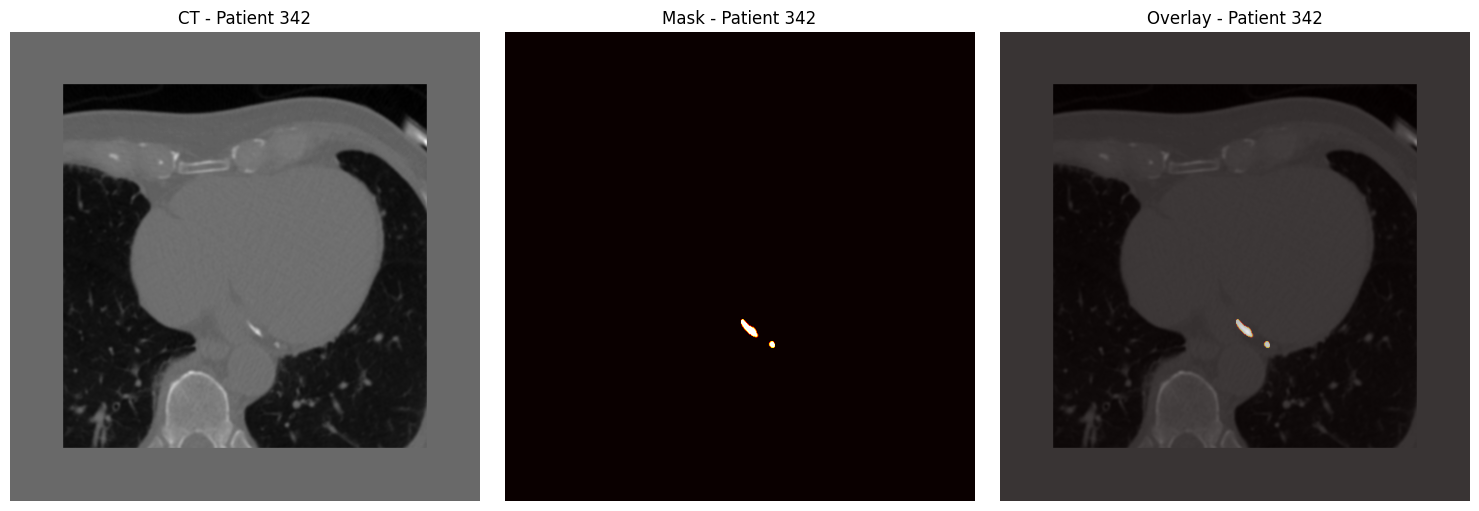

Patient 342 - CT shape: (60, 512, 512, 1), Mask shape: (60, 512, 512, 1)
CT value range: [-1024.00, 3062.00]
Mask value range: [0.00, 1.00]


In [1005]:
# Example usage
if __name__ == "__main__":
    # Set paths
    ct_base_path = "cocacoronarycalciumandchestcts-2/Gated_release_final"
    mask_base_path = "output_masks"
    
    # Create data generator
    data_gen = CTImageDataGenerator(
        ct_base_path=ct_base_path,
        mask_base_path=mask_base_path,
        batch_size=2,
        target_spacing=(0.5, 0.5, 3.0),
        target_dims=(512, 512, 60),
        normalization=False,
        augmentation=False,
        shuffle=False
    )
    
    # Visualize a random sample
    data_gen.visualize_sample(342, -25)
    

Found 449 patients with both CT and mask data


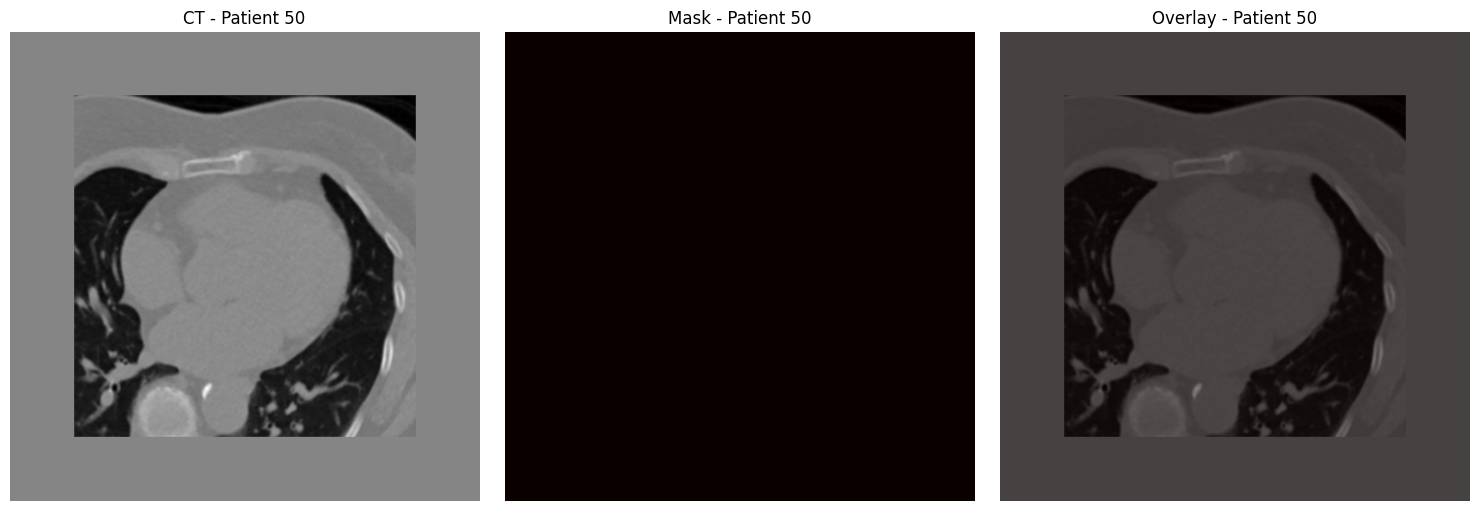

Patient 50 - CT shape: (60, 512, 512, 1), Mask shape: (60, 512, 512, 1)
CT value range: [-1024.00, 1474.00]
Mask value range: [0.00, 1.00]


In [1009]:
# Example usage
if __name__ == "__main__":
    # Set paths
    ct_base_path = "cocacoronarycalciumandchestcts-2/Gated_release_final"
    mask_base_path = "output_masks"
    
    # Create data generator
    data_gen = CTImageDataGenerator(
        ct_base_path=ct_base_path,
        mask_base_path=mask_base_path,
        batch_size=2,
        target_spacing=(0.5, 0.5, 3.0),
        target_dims=(512, 512, 60),
        normalization= False,
        augmentation=False,
        shuffle=False
    )
    
    # Visualize a random sample
    data_gen.visualize_sample(50, 25)
    

In [218]:
import plotly.graph_objects as go
H, W, D = volume.shape
fig = go.Figure()

X, Y, Z = np.mgrid[:H, :W, :D]

fig.add_trace(go.Volume(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=volume_norm.flatten(),
        opacity=0.2,
        surface_count=4,
        colorscale='Gray',
        name=f'CT',
        showscale=False))
fig.show()

In [987]:
# --- Step 1: Load all DICOM slices from a folder ---
def load_dicom_volume(folder_path):
    files = [f for f in os.listdir(folder_path) if f.lower().endswith('.dcm')]
    slices = []

    for fname in tqdm(files, desc="Loading DICOM slices"):
        path = os.path.join(folder_path, fname)
        ds = pydicom.dcmread(path)
        slices.append(ds)

    # Sort slices by InstanceNumber or SliceLocation
    slices.sort(key=lambda s: int(s.InstanceNumber))  # Fallback: use s.SliceLocation if needed

    # Extract pixel data and stack into 3D volume
    volume = np.stack([s.pixel_array for s in slices], axis=-1)  # shape: (H, W, D)

    # Convert to float32
    volume = volume.astype(np.float32)

    return volume, slices

# --- Step 2: Normalize for visualization ---
def normalize_volume(vol):
    vol = vol - np.min(vol)
    vol = vol / np.max(vol)
    return vol
folder_path = 'cocacoronarycalciumandchestcts-2/Gated_release_final/patient/5/Pro_Gated_CS_3.0_I30f_3_70%'  # Change this to your folder path
volume, slices = load_dicom_volume(folder_path)
volume_norm = normalize_volume(volume)


#load mask from another folder    
dicom_path = "output_masks/coronary_masks5.dcm" 
ds = pydicom.dcmread(dicom_path)


mask = ds.pixel_array  

mask = np.transpose(mask, (1, 2, 0)) 
print(mask.shape)
mask = np.flip(mask, axis=2)
mask = mask.astype(np.float32)
mask = mask - np.min(mask)
mask = mask / np.max(mask)

Loading DICOM slices: 100%|███████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 300.15it/s]


(512, 512, 57)


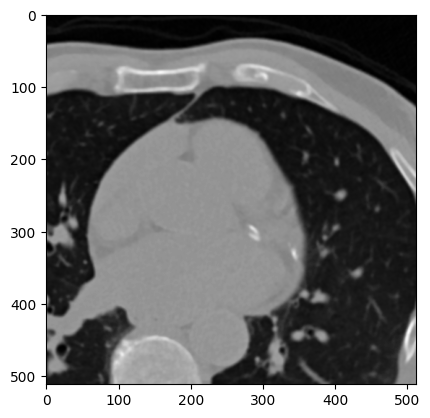

In [988]:

plt.imshow(volume[:,:,25],cmap = 'gray')

In [989]:
volume.mean()

674.6974

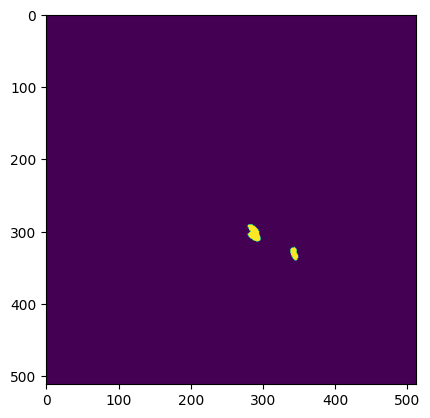

In [845]:
plt.imshow(mask[:,:,25])

# Latest Extractor

In [19]:
import tensorflow as tf
import numpy as np
import pydicom
import SimpleITK as sitk
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
import h5py

def find_available_patients(ct_base_path, mask_base_path):
    """Find all patient IDs that have both CT and mask data."""
    mask_files = glob.glob(os.path.join(mask_base_path, "coronary_masks*.dcm"))
    available_ids = []
    
    for mask_file in mask_files:
        try:
            # Extract patient ID from mask filename
            filename = os.path.basename(mask_file)
            patient_id = int(filename.replace("coronary_masks", "").replace(".dcm", ""))
            
            # Check if corresponding CT data exists
            patient_dir = os.path.join(ct_base_path, f"patient/{patient_id}")
            if os.path.exists(patient_dir):
                available_ids.append(patient_id)
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")
    
    return sorted(available_ids)

def find_ct_slices(ct_base_path, patient_id):
    """Find all CT DICOM files for a given patient."""
    patient_dir = os.path.join(ct_base_path, f"patient/{patient_id}")
    dicom_files = []
    
    # Recursively search for DICOM files
    for root, _, files in os.walk(patient_dir):
        for file in files:
            if file.lower().endswith('.dcm'):
                dicom_files.append(os.path.join(root, file))
    
    return sorted(dicom_files)

def load_patient_volume(ct_base_path, patient_id):
    """
    Load a patient's CT volume from DICOM files.
    
    Returns:
        Tuple of (volume, original_spacing, slice_locations)
    """
    dicom_files = find_ct_slices(ct_base_path, patient_id)
    
    if not dicom_files:
        raise ValueError(f"No DICOM files found for patient {patient_id}")
    
    # Load DICOM slices and extract slice locations
    slices = []
    slice_locations = []
    
    for dcm_file in dicom_files:
        try:
            ds = pydicom.dcmread(dcm_file)
            slices.append(ds)
            # Get slice location or instance number
            if hasattr(ds, 'SliceLocation'):
                slice_locations.append(float(ds.SliceLocation))
            else:
                slice_locations.append(float(ds.InstanceNumber))
        except Exception as e:
            print(f"Error reading {dcm_file}: {e}")
    
    # Sort slices by location
    slice_tuples = [(s, loc) for s, loc in zip(slices, slice_locations)]
    slice_tuples.sort(key=lambda x: x[1])
    slices = [s[0] for s in slice_tuples]
    
    # Get original spacing
    try:
        x_spacing, y_spacing = slices[0].PixelSpacing
        z_spacing = slices[0].SliceThickness
    except Exception:
        # Default if not found
        x_spacing, y_spacing, z_spacing = 1.0, 1.0, 1.0
    
    original_spacing = (float(x_spacing), float(y_spacing), float(z_spacing))
    
    # Create 3D volume
    img_shape = (slices[0].Rows, slices[0].Columns)
    volume = np.zeros((len(slices), img_shape[0], img_shape[1]), dtype=np.int16)
    
    for i, s in enumerate(slices):
        volume[i, :, :] = s.pixel_array
        
        # Apply rescale if available
        if hasattr(s, 'RescaleSlope') and hasattr(s, 'RescaleIntercept'):
            volume[i, :, :] = s.RescaleSlope * volume[i, :, :] + s.RescaleIntercept
    
    return volume, original_spacing

def load_mask_volume(mask_base_path, patient_id):
    """Load a patient's mask volume from the DICOM file."""
    mask_file = os.path.join(mask_base_path, f"coronary_masks{patient_id}.dcm")
    
    if not os.path.exists(mask_file):
        raise ValueError(f"Mask file not found: {mask_file}")
    
    ds = pydicom.dcmread(mask_file)
    
    # Get mask dimensions
    rows = ds.Rows
    cols = ds.Columns
    num_frames = ds.NumberOfFrames
    
    # Extract pixel data
    mask_volume = np.frombuffer(ds.PixelData, dtype=np.uint8)
    mask_volume = mask_volume.reshape(num_frames, rows, cols)
    mask_volume = np.flip(mask_volume, axis=0)
    # Normalize to binary (0-1)
    mask_volume = (mask_volume > 0).astype(np.float32)
    
    return mask_volume

def resample_volume(volume, original_spacing, target_spacing):
    """
    Resample volume to target spacing.
    
    Args:
        volume: 3D numpy array (z, y, x)
        original_spacing: Original voxel spacing (x, y, z) in mm
        target_spacing: Target voxel spacing (x, y, z) in mm
        
    Returns:
        Resampled volume as numpy array
    """
    # Convert to SimpleITK image
    sitk_image = sitk.GetImageFromArray(volume)
    sitk_image.SetSpacing(original_spacing)
    
    # Calculate new size
    original_size = sitk_image.GetSize()
    new_size = [
        int(np.round(original_size[0] * original_spacing[0] / target_spacing[0])),
        int(np.round(original_size[1] * original_spacing[1] / target_spacing[1])),
        int(np.round(original_size[2] * original_spacing[2] / target_spacing[2]))
    ]
    
    # For CT images, use linear interpolation
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputSpacing(target_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(sitk_image.GetDirection())
    resampler.SetOutputOrigin(sitk_image.GetOrigin())
    
    # Perform resampling
    resampled_image = resampler.Execute(sitk_image)
    
    # Convert back to numpy array
    resampled_volume = sitk.GetArrayFromImage(resampled_image)
    
    return resampled_volume

def pad_volume(volume, target_dims):
    """
    Pad or crop volume to target dimensions.
    
    Args:
        volume: 3D numpy array (z, y, x)
        target_dims: Target dimensions (x, y, z)
        
    Returns:
        Padded/cropped volume as numpy array
    """
    # Get current dimensions (z, y, x format in numpy)
    z_dim, y_dim, x_dim = volume.shape
    
    # Convert target dims to (z, y, x) format for numpy
    target_x, target_y, target_z = target_dims
    
    # Create output array of target size
    output_volume = np.zeros((target_z, target_y, target_x), dtype=volume.dtype)
    
    # Calculate how much to copy in each dimension
    z_to_copy = min(z_dim, target_z)
    y_to_copy = min(y_dim, target_y)
    x_to_copy = min(x_dim, target_x)
    
    # Calculate offsets for centering
    z_offset_src = max(0, (z_dim - target_z) // 2)
    y_offset_src = max(0, (y_dim - target_y) // 2)
    x_offset_src = max(0, (x_dim - target_x) // 2)
    
    z_offset_dst = max(0, (target_z - z_dim) // 2)
    y_offset_dst = max(0, (target_y - y_dim) // 2)
    x_offset_dst = max(0, (target_x - x_dim) // 2)
    
    # Copy data
    output_volume[
        z_offset_dst:z_offset_dst+z_to_copy,
        y_offset_dst:y_offset_dst+y_to_copy,
        x_offset_dst:x_offset_dst+x_to_copy
    ] = volume[
        z_offset_src:z_offset_src+z_to_copy,
        y_offset_src:y_offset_src+y_to_copy,
        x_offset_src:x_offset_src+x_to_copy
    ]
    
    return output_volume

def normalize_volume(volume, normalization='hounsfield'):
    """
    Normalize the CT volume based on the specified normalization method.
    
    Args:
        volume: CT volume array
        normalization: Normalization method
        
    Returns:
        Normalized volume
    """
    if normalization == 'hounsfield':
        min_hu = -1024
        max_hu = 2000
        volume = np.clip(volume, min_hu, max_hu)
        volume = (volume - min_hu) / (max_hu - min_hu)
    elif normalization == 'minmax':
        # Normalize each volume independently
        min_val = np.min(volume)
        max_val = np.max(volume)
        if max_val > min_val:
            volume = (volume - min_val) / (max_val - min_val)
        else:
            volume = np.zeros_like(volume)
    elif normalization == '0-1':
        # Simple [0, 1] normalization
        volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    elif normalization == False:
        return volume.astype(np.float32)
    else:
        raise ValueError(f"Unknown normalization method: {normalization}")
    
    return volume.astype(np.float32)

def process_and_save_patient(ct_base_path, mask_base_path, output_path, patient_id, 
                           target_spacing=(0.5, 0.5, 3.0), target_dims=(512, 512, 60), 
                           normalization='hounsfield'):
    """
    Process a patient's data and save it to disk.
    
    Args:
        ct_base_path: Path to CT data
        mask_base_path: Path to mask data
        output_path: Path to save preprocessed data
        patient_id: Patient ID
        target_spacing: Target voxel spacing
        target_dims: Target dimensions
        normalization: Normalization method
    """
    try:
        # Create output directory if it doesn't exist
        os.makedirs(output_path, exist_ok=True)
        
        # Define output file path
        output_file = os.path.join(output_path, f"patient_{patient_id}.h5")
        
        # Skip if already processed
        if os.path.exists(output_file):
            print(f"Patient {patient_id} already processed, skipping...")
            return True
        
        # Load CT volume and mask
        ct_volume, original_spacing = load_patient_volume(ct_base_path, patient_id)
        mask_volume = load_mask_volume(mask_base_path, patient_id)
        
        # Resample to target spacing
        resampled_ct = resample_volume(ct_volume, original_spacing, target_spacing)
        resampled_mask = resample_volume(mask_volume, original_spacing, target_spacing)
        
        # Pad/crop to target dimensions
        padded_ct = pad_volume(resampled_ct, target_dims)
        padded_mask = pad_volume(resampled_mask, target_dims)
        
        # Normalize CT values
        normalized_ct = normalize_volume(padded_ct, normalization)
        
        # Add channel dimension
        normalized_ct = np.expand_dims(normalized_ct, axis=-1)
        padded_mask = np.expand_dims(padded_mask, axis=-1)
        
        # Save processed data as HDF5 file
        with h5py.File(output_file, 'w') as f:
            f.create_dataset('ct', data=normalized_ct, compression='gzip', compression_opts=6)
            f.create_dataset('mask', data=padded_mask, compression='gzip', compression_opts=6)
            
            # Save metadata
            f.attrs['patient_id'] = patient_id
            f.attrs['original_spacing'] = original_spacing
            f.attrs['target_spacing'] = target_spacing
            f.attrs['normalization'] = normalization
        
        print(f"Successfully processed patient {patient_id}")
        return True
        
    except Exception as e:
        print(f"Error processing patient {patient_id}: {e}")
        return False

def visualize_processed_data(output_path, patient_id, slice_idx=None):
    """
    Visualize processed data for a patient.
    
    Args:
        output_path: Path to processed data
        patient_id: Patient ID
        slice_idx: Slice index to visualize, middle slice if None
    """
    output_file = os.path.join(output_path, f"patient_{patient_id}.h5")
    
    if not os.path.exists(output_file):
        print(f"Processed data for patient {patient_id} not found")
        return
    
    with h5py.File(output_file, 'r') as f:
        ct = f['ct'][:]
        mask = f['mask'][:]
    
    # Select slice to visualize
    if slice_idx is None:
        slice_idx = ct.shape[0] // 2  # Middle slice
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot CT
    axes[0].imshow(ct[slice_idx, :, :, 0], cmap='gray')
    axes[0].set_title(f"CT - Patient {patient_id}")
    axes[0].axis('off')
    
    # Plot mask
    axes[1].imshow(mask[slice_idx, :, :, 0], cmap='hot')
    axes[1].set_title(f"Mask - Patient {patient_id}")
    axes[1].axis('off')
    
    # Plot overlay
    axes[2].imshow(ct[slice_idx, :, :, 0], cmap='gray')
    axes[2].imshow(mask[slice_idx, :, :, 0], cmap='hot', alpha=0.5)
    axes[2].set_title(f"Overlay - Patient {patient_id}")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"CT shape: {ct.shape}, Mask shape: {mask.shape}")
    print(f"CT value range: [{np.min(ct):.2f}, {np.max(ct):.2f}]")
    print(f"Mask value range: [{np.min(mask):.2f}, {np.max(mask):.2f}]")

def main():
    # parser = argparse.ArgumentParser(description='Preprocess CT and mask data')
    # parser.add_argument('--ct_path', type=str, required=True, help='Path to CT data')
    # parser.add_argument('--mask_path', type=str, required=True, help='Path to mask data')
    # parser.add_argument('--output_path', type=str, required=True, help='Path to save preprocessed data')
    # parser.add_argument('--target_x', type=float, default=0.5, help='Target voxel spacing in x direction (mm)')
    # parser.add_argument('--target_y', type=float, default=0.5, help='Target voxel spacing in y direction (mm)')
    # parser.add_argument('--target_z', type=float, default=3.0, help='Target voxel spacing in z direction (mm)')
    # parser.add_argument('--dim_x', type=int, default=512, help='Target dimension in x direction')
    # parser.add_argument('--dim_y', type=int, default=512, help='Target dimension in y direction')
    # parser.add_argument('--dim_z', type=int, default=60, help='Target dimension in z direction')
    # parser.add_argument('--normalization', type=str, default='hounsfield', choices=['hounsfield', 'minmax', '0-1', 'none'], 
    #                    help='Normalization method')
    # parser.add_argument('--patient_id', type=int, default=None, help='Process specific patient (optional)')
    # parser.add_argument('--visualize', action='store_true', help='Visualize processed data')
    
    # args = parser.parse_args()
    ct_path ='/home/cds/Documents/Adithya/CAC/cocacoronarycalciumandchestcts-2/Gated_release_final'
    mask_path = '/home/cds/Documents/Adithya/CAC/output_masks'
    output_path = '/home/cds/Documents/Adithya/CAC/ProcessedData256'
    target_x=0.5
    target_y=0.5
    target_z=3
    dim_x = 256
    dim_y = 256
    dim_z = 32
    normalization = False
    patient_id = None
    visualize = False
    target_spacing = (target_x, target_y, target_z)
    target_dims = (dim_x, dim_y, dim_z)
    
    # Process single patient if specified
    if patient_id is not None:
        success = process_and_save_patient(
            ct_path, mask_path, output_path, patient_id,
            target_spacing, target_dims, normalization
        )
        
        if success and args.visualize:
            visualize_processed_data(output_path, patient_id)
            
    # Otherwise process all available patients
    else:
        patient_ids = find_available_patients(ct_path, mask_path)
        print(f"Found {len(patient_ids)} patients with both CT and mask data")
        
        successful = 0
        for patient_id in tqdm(patient_ids, desc="Processing patients"):
            if process_and_save_patient(
                ct_path, mask_path, output_path, patient_id,
                target_spacing, target_dims, normalization
            ):
                successful += 1
                
                # Visualize first successful patient if requested
                if visualize and successful == 1:
                    visualize_processed_data(output_path, patient_id)
        
        print(f"Successfully processed {successful}/{len(patient_ids)} patients")

if __name__ == "__main__":
    main()

Found 449 patients with both CT and mask data


Processing patients:   0%|          | 0/449 [00:00<?, ?it/s]

/home/cds/anaconda3/envs/tf_env/lib/python3.9/site-packages/pydicom/filereader.py:353: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(msg + f" - using {found_vr} VR for reading", UserWarning)
Processing patients:   0%|          | 1/449 [00:00<06:40,  1.12it/s]

Successfully processed patient 0


Processing patients:   0%|          | 2/449 [00:02<07:45,  1.04s/it]

Successfully processed patient 1


Processing patients:   1%|          | 3/449 [00:02<07:17,  1.02it/s]

Successfully processed patient 2


Processing patients:   1%|          | 4/449 [00:03<07:24,  1.00it/s]

Successfully processed patient 3


Processing patients:   1%|          | 5/449 [00:04<07:11,  1.03it/s]

Successfully processed patient 4


Processing patients:   1%|▏         | 6/449 [00:05<07:13,  1.02it/s]

Successfully processed patient 5


Processing patients:   2%|▏         | 7/449 [00:06<07:03,  1.04it/s]

Successfully processed patient 6


Processing patients:   2%|▏         | 8/449 [00:07<06:55,  1.06it/s]

Successfully processed patient 7


Processing patients:   2%|▏         | 9/449 [00:08<06:50,  1.07it/s]

Successfully processed patient 8


Processing patients:   2%|▏         | 10/449 [00:09<06:55,  1.06it/s]

Successfully processed patient 9


Processing patients:   2%|▏         | 11/449 [00:10<06:52,  1.06it/s]

Successfully processed patient 10


Processing patients:   3%|▎         | 12/449 [00:11<06:55,  1.05it/s]

Successfully processed patient 11


Processing patients:   3%|▎         | 13/449 [00:12<06:50,  1.06it/s]

Successfully processed patient 13


Processing patients:   3%|▎         | 14/449 [00:13<06:51,  1.06it/s]

Successfully processed patient 14


Processing patients:   3%|▎         | 15/449 [00:14<06:49,  1.06it/s]

Successfully processed patient 15


Processing patients:   4%|▎         | 16/449 [00:15<06:47,  1.06it/s]

Successfully processed patient 16


Processing patients:   4%|▍         | 17/449 [00:16<06:55,  1.04it/s]

Successfully processed patient 17


Processing patients:   4%|▍         | 18/449 [00:17<06:47,  1.06it/s]

Successfully processed patient 18


Processing patients:   4%|▍         | 19/449 [00:18<06:57,  1.03it/s]

Successfully processed patient 19


Processing patients:   4%|▍         | 20/449 [00:19<06:54,  1.04it/s]

Successfully processed patient 20


Processing patients:   5%|▍         | 21/449 [00:20<06:46,  1.05it/s]

Successfully processed patient 21


Processing patients:   5%|▍         | 22/449 [00:21<06:45,  1.05it/s]

Successfully processed patient 22


Processing patients:   5%|▌         | 23/449 [00:21<06:42,  1.06it/s]

Successfully processed patient 23


Processing patients:   5%|▌         | 24/449 [00:22<06:42,  1.06it/s]

Successfully processed patient 24


Processing patients:   6%|▌         | 25/449 [00:23<06:42,  1.05it/s]

Successfully processed patient 25


Processing patients:   6%|▌         | 26/449 [00:24<06:36,  1.07it/s]

Successfully processed patient 26


Processing patients:   6%|▌         | 27/449 [00:25<06:40,  1.05it/s]

Successfully processed patient 27


Processing patients:   6%|▌         | 28/449 [00:27<07:18,  1.04s/it]

Successfully processed patient 28


Processing patients:   6%|▋         | 29/449 [00:27<07:07,  1.02s/it]

Successfully processed patient 29


Processing patients:   7%|▋         | 30/449 [00:28<07:00,  1.00s/it]

Successfully processed patient 30


Processing patients:   7%|▋         | 31/449 [00:29<06:42,  1.04it/s]

Successfully processed patient 31


Processing patients:   7%|▋         | 32/449 [00:30<06:52,  1.01it/s]

Successfully processed patient 32


Processing patients:   7%|▋         | 33/449 [00:32<07:45,  1.12s/it]

Successfully processed patient 33


Processing patients:   8%|▊         | 34/449 [00:33<07:16,  1.05s/it]

Successfully processed patient 34


Processing patients:   8%|▊         | 35/449 [00:34<07:10,  1.04s/it]

Successfully processed patient 35


Processing patients:   8%|▊         | 36/449 [00:35<06:46,  1.01it/s]

Successfully processed patient 36


Processing patients:   8%|▊         | 37/449 [00:36<06:46,  1.01it/s]

Successfully processed patient 37


Processing patients:   8%|▊         | 38/449 [00:36<06:39,  1.03it/s]

Successfully processed patient 38


Processing patients:   9%|▊         | 39/449 [00:37<06:38,  1.03it/s]

Successfully processed patient 39


Processing patients:   9%|▉         | 40/449 [00:38<06:41,  1.02it/s]

Successfully processed patient 40


Processing patients:   9%|▉         | 41/449 [00:39<06:39,  1.02it/s]

Successfully processed patient 41


Processing patients:   9%|▉         | 42/449 [00:40<06:38,  1.02it/s]

Successfully processed patient 42


Processing patients:  10%|▉         | 43/449 [00:41<06:26,  1.05it/s]

Successfully processed patient 43


Processing patients:  10%|▉         | 44/449 [00:42<06:33,  1.03it/s]

Successfully processed patient 44


Processing patients:  10%|█         | 45/449 [00:43<06:24,  1.05it/s]

Successfully processed patient 45


Processing patients:  10%|█         | 46/449 [00:44<06:17,  1.07it/s]

Successfully processed patient 46


Processing patients:  10%|█         | 47/449 [00:45<06:12,  1.08it/s]

Successfully processed patient 47


Processing patients:  11%|█         | 48/449 [00:46<06:14,  1.07it/s]

Successfully processed patient 48


Processing patients:  11%|█         | 49/449 [00:47<06:19,  1.05it/s]

Successfully processed patient 49


Processing patients:  11%|█         | 50/449 [00:48<06:14,  1.07it/s]

Successfully processed patient 50


Processing patients:  11%|█▏        | 51/449 [00:49<06:09,  1.08it/s]

Successfully processed patient 51


Processing patients:  12%|█▏        | 52/449 [00:50<06:04,  1.09it/s]

Successfully processed patient 52


Processing patients:  12%|█▏        | 53/449 [00:51<06:17,  1.05it/s]

Successfully processed patient 53


Processing patients:  12%|█▏        | 54/449 [00:52<06:15,  1.05it/s]

Successfully processed patient 54


Processing patients:  12%|█▏        | 55/449 [00:53<06:10,  1.06it/s]

Successfully processed patient 55


Processing patients:  12%|█▏        | 56/449 [00:53<06:05,  1.08it/s]

Successfully processed patient 56


Processing patients:  13%|█▎        | 57/449 [00:54<06:07,  1.07it/s]

Successfully processed patient 57


Processing patients:  13%|█▎        | 58/449 [00:56<06:28,  1.01it/s]

Successfully processed patient 58


Processing patients:  13%|█▎        | 59/449 [00:56<06:21,  1.02it/s]

Successfully processed patient 59


Processing patients:  13%|█▎        | 60/449 [00:57<06:18,  1.03it/s]

Successfully processed patient 60


Processing patients:  14%|█▎        | 61/449 [00:59<06:34,  1.02s/it]

Successfully processed patient 61


Processing patients:  14%|█▍        | 62/449 [01:00<06:31,  1.01s/it]

Successfully processed patient 62


Processing patients:  14%|█▍        | 63/449 [01:00<06:19,  1.02it/s]

Successfully processed patient 63


Processing patients:  14%|█▍        | 64/449 [01:01<06:12,  1.03it/s]

Successfully processed patient 64


Processing patients:  14%|█▍        | 65/449 [01:02<06:09,  1.04it/s]

Successfully processed patient 65


Processing patients:  15%|█▍        | 66/449 [01:03<06:09,  1.04it/s]

Successfully processed patient 66


Processing patients:  15%|█▍        | 67/449 [01:04<06:12,  1.03it/s]

Successfully processed patient 67


Processing patients:  15%|█▌        | 68/449 [01:05<06:16,  1.01it/s]

Successfully processed patient 68


Processing patients:  15%|█▌        | 69/449 [01:06<06:05,  1.04it/s]

Successfully processed patient 69


Processing patients:  16%|█▌        | 70/449 [01:07<05:58,  1.06it/s]

Successfully processed patient 70


Processing patients:  16%|█▌        | 71/449 [01:08<05:58,  1.05it/s]

Successfully processed patient 71


Processing patients:  16%|█▌        | 72/449 [01:09<06:10,  1.02it/s]

Successfully processed patient 72


Processing patients:  16%|█▋        | 73/449 [01:10<06:09,  1.02it/s]

Successfully processed patient 73


Processing patients:  16%|█▋        | 74/449 [01:11<06:01,  1.04it/s]

Successfully processed patient 74


Processing patients:  17%|█▋        | 75/449 [01:12<05:55,  1.05it/s]

Successfully processed patient 75


Processing patients:  17%|█▋        | 76/449 [01:13<06:01,  1.03it/s]

Successfully processed patient 76


Processing patients:  17%|█▋        | 77/449 [01:14<06:09,  1.01it/s]

Successfully processed patient 77


Processing patients:  17%|█▋        | 78/449 [01:15<06:12,  1.00s/it]

Successfully processed patient 78


Processing patients:  18%|█▊        | 79/449 [01:16<06:06,  1.01it/s]

Successfully processed patient 79


Processing patients:  18%|█▊        | 80/449 [01:17<05:54,  1.04it/s]

Successfully processed patient 80


Processing patients:  18%|█▊        | 81/449 [01:18<05:47,  1.06it/s]

Successfully processed patient 81


Processing patients:  18%|█▊        | 82/449 [01:19<05:46,  1.06it/s]

Successfully processed patient 82


Processing patients:  18%|█▊        | 83/449 [01:20<05:40,  1.07it/s]

Successfully processed patient 83


Processing patients:  19%|█▊        | 84/449 [01:21<05:35,  1.09it/s]

Successfully processed patient 84


Processing patients:  19%|█▉        | 85/449 [01:22<05:41,  1.06it/s]

Successfully processed patient 85


Processing patients:  19%|█▉        | 86/449 [01:23<05:46,  1.05it/s]

Successfully processed patient 86


Processing patients:  19%|█▉        | 87/449 [01:24<05:52,  1.03it/s]

Successfully processed patient 87


Processing patients:  20%|█▉        | 88/449 [01:25<05:59,  1.00it/s]

Successfully processed patient 88


Processing patients:  20%|█▉        | 89/449 [01:26<05:51,  1.03it/s]

Successfully processed patient 89


Processing patients:  20%|██        | 90/449 [01:27<05:56,  1.01it/s]

Successfully processed patient 90


Processing patients:  20%|██        | 91/449 [01:28<05:51,  1.02it/s]

Successfully processed patient 91


Processing patients:  20%|██        | 92/449 [01:29<05:51,  1.02it/s]

Successfully processed patient 92


Processing patients:  21%|██        | 93/449 [01:29<05:41,  1.04it/s]

Successfully processed patient 93


Processing patients:  21%|██        | 94/449 [01:30<05:37,  1.05it/s]

Successfully processed patient 94


Processing patients:  21%|██        | 95/449 [01:31<05:32,  1.06it/s]

Successfully processed patient 95


Processing patients:  21%|██▏       | 96/449 [01:32<05:29,  1.07it/s]

Successfully processed patient 96


Processing patients:  22%|██▏       | 97/449 [01:33<05:34,  1.05it/s]

Successfully processed patient 97


Processing patients:  22%|██▏       | 98/449 [01:34<05:37,  1.04it/s]

Successfully processed patient 98


Processing patients:  22%|██▏       | 99/449 [01:35<05:41,  1.02it/s]

Successfully processed patient 99


Processing patients:  22%|██▏       | 100/449 [01:36<05:35,  1.04it/s]

Successfully processed patient 100


Processing patients:  22%|██▏       | 101/449 [01:37<05:30,  1.05it/s]

Successfully processed patient 101


Processing patients:  23%|██▎       | 102/449 [01:38<05:28,  1.06it/s]

Successfully processed patient 102


Processing patients:  23%|██▎       | 103/449 [01:39<05:31,  1.04it/s]

Successfully processed patient 103


Processing patients:  23%|██▎       | 104/449 [01:40<05:34,  1.03it/s]

Successfully processed patient 104


Processing patients:  23%|██▎       | 105/449 [01:41<05:28,  1.05it/s]

Successfully processed patient 105


Processing patients:  24%|██▎       | 106/449 [01:42<05:22,  1.06it/s]

Successfully processed patient 106


Processing patients:  24%|██▍       | 107/449 [01:43<05:24,  1.05it/s]

Successfully processed patient 107


Processing patients:  24%|██▍       | 108/449 [01:44<05:29,  1.03it/s]

Successfully processed patient 108


Processing patients:  24%|██▍       | 109/449 [01:45<05:22,  1.05it/s]

Successfully processed patient 109


Processing patients:  24%|██▍       | 110/449 [01:46<05:20,  1.06it/s]

Successfully processed patient 110


Processing patients:  25%|██▍       | 111/449 [01:47<05:14,  1.07it/s]

Successfully processed patient 111


Processing patients:  25%|██▍       | 112/449 [01:47<05:17,  1.06it/s]

Successfully processed patient 112


Processing patients:  25%|██▌       | 113/449 [01:48<05:19,  1.05it/s]

Successfully processed patient 113


Processing patients:  25%|██▌       | 114/449 [01:49<05:20,  1.04it/s]

Successfully processed patient 114


Processing patients:  26%|██▌       | 115/449 [01:50<05:24,  1.03it/s]

Successfully processed patient 115


Processing patients:  26%|██▌       | 116/449 [01:51<05:17,  1.05it/s]

Successfully processed patient 116


Processing patients:  26%|██▌       | 117/449 [01:52<05:12,  1.06it/s]

Successfully processed patient 117


Processing patients:  26%|██▋       | 118/449 [01:53<05:15,  1.05it/s]

Successfully processed patient 118


Processing patients:  27%|██▋       | 119/449 [01:54<05:08,  1.07it/s]

Successfully processed patient 119


Processing patients:  27%|██▋       | 120/449 [01:55<05:27,  1.00it/s]

Successfully processed patient 120


Processing patients:  27%|██▋       | 121/449 [01:56<05:21,  1.02it/s]

Successfully processed patient 121


Processing patients:  27%|██▋       | 122/449 [01:57<05:18,  1.03it/s]

Successfully processed patient 122


Processing patients:  27%|██▋       | 123/449 [01:58<05:14,  1.04it/s]

Successfully processed patient 123


Processing patients:  28%|██▊       | 124/449 [01:59<05:07,  1.06it/s]

Successfully processed patient 124


Processing patients:  28%|██▊       | 125/449 [02:00<05:04,  1.06it/s]

Successfully processed patient 125


Processing patients:  28%|██▊       | 126/449 [02:01<05:04,  1.06it/s]

Successfully processed patient 126


Processing patients:  28%|██▊       | 127/449 [02:02<05:05,  1.05it/s]

Successfully processed patient 127


Processing patients:  29%|██▊       | 128/449 [02:03<05:05,  1.05it/s]

Successfully processed patient 128


Processing patients:  29%|██▊       | 129/449 [02:04<04:56,  1.08it/s]

Successfully processed patient 129


Processing patients:  29%|██▉       | 130/449 [02:05<04:54,  1.08it/s]

Successfully processed patient 130


Processing patients:  29%|██▉       | 131/449 [02:06<05:01,  1.05it/s]

Successfully processed patient 131


Processing patients:  29%|██▉       | 132/449 [02:07<05:01,  1.05it/s]

Successfully processed patient 132


Processing patients:  30%|██▉       | 133/449 [02:08<05:01,  1.05it/s]

Successfully processed patient 133


Processing patients:  30%|██▉       | 134/449 [02:08<04:59,  1.05it/s]

Successfully processed patient 134


Processing patients:  30%|███       | 135/449 [02:09<04:52,  1.07it/s]

Successfully processed patient 135


Processing patients:  30%|███       | 136/449 [02:10<04:45,  1.10it/s]

Successfully processed patient 136


Processing patients:  31%|███       | 137/449 [02:11<04:44,  1.10it/s]

Successfully processed patient 137


Processing patients:  31%|███       | 138/449 [02:12<04:49,  1.08it/s]

Successfully processed patient 138


Processing patients:  31%|███       | 139/449 [02:13<04:41,  1.10it/s]

Successfully processed patient 139


Processing patients:  31%|███       | 140/449 [02:14<04:48,  1.07it/s]

Successfully processed patient 140


Processing patients:  31%|███▏      | 141/449 [02:15<04:44,  1.08it/s]

Successfully processed patient 141


Processing patients:  32%|███▏      | 142/449 [02:16<04:42,  1.09it/s]

Successfully processed patient 142


Processing patients:  32%|███▏      | 143/449 [02:17<04:30,  1.13it/s]

Successfully processed patient 143


Processing patients:  32%|███▏      | 144/449 [02:17<04:20,  1.17it/s]

Successfully processed patient 144


Processing patients:  32%|███▏      | 145/449 [02:18<04:26,  1.14it/s]

Successfully processed patient 145


Processing patients:  33%|███▎      | 146/449 [02:20<04:59,  1.01it/s]

Successfully processed patient 146


Processing patients:  33%|███▎      | 147/449 [02:20<04:36,  1.09it/s]

Successfully processed patient 147


Processing patients:  33%|███▎      | 148/449 [02:21<04:25,  1.13it/s]

Successfully processed patient 148


Processing patients:  33%|███▎      | 149/449 [02:22<04:18,  1.16it/s]

Successfully processed patient 149


Processing patients:  33%|███▎      | 150/449 [02:23<04:08,  1.20it/s]

Successfully processed patient 150


Processing patients:  34%|███▎      | 151/449 [02:23<04:02,  1.23it/s]

Successfully processed patient 151


Processing patients:  34%|███▍      | 152/449 [02:24<03:56,  1.25it/s]

Successfully processed patient 152


Processing patients:  34%|███▍      | 153/449 [02:25<03:50,  1.28it/s]

Successfully processed patient 153


Processing patients:  34%|███▍      | 154/449 [02:26<03:52,  1.27it/s]

Successfully processed patient 154


Processing patients:  35%|███▍      | 155/449 [02:27<04:01,  1.22it/s]

Successfully processed patient 155


Processing patients:  35%|███▍      | 156/449 [02:28<04:21,  1.12it/s]

Successfully processed patient 156


Processing patients:  35%|███▍      | 157/449 [02:28<04:12,  1.16it/s]

Successfully processed patient 157


Processing patients:  35%|███▌      | 158/449 [02:29<04:06,  1.18it/s]

Successfully processed patient 158
Error reading /home/cds/Documents/Adithya/CAC/cocacoronarycalciumandchestcts-2/Gated_release_final/patient/159/Pro_Gated_Calcium_Score_(CS)_3.0_Qr36_2_BestDiast_71_%/IM-3255-0021.dcm: 'FileDataset' object has no attribute 'InstanceNumber'
Error processing patient 159: Unable to convert the pixel data: one of Pixel Data, Float Pixel Data or Double Float Pixel Data must be present in the dataset


Processing patients:  36%|███▌      | 160/449 [02:30<03:05,  1.55it/s]

Successfully processed patient 160


Processing patients:  36%|███▌      | 161/449 [02:31<03:14,  1.48it/s]

Successfully processed patient 161


Processing patients:  36%|███▌      | 162/449 [02:32<03:22,  1.42it/s]

Successfully processed patient 162


Processing patients:  36%|███▋      | 163/449 [02:32<03:28,  1.37it/s]

Successfully processed patient 163


Processing patients:  37%|███▋      | 164/449 [02:33<03:33,  1.34it/s]

Successfully processed patient 164


Processing patients:  37%|███▋      | 165/449 [02:34<03:47,  1.25it/s]

Successfully processed patient 165


Processing patients:  37%|███▋      | 166/449 [02:35<03:42,  1.27it/s]

Successfully processed patient 166


Processing patients:  37%|███▋      | 167/449 [02:36<03:35,  1.31it/s]

Successfully processed patient 167


Processing patients:  37%|███▋      | 168/449 [02:36<03:31,  1.33it/s]

Successfully processed patient 168


Processing patients:  38%|███▊      | 169/449 [02:37<03:42,  1.26it/s]

Successfully processed patient 169


Processing patients:  38%|███▊      | 170/449 [02:38<03:38,  1.28it/s]

Successfully processed patient 170


Processing patients:  38%|███▊      | 171/449 [02:39<03:37,  1.28it/s]

Successfully processed patient 171


Processing patients:  38%|███▊      | 172/449 [02:40<03:35,  1.29it/s]

Successfully processed patient 172


Processing patients:  39%|███▊      | 173/449 [02:40<03:33,  1.29it/s]

Successfully processed patient 173


Processing patients:  39%|███▉      | 174/449 [02:41<03:31,  1.30it/s]

Successfully processed patient 174


Processing patients:  39%|███▉      | 175/449 [02:42<03:30,  1.30it/s]

Successfully processed patient 175


Processing patients:  39%|███▉      | 176/449 [02:43<03:28,  1.31it/s]

Successfully processed patient 176


Processing patients:  39%|███▉      | 177/449 [02:43<03:32,  1.28it/s]

Successfully processed patient 177


Processing patients:  40%|███▉      | 178/449 [02:44<03:30,  1.29it/s]

Successfully processed patient 178


Processing patients:  40%|███▉      | 179/449 [02:45<03:34,  1.26it/s]

Successfully processed patient 179


Processing patients:  40%|████      | 180/449 [02:46<03:34,  1.26it/s]

Successfully processed patient 180


Processing patients:  40%|████      | 181/449 [02:47<03:36,  1.24it/s]

Successfully processed patient 181


Processing patients:  41%|████      | 182/449 [02:47<03:32,  1.26it/s]

Successfully processed patient 182


Processing patients:  41%|████      | 183/449 [02:48<03:30,  1.27it/s]

Successfully processed patient 183


Processing patients:  41%|████      | 184/449 [02:49<04:02,  1.09it/s]

Successfully processed patient 184


Processing patients:  41%|████      | 185/449 [02:50<03:49,  1.15it/s]

Successfully processed patient 185


Processing patients:  41%|████▏     | 186/449 [02:51<03:44,  1.17it/s]

Successfully processed patient 186


Processing patients:  42%|████▏     | 187/449 [02:52<03:38,  1.20it/s]

Successfully processed patient 187


Processing patients:  42%|████▏     | 188/449 [02:53<03:36,  1.20it/s]

Successfully processed patient 188


Processing patients:  42%|████▏     | 189/449 [02:54<03:48,  1.14it/s]

Successfully processed patient 189


Processing patients:  42%|████▏     | 190/449 [02:54<03:37,  1.19it/s]

Successfully processed patient 190


Processing patients:  43%|████▎     | 191/449 [02:55<03:32,  1.21it/s]

Successfully processed patient 191


Processing patients:  43%|████▎     | 192/449 [02:56<03:45,  1.14it/s]

Successfully processed patient 192


Processing patients:  43%|████▎     | 193/449 [02:57<03:46,  1.13it/s]

Successfully processed patient 193


Processing patients:  43%|████▎     | 194/449 [02:58<03:49,  1.11it/s]

Successfully processed patient 194


Processing patients:  43%|████▎     | 195/449 [02:59<03:37,  1.17it/s]

Successfully processed patient 195


Processing patients:  44%|████▎     | 196/449 [03:00<03:35,  1.18it/s]

Successfully processed patient 196


Processing patients:  44%|████▍     | 197/449 [03:00<03:30,  1.20it/s]

Successfully processed patient 198


Processing patients:  44%|████▍     | 198/449 [03:01<03:27,  1.21it/s]

Successfully processed patient 199


Processing patients:  44%|████▍     | 199/449 [03:02<03:22,  1.23it/s]

Successfully processed patient 200


Processing patients:  45%|████▍     | 200/449 [03:03<03:18,  1.26it/s]

Successfully processed patient 201


Processing patients:  45%|████▍     | 201/449 [03:03<03:13,  1.28it/s]

Successfully processed patient 202


Processing patients:  45%|████▍     | 202/449 [03:04<03:13,  1.27it/s]

Successfully processed patient 203


Processing patients:  45%|████▌     | 203/449 [03:05<03:13,  1.27it/s]

Successfully processed patient 204


Processing patients:  45%|████▌     | 204/449 [03:06<03:17,  1.24it/s]

Successfully processed patient 205


Processing patients:  46%|████▌     | 205/449 [03:07<03:14,  1.26it/s]

Successfully processed patient 206


Processing patients:  46%|████▌     | 206/449 [03:08<03:21,  1.20it/s]

Successfully processed patient 207


Processing patients:  46%|████▌     | 207/449 [03:08<03:18,  1.22it/s]

Successfully processed patient 208


Processing patients:  46%|████▋     | 208/449 [03:09<03:13,  1.24it/s]

Successfully processed patient 209


Processing patients:  47%|████▋     | 209/449 [03:10<03:08,  1.27it/s]

Successfully processed patient 210


Processing patients:  47%|████▋     | 210/449 [03:11<03:12,  1.24it/s]

Successfully processed patient 211


Processing patients:  47%|████▋     | 211/449 [03:12<03:11,  1.25it/s]

Successfully processed patient 212


Processing patients:  47%|████▋     | 212/449 [03:12<03:08,  1.26it/s]

Successfully processed patient 213


Processing patients:  47%|████▋     | 213/449 [03:13<03:10,  1.24it/s]

Successfully processed patient 214


Processing patients:  48%|████▊     | 214/449 [03:14<03:09,  1.24it/s]

Successfully processed patient 215


Processing patients:  48%|████▊     | 215/449 [03:15<03:06,  1.26it/s]

Successfully processed patient 216


Processing patients:  48%|████▊     | 216/449 [03:15<03:04,  1.26it/s]

Successfully processed patient 217


Processing patients:  48%|████▊     | 217/449 [03:16<03:06,  1.24it/s]

Successfully processed patient 218


Processing patients:  49%|████▊     | 218/449 [03:17<03:05,  1.25it/s]

Successfully processed patient 219


Processing patients:  49%|████▉     | 219/449 [03:18<03:05,  1.24it/s]

Successfully processed patient 220


Processing patients:  49%|████▉     | 220/449 [03:19<03:15,  1.17it/s]

Successfully processed patient 221


Processing patients:  49%|████▉     | 221/449 [03:20<03:04,  1.23it/s]

Successfully processed patient 222


Processing patients:  49%|████▉     | 222/449 [03:20<03:01,  1.25it/s]

Successfully processed patient 223


Processing patients:  50%|████▉     | 223/449 [03:21<02:58,  1.26it/s]

Successfully processed patient 224


Processing patients:  50%|████▉     | 224/449 [03:22<02:59,  1.25it/s]

Successfully processed patient 225


Processing patients:  50%|█████     | 225/449 [03:23<02:53,  1.29it/s]

Successfully processed patient 226


Processing patients:  50%|█████     | 226/449 [03:24<02:54,  1.28it/s]

Successfully processed patient 227


Processing patients:  51%|█████     | 227/449 [03:24<03:01,  1.22it/s]

Successfully processed patient 228


Processing patients:  51%|█████     | 228/449 [03:25<02:57,  1.24it/s]

Successfully processed patient 229


Processing patients:  51%|█████     | 229/449 [03:26<02:53,  1.26it/s]

Successfully processed patient 230


Processing patients:  51%|█████     | 230/449 [03:27<02:54,  1.25it/s]

Successfully processed patient 231


Processing patients:  51%|█████▏    | 231/449 [03:27<02:49,  1.29it/s]

Successfully processed patient 232


Processing patients:  52%|█████▏    | 232/449 [03:28<02:48,  1.29it/s]

Successfully processed patient 233


Processing patients:  52%|█████▏    | 233/449 [03:29<02:50,  1.27it/s]

Successfully processed patient 234


Processing patients:  52%|█████▏    | 234/449 [03:30<02:52,  1.24it/s]

Successfully processed patient 235


Processing patients:  52%|█████▏    | 235/449 [03:31<02:52,  1.24it/s]

Successfully processed patient 236


Processing patients:  53%|█████▎    | 236/449 [03:32<02:54,  1.22it/s]

Successfully processed patient 237


Processing patients:  53%|█████▎    | 237/449 [03:32<02:50,  1.24it/s]

Successfully processed patient 238


Processing patients:  53%|█████▎    | 238/449 [03:33<02:49,  1.24it/s]

Successfully processed patient 239


Processing patients:  53%|█████▎    | 239/449 [03:34<02:49,  1.24it/s]

Successfully processed patient 240


Processing patients:  53%|█████▎    | 240/449 [03:35<02:47,  1.25it/s]

Successfully processed patient 241


Processing patients:  54%|█████▎    | 241/449 [03:36<02:49,  1.23it/s]

Successfully processed patient 242


Processing patients:  54%|█████▍    | 242/449 [03:36<02:45,  1.25it/s]

Successfully processed patient 243


Processing patients:  54%|█████▍    | 243/449 [03:37<02:42,  1.27it/s]

Successfully processed patient 244


Processing patients:  54%|█████▍    | 244/449 [03:38<02:39,  1.29it/s]

Successfully processed patient 245


Processing patients:  55%|█████▍    | 245/449 [03:39<02:39,  1.28it/s]

Successfully processed patient 246


Processing patients:  55%|█████▍    | 246/449 [03:40<02:42,  1.25it/s]

Successfully processed patient 247


Processing patients:  55%|█████▌    | 247/449 [03:40<02:41,  1.25it/s]

Successfully processed patient 248


Processing patients:  55%|█████▌    | 248/449 [03:41<02:40,  1.25it/s]

Successfully processed patient 249


Processing patients:  55%|█████▌    | 249/449 [03:42<02:38,  1.26it/s]

Successfully processed patient 250


Processing patients:  56%|█████▌    | 250/449 [03:43<02:39,  1.25it/s]

Successfully processed patient 251


Processing patients:  56%|█████▌    | 251/449 [03:44<02:44,  1.20it/s]

Successfully processed patient 252


Processing patients:  56%|█████▌    | 252/449 [03:44<02:46,  1.18it/s]

Successfully processed patient 253


Processing patients:  56%|█████▋    | 253/449 [03:45<02:43,  1.20it/s]

Successfully processed patient 254


Processing patients:  57%|█████▋    | 254/449 [03:46<02:40,  1.22it/s]

Successfully processed patient 255


Processing patients:  57%|█████▋    | 255/449 [03:47<02:40,  1.21it/s]

Successfully processed patient 256


Processing patients:  57%|█████▋    | 256/449 [03:48<02:36,  1.24it/s]

Successfully processed patient 257


Processing patients:  57%|█████▋    | 257/449 [03:48<02:35,  1.24it/s]

Successfully processed patient 258


Processing patients:  57%|█████▋    | 258/449 [03:49<02:31,  1.26it/s]

Successfully processed patient 259


Processing patients:  58%|█████▊    | 259/449 [03:50<02:31,  1.26it/s]

Successfully processed patient 260


Processing patients:  58%|█████▊    | 260/449 [03:51<02:33,  1.23it/s]

Successfully processed patient 261


Processing patients:  58%|█████▊    | 261/449 [03:52<02:31,  1.24it/s]

Successfully processed patient 262


Processing patients:  58%|█████▊    | 262/449 [03:53<02:32,  1.23it/s]

Successfully processed patient 263


Processing patients:  59%|█████▊    | 263/449 [03:53<02:28,  1.25it/s]

Successfully processed patient 264


Processing patients:  59%|█████▉    | 264/449 [03:54<02:28,  1.25it/s]

Successfully processed patient 265


Processing patients:  59%|█████▉    | 265/449 [03:55<02:33,  1.20it/s]

Successfully processed patient 266


Processing patients:  59%|█████▉    | 266/449 [03:56<02:31,  1.21it/s]

Successfully processed patient 267


Processing patients:  59%|█████▉    | 267/449 [03:57<02:34,  1.18it/s]

Successfully processed patient 268


Processing patients:  60%|█████▉    | 268/449 [03:58<02:31,  1.19it/s]

Successfully processed patient 269


Processing patients:  60%|█████▉    | 269/449 [03:58<02:26,  1.23it/s]

Successfully processed patient 270


Processing patients:  60%|██████    | 270/449 [03:59<02:24,  1.24it/s]

Successfully processed patient 271


Processing patients:  60%|██████    | 271/449 [04:00<02:22,  1.25it/s]

Successfully processed patient 272


Processing patients:  61%|██████    | 272/449 [04:01<02:23,  1.24it/s]

Successfully processed patient 273


Processing patients:  61%|██████    | 273/449 [04:02<02:23,  1.22it/s]

Successfully processed patient 274


Processing patients:  61%|██████    | 274/449 [04:02<02:21,  1.24it/s]

Successfully processed patient 275


Processing patients:  61%|██████    | 275/449 [04:03<02:26,  1.18it/s]

Successfully processed patient 276


Processing patients:  61%|██████▏   | 276/449 [04:04<02:26,  1.18it/s]

Successfully processed patient 277


Processing patients:  62%|██████▏   | 277/449 [04:05<02:22,  1.21it/s]

Successfully processed patient 278


Processing patients:  62%|██████▏   | 278/449 [04:06<02:17,  1.24it/s]

Successfully processed patient 279


Processing patients:  62%|██████▏   | 279/449 [04:06<02:16,  1.25it/s]

Successfully processed patient 280


Processing patients:  62%|██████▏   | 280/449 [04:07<02:11,  1.29it/s]

Successfully processed patient 281


Processing patients:  63%|██████▎   | 281/449 [04:08<02:17,  1.22it/s]

Successfully processed patient 282


Processing patients:  63%|██████▎   | 282/449 [04:09<02:15,  1.23it/s]

Successfully processed patient 283


Processing patients:  63%|██████▎   | 283/449 [04:10<02:15,  1.23it/s]

Successfully processed patient 284


Processing patients:  63%|██████▎   | 284/449 [04:11<02:15,  1.22it/s]

Successfully processed patient 285


Processing patients:  63%|██████▎   | 285/449 [04:11<02:13,  1.23it/s]

Successfully processed patient 286


Processing patients:  64%|██████▎   | 286/449 [04:12<02:09,  1.26it/s]

Successfully processed patient 287


Processing patients:  64%|██████▍   | 287/449 [04:13<02:09,  1.25it/s]

Successfully processed patient 288


Processing patients:  64%|██████▍   | 288/449 [04:14<02:12,  1.22it/s]

Successfully processed patient 289


Processing patients:  64%|██████▍   | 289/449 [04:15<02:10,  1.23it/s]

Successfully processed patient 290


Processing patients:  65%|██████▍   | 290/449 [04:15<02:06,  1.25it/s]

Successfully processed patient 291


Processing patients:  65%|██████▍   | 291/449 [04:16<02:07,  1.24it/s]

Successfully processed patient 292


Processing patients:  65%|██████▌   | 292/449 [04:17<02:05,  1.26it/s]

Successfully processed patient 293


Processing patients:  65%|██████▌   | 293/449 [04:18<02:03,  1.26it/s]

Successfully processed patient 294


Processing patients:  65%|██████▌   | 294/449 [04:18<02:01,  1.27it/s]

Successfully processed patient 295


Processing patients:  66%|██████▌   | 295/449 [04:19<02:00,  1.27it/s]

Successfully processed patient 296


Processing patients:  66%|██████▌   | 296/449 [04:20<01:59,  1.28it/s]

Successfully processed patient 297


Processing patients:  66%|██████▌   | 297/449 [04:21<02:06,  1.21it/s]

Successfully processed patient 298


Processing patients:  66%|██████▋   | 298/449 [04:22<02:02,  1.23it/s]

Successfully processed patient 299


Processing patients:  67%|██████▋   | 299/449 [04:22<01:59,  1.25it/s]

Successfully processed patient 300


Processing patients:  67%|██████▋   | 300/449 [04:23<01:58,  1.26it/s]

Successfully processed patient 301


Processing patients:  67%|██████▋   | 301/449 [04:24<01:56,  1.27it/s]

Successfully processed patient 302


Processing patients:  67%|██████▋   | 302/449 [04:25<01:58,  1.24it/s]

Successfully processed patient 303


Processing patients:  67%|██████▋   | 303/449 [04:26<01:57,  1.24it/s]

Successfully processed patient 304


Processing patients:  68%|██████▊   | 304/449 [04:26<01:55,  1.25it/s]

Successfully processed patient 305


Processing patients:  68%|██████▊   | 305/449 [04:27<01:56,  1.24it/s]

Successfully processed patient 306


Processing patients:  68%|██████▊   | 306/449 [04:28<01:54,  1.25it/s]

Successfully processed patient 307


Processing patients:  68%|██████▊   | 307/449 [04:29<01:53,  1.25it/s]

Successfully processed patient 308


Processing patients:  69%|██████▊   | 308/449 [04:30<01:51,  1.26it/s]

Successfully processed patient 309


Processing patients:  69%|██████▉   | 309/449 [04:30<01:50,  1.26it/s]

Successfully processed patient 310


Processing patients:  69%|██████▉   | 310/449 [04:31<01:48,  1.28it/s]

Successfully processed patient 311


Processing patients:  69%|██████▉   | 311/449 [04:32<01:55,  1.20it/s]

Successfully processed patient 312


Processing patients:  69%|██████▉   | 312/449 [04:33<01:52,  1.21it/s]

Successfully processed patient 313


Processing patients:  70%|██████▉   | 313/449 [04:34<01:52,  1.21it/s]

Successfully processed patient 314


Processing patients:  70%|██████▉   | 314/449 [04:35<01:50,  1.22it/s]

Successfully processed patient 315


Processing patients:  70%|███████   | 315/449 [04:35<01:47,  1.24it/s]

Successfully processed patient 316


Processing patients:  70%|███████   | 316/449 [04:36<01:44,  1.27it/s]

Successfully processed patient 317


Processing patients:  71%|███████   | 317/449 [04:37<01:44,  1.27it/s]

Successfully processed patient 318


Processing patients:  71%|███████   | 318/449 [04:38<01:42,  1.27it/s]

Successfully processed patient 319


Processing patients:  71%|███████   | 319/449 [04:38<01:41,  1.27it/s]

Successfully processed patient 320


Processing patients:  71%|███████▏  | 320/449 [04:39<01:42,  1.26it/s]

Successfully processed patient 321


Processing patients:  71%|███████▏  | 321/449 [04:40<01:41,  1.27it/s]

Successfully processed patient 322


Processing patients:  72%|███████▏  | 322/449 [04:41<01:40,  1.26it/s]

Successfully processed patient 323


Processing patients:  72%|███████▏  | 323/449 [04:42<01:39,  1.26it/s]

Successfully processed patient 324


Processing patients:  72%|███████▏  | 324/449 [04:42<01:38,  1.27it/s]

Successfully processed patient 325


Processing patients:  72%|███████▏  | 325/449 [04:43<01:38,  1.26it/s]

Successfully processed patient 326


Processing patients:  73%|███████▎  | 326/449 [04:44<01:41,  1.21it/s]

Successfully processed patient 327


Processing patients:  73%|███████▎  | 327/449 [04:45<01:38,  1.24it/s]

Successfully processed patient 328


Processing patients:  73%|███████▎  | 328/449 [04:46<01:36,  1.26it/s]

Successfully processed patient 329


Processing patients:  73%|███████▎  | 329/449 [04:46<01:34,  1.28it/s]

Successfully processed patient 330


Processing patients:  73%|███████▎  | 330/449 [04:47<01:33,  1.27it/s]

Successfully processed patient 331


Processing patients:  74%|███████▎  | 331/449 [04:48<01:33,  1.26it/s]

Successfully processed patient 332


Processing patients:  74%|███████▍  | 332/449 [04:49<01:32,  1.27it/s]

Successfully processed patient 333


Processing patients:  74%|███████▍  | 333/449 [04:50<01:29,  1.29it/s]

Successfully processed patient 334


Processing patients:  74%|███████▍  | 334/449 [04:50<01:31,  1.25it/s]

Successfully processed patient 335


Processing patients:  75%|███████▍  | 335/449 [04:51<01:30,  1.26it/s]

Successfully processed patient 336


Processing patients:  75%|███████▍  | 336/449 [04:52<01:40,  1.13it/s]

Successfully processed patient 337


Processing patients:  75%|███████▌  | 337/449 [04:53<01:35,  1.17it/s]

Successfully processed patient 338


Processing patients:  75%|███████▌  | 338/449 [04:54<01:32,  1.20it/s]

Successfully processed patient 339


Processing patients:  76%|███████▌  | 339/449 [04:55<01:29,  1.23it/s]

Successfully processed patient 340


Processing patients:  76%|███████▌  | 340/449 [04:55<01:27,  1.25it/s]

Successfully processed patient 341


Processing patients:  76%|███████▌  | 341/449 [04:56<01:31,  1.18it/s]

Successfully processed patient 342


Processing patients:  76%|███████▌  | 342/449 [04:57<01:25,  1.24it/s]

Successfully processed patient 343


Processing patients:  76%|███████▋  | 343/449 [04:58<01:23,  1.27it/s]

Successfully processed patient 344


Processing patients:  77%|███████▋  | 344/449 [04:59<01:23,  1.25it/s]

Successfully processed patient 345


Processing patients:  77%|███████▋  | 345/449 [04:59<01:21,  1.28it/s]

Successfully processed patient 346


Processing patients:  77%|███████▋  | 346/449 [05:00<01:21,  1.27it/s]

Successfully processed patient 347


Processing patients:  77%|███████▋  | 347/449 [05:01<01:21,  1.25it/s]

Successfully processed patient 348


Processing patients:  78%|███████▊  | 348/449 [05:02<01:20,  1.25it/s]

Successfully processed patient 349


Processing patients:  78%|███████▊  | 349/449 [05:03<01:19,  1.26it/s]

Successfully processed patient 350


Processing patients:  78%|███████▊  | 350/449 [05:03<01:16,  1.29it/s]

Successfully processed patient 351


Processing patients:  78%|███████▊  | 351/449 [05:04<01:15,  1.29it/s]

Successfully processed patient 352


Processing patients:  78%|███████▊  | 352/449 [05:05<01:15,  1.29it/s]

Successfully processed patient 353


Processing patients:  79%|███████▊  | 353/449 [05:06<01:14,  1.28it/s]

Successfully processed patient 354


Processing patients:  79%|███████▉  | 354/449 [05:06<01:12,  1.31it/s]

Successfully processed patient 355


Processing patients:  79%|███████▉  | 355/449 [05:07<01:12,  1.30it/s]

Successfully processed patient 356


Processing patients:  79%|███████▉  | 356/449 [05:08<01:13,  1.27it/s]

Successfully processed patient 357


Processing patients:  80%|███████▉  | 357/449 [05:09<01:20,  1.14it/s]

Successfully processed patient 358


Processing patients:  80%|███████▉  | 358/449 [05:10<01:18,  1.16it/s]

Successfully processed patient 359


Processing patients:  80%|███████▉  | 359/449 [05:11<01:17,  1.16it/s]

Successfully processed patient 360


Processing patients:  80%|████████  | 360/449 [05:12<01:15,  1.18it/s]

Successfully processed patient 361


Processing patients:  80%|████████  | 361/449 [05:12<01:12,  1.21it/s]

Successfully processed patient 362


Processing patients:  81%|████████  | 362/449 [05:13<01:11,  1.21it/s]

Successfully processed patient 363


Processing patients:  81%|████████  | 363/449 [05:14<01:09,  1.24it/s]

Successfully processed patient 364


Processing patients:  81%|████████  | 364/449 [05:15<01:07,  1.25it/s]

Successfully processed patient 365


Processing patients:  81%|████████▏ | 365/449 [05:16<01:06,  1.25it/s]

Successfully processed patient 366


Processing patients:  82%|████████▏ | 366/449 [05:16<01:06,  1.26it/s]

Successfully processed patient 367


Processing patients:  82%|████████▏ | 367/449 [05:17<01:05,  1.26it/s]

Successfully processed patient 368


Processing patients:  82%|████████▏ | 368/449 [05:18<01:03,  1.28it/s]

Successfully processed patient 369


Processing patients:  82%|████████▏ | 369/449 [05:19<01:05,  1.22it/s]

Successfully processed patient 370


Processing patients:  82%|████████▏ | 370/449 [05:20<01:05,  1.21it/s]

Successfully processed patient 371


Processing patients:  83%|████████▎ | 371/449 [05:20<01:04,  1.21it/s]

Successfully processed patient 372


Processing patients:  83%|████████▎ | 372/449 [05:21<01:02,  1.22it/s]

Successfully processed patient 373


Processing patients:  83%|████████▎ | 373/449 [05:22<01:02,  1.22it/s]

Successfully processed patient 374


Processing patients:  83%|████████▎ | 374/449 [05:23<01:01,  1.21it/s]

Successfully processed patient 375


Processing patients:  84%|████████▎ | 375/449 [05:24<00:59,  1.25it/s]

Successfully processed patient 376


Processing patients:  84%|████████▎ | 376/449 [05:24<00:59,  1.23it/s]

Successfully processed patient 377


Processing patients:  84%|████████▍ | 377/449 [05:25<00:58,  1.23it/s]

Successfully processed patient 378


Processing patients:  84%|████████▍ | 378/449 [05:26<00:56,  1.25it/s]

Successfully processed patient 379


Processing patients:  84%|████████▍ | 379/449 [05:27<00:57,  1.21it/s]

Successfully processed patient 380


Processing patients:  85%|████████▍ | 380/449 [05:28<00:56,  1.21it/s]

Successfully processed patient 381


Processing patients:  85%|████████▍ | 381/449 [05:29<00:55,  1.23it/s]

Successfully processed patient 382


Processing patients:  85%|████████▌ | 382/449 [05:29<00:54,  1.24it/s]

Successfully processed patient 383


Processing patients:  85%|████████▌ | 383/449 [05:30<00:53,  1.24it/s]

Successfully processed patient 384


Processing patients:  86%|████████▌ | 384/449 [05:31<00:54,  1.19it/s]

Successfully processed patient 385


Processing patients:  86%|████████▌ | 385/449 [05:32<00:53,  1.20it/s]

Successfully processed patient 386


Processing patients:  86%|████████▌ | 386/449 [05:33<00:52,  1.21it/s]

Successfully processed patient 387


Processing patients:  86%|████████▌ | 387/449 [05:34<00:51,  1.21it/s]

Successfully processed patient 388


Processing patients:  86%|████████▋ | 388/449 [05:34<00:49,  1.24it/s]

Successfully processed patient 389


Processing patients:  87%|████████▋ | 389/449 [05:35<00:47,  1.25it/s]

Successfully processed patient 390


Processing patients:  87%|████████▋ | 390/449 [05:36<00:46,  1.26it/s]

Successfully processed patient 391


Processing patients:  87%|████████▋ | 391/449 [05:37<00:46,  1.25it/s]

Successfully processed patient 392


Processing patients:  87%|████████▋ | 392/449 [05:37<00:45,  1.25it/s]

Successfully processed patient 393


Processing patients:  88%|████████▊ | 393/449 [05:38<00:45,  1.24it/s]

Successfully processed patient 394


Processing patients:  88%|████████▊ | 394/449 [05:39<00:43,  1.26it/s]

Successfully processed patient 395


Processing patients:  88%|████████▊ | 395/449 [05:40<00:41,  1.29it/s]

Successfully processed patient 396


Processing patients:  88%|████████▊ | 396/449 [05:41<00:42,  1.26it/s]

Successfully processed patient 397


Processing patients:  88%|████████▊ | 397/449 [05:41<00:41,  1.25it/s]

Successfully processed patient 398


Processing patients:  89%|████████▊ | 398/449 [05:42<00:41,  1.24it/s]

Successfully processed patient 399


Processing patients:  89%|████████▉ | 399/449 [05:43<00:41,  1.19it/s]

Successfully processed patient 400


Processing patients:  89%|████████▉ | 400/449 [05:44<00:41,  1.19it/s]

Successfully processed patient 401


Processing patients:  89%|████████▉ | 401/449 [05:45<00:40,  1.18it/s]

Successfully processed patient 402


Processing patients:  90%|████████▉ | 402/449 [05:46<00:39,  1.19it/s]

Successfully processed patient 403


Processing patients:  90%|████████▉ | 403/449 [05:47<00:38,  1.21it/s]

Successfully processed patient 404


Processing patients:  90%|████████▉ | 404/449 [05:47<00:36,  1.23it/s]

Successfully processed patient 405


Processing patients:  90%|█████████ | 405/449 [05:48<00:35,  1.22it/s]

Successfully processed patient 406


Processing patients:  90%|█████████ | 406/449 [05:49<00:35,  1.23it/s]

Successfully processed patient 407


Processing patients:  91%|█████████ | 407/449 [05:50<00:34,  1.22it/s]

Successfully processed patient 408


Processing patients:  91%|█████████ | 408/449 [05:51<00:33,  1.23it/s]

Successfully processed patient 409


Processing patients:  91%|█████████ | 409/449 [05:51<00:32,  1.22it/s]

Successfully processed patient 410


Processing patients:  91%|█████████▏| 410/449 [05:52<00:31,  1.26it/s]

Successfully processed patient 411


Processing patients:  92%|█████████▏| 411/449 [05:53<00:30,  1.24it/s]

Successfully processed patient 412


Processing patients:  92%|█████████▏| 412/449 [05:54<00:31,  1.17it/s]

Successfully processed patient 413


Processing patients:  92%|█████████▏| 413/449 [05:55<00:31,  1.15it/s]

Successfully processed patient 414


Processing patients:  92%|█████████▏| 414/449 [05:56<00:29,  1.17it/s]

Successfully processed patient 415


Processing patients:  92%|█████████▏| 415/449 [05:57<00:28,  1.17it/s]

Successfully processed patient 416


Processing patients:  93%|█████████▎| 416/449 [05:57<00:28,  1.14it/s]

Successfully processed patient 417


Processing patients:  93%|█████████▎| 417/449 [05:58<00:27,  1.18it/s]

Successfully processed patient 418


Processing patients:  93%|█████████▎| 418/449 [05:59<00:25,  1.21it/s]

Successfully processed patient 419


Processing patients:  93%|█████████▎| 419/449 [06:00<00:24,  1.22it/s]

Successfully processed patient 420


Processing patients:  94%|█████████▎| 420/449 [06:01<00:24,  1.20it/s]

Successfully processed patient 421


Processing patients:  94%|█████████▍| 421/449 [06:01<00:23,  1.21it/s]

Successfully processed patient 422


Processing patients:  94%|█████████▍| 422/449 [06:02<00:21,  1.23it/s]

Successfully processed patient 423


Processing patients:  94%|█████████▍| 423/449 [06:03<00:20,  1.24it/s]

Successfully processed patient 424


Processing patients:  94%|█████████▍| 424/449 [06:04<00:20,  1.24it/s]

Successfully processed patient 425


Processing patients:  95%|█████████▍| 425/449 [06:05<00:19,  1.25it/s]

Successfully processed patient 426


Processing patients:  95%|█████████▍| 426/449 [06:06<00:19,  1.19it/s]

Successfully processed patient 427


Processing patients:  95%|█████████▌| 427/449 [06:06<00:18,  1.21it/s]

Successfully processed patient 428


Processing patients:  95%|█████████▌| 428/449 [06:07<00:17,  1.23it/s]

Successfully processed patient 429


Processing patients:  96%|█████████▌| 429/449 [06:08<00:16,  1.23it/s]

Successfully processed patient 430


Processing patients:  96%|█████████▌| 430/449 [06:09<00:15,  1.22it/s]

Successfully processed patient 431


Processing patients:  96%|█████████▌| 431/449 [06:10<00:14,  1.21it/s]

Successfully processed patient 432


Processing patients:  96%|█████████▌| 432/449 [06:10<00:13,  1.22it/s]

Successfully processed patient 433


Processing patients:  96%|█████████▋| 433/449 [06:11<00:13,  1.20it/s]

Successfully processed patient 434


Processing patients:  97%|█████████▋| 434/449 [06:12<00:12,  1.20it/s]

Successfully processed patient 435


Processing patients:  97%|█████████▋| 435/449 [06:13<00:11,  1.21it/s]

Successfully processed patient 436


Processing patients:  97%|█████████▋| 436/449 [06:14<00:10,  1.21it/s]

Successfully processed patient 437


Processing patients:  97%|█████████▋| 437/449 [06:15<00:09,  1.21it/s]

Successfully processed patient 438


Processing patients:  98%|█████████▊| 438/449 [06:15<00:09,  1.20it/s]

Successfully processed patient 439


Processing patients:  98%|█████████▊| 439/449 [06:16<00:08,  1.19it/s]

Successfully processed patient 440


Processing patients:  98%|█████████▊| 440/449 [06:17<00:07,  1.20it/s]

Successfully processed patient 441


Processing patients:  98%|█████████▊| 441/449 [06:18<00:06,  1.15it/s]

Successfully processed patient 442


Processing patients:  98%|█████████▊| 442/449 [06:19<00:05,  1.17it/s]

Successfully processed patient 443


Processing patients:  99%|█████████▊| 443/449 [06:20<00:04,  1.20it/s]

Successfully processed patient 444


Processing patients:  99%|█████████▉| 444/449 [06:21<00:04,  1.19it/s]

Successfully processed patient 445


Processing patients:  99%|█████████▉| 445/449 [06:21<00:03,  1.16it/s]

Successfully processed patient 446


Processing patients:  99%|█████████▉| 446/449 [06:22<00:02,  1.17it/s]

Successfully processed patient 447


Processing patients: 100%|█████████▉| 447/449 [06:23<00:01,  1.19it/s]

Successfully processed patient 448


Processing patients: 100%|█████████▉| 448/449 [06:24<00:00,  1.19it/s]

Successfully processed patient 449


Processing patients: 100%|██████████| 449/449 [06:25<00:00,  1.17it/s]

Successfully processed patient 450
Successfully processed 448/449 patients
